In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import warnings
warnings.filterwarnings("ignore")

# ML tools 
import sklearn
import tensorflow as tf
import keras #; keras.config.set_dtype_policy("mixed_float16")
import keras_nlp
import keras_cv
from keras import ops as ops

import cv2
import tensorflow_io as tfio
from kaggle_datasets import KaggleDatasets
import tensorflow_datasets as tfds

from keras import Input, Model, layers
from keras.models import load_model
from keras.layers import Layer
from keras.layers import Conv2D, DepthwiseConv2D, Dense, Activation, BatchNormalization, LayerNormalization, MultiHeadAttention, Embedding, Subtract, Add, Multiply, GlobalAveragePooling2D, GlobalAveragePooling1D, LayerNormalization
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import *
import os, sys
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from sklearn.model_selection import train_test_split

from sklearn import decomposition
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tqdm.notebook import tqdm
print(f"Requirements loaded, keras : v{keras.__version__}, Tensorflow : v{tf.__version__}")

sys.path.append("/kaggle/input/kimm-keras-image-model-repository")
import kimm

Requirements loaded, keras : v3.3.3, Tensorflow : v2.16.1


# Dataloader setting
- original dataset(input as tf.ds) : image only or image/label paired dataset
- target dataset(output as tf.ds) : (image1, image2), (image1, image2, image3), (image1, image2, label)
    - Also, implement the mixing function : merges 2 homogenous dataset

In [2]:
basic_aug = keras.Sequential([keras.layers.RandomFlip(), 
                              keras.layers.RandomRotation(factor = 0.4),
                             keras.layers.RandomContrast(factor = 0.4),
                             keras.layers.RandomBrightness(factor=0.4), 
                             ])
input_layer = Input([None, None, 3])
output = basic_aug(input_layer)
output = (output - ops.min(output)) / (1e-4 + ops.max(output) - ops.min(output))
output *= 255.0
output = ops.cast(output, "uint8")
basic_aug = keras.Model(input_layer, output)

aug_layers = keras_cv.layers.RandAugment.get_standard_policy(
    value_range=(0, 255), magnitude=0.2, magnitude_stddev=0.1
)

aug_layers.pop(0); aug_layers.pop(0) ; aug_layers.pop(0); aug_layers.pop(0)
print("RandAug Component in this SSL module : ",[layer.name for layer in aug_layers])
randaug = keras_cv.layers.RandomAugmentationPipeline(
    layers=aug_layers, augmentations_per_image=1, auto_vectorize = True
)
input_layer_ = Input([None, None, 3])
rand_output = randaug(input_layer_)
randaug_model= keras.Model(input_layer_, rand_output)

RandAug Component in this SSL module :  ['random_contrast_1', 'random_brightness_1', 'random_shear', 'random_shear_1', 'random_translation', 'random_translation_1']


In [3]:
def get_other_augs_(res):
    
    
    crop_resize_global = keras.Sequential([keras.layers.RandomCrop(int(0.95*res), int(0.95*res)),
                                        keras.layers.Resizing(res, res)
                                       ])
    crop_resize_local = keras.Sequential([keras.layers.RandomCrop(int(0.5*res), int(0.5*res)),
                                        keras.layers.Resizing(res, res)
                                       ])
    crop_resize_medium = keras.Sequential([keras.layers.RandomCrop(int(0.75*res), int(0.75*res)),
                                        keras.layers.Resizing(res, res)
                                       ])

    return crop_resize_global, crop_resize_medium, crop_resize_local

In [4]:
def random_color_change(images):
    if tf.random.uniform(shape = (), minval = 1, maxval = 10, dtype = "int32") <= 3:
        return 255 - images
    else:
        return images

- get_map_fn
    - output : original image(anchor), augmented images, (labels)

In [5]:
def get_map_fn(res, input_type = None, output_type = None, n_view = 2, grayscale = True):
    # input_type as "supervised", "with_label", "with label" / OR / "unsupervised", "without label", "without_label", "image_only", "image"
    # output_ytpe as "ssl", "ssl_with_label" / if ssl, image output : image1, image2, ..., image_n_view
    assert n_view >= 2, "Augmented View number must be >= 2"
    assert input_type in ["supervised", "with_label", "with label", "unsupervised", "without label", "without_label", "image_only", "image"], 'Pick one of input_type : "supervised", "with_label", "with label",\n "unsupervised", "without label", "without_label", "image_only", "image"'
    assert output_type in ["ssl", "ssl_with_label"], 'Pick one of output_type : "ssl", "ssl_with_label"'
    crop_resize_global, crop_resize_medium, crop_resize_local = get_other_augs_(res)
    def map_fn(image, label = None):
        if grayscale:
            try:
                image = tf.image.rgb_to_grayscale(image)
            except:
                pass
        else:
            try:
                image = tf.image.grayscale_to_rgb(image)
            except:
                pass
        if input_type in ["supervised", "with_label", "with label"]:
            image, label = image, label
        elif input_type in ["unsupervised", "without label", "without_label", "image_only", "image"]:
            image = image
            label = None
        batch_size = ops.shape(image)[0]
        
        aug_ = basic_aug(image)
        aug_ = randaug(aug_)
        global_image = crop_resize_global(aug_)
        global_image = random_color_change(global_image)
        if n_view == 2:
            if output_type == "ssl":
                return (image, global_image)
            elif output_type == "ssl_with_label":
                return (image, global_image, label)
        elif n_view == 3:
            medium_image = crop_resize_medium(aug_)
            medium_image = random_color_change(medium_image)
            if output_type == "ssl":
                return (image, global_image, medium_image)
            elif output_type == "ssl_with_label":
                return (image, global_image, medium_image, label)
        elif n_view > 3:
            medium_image = crop_resize_medium(aug_)
            medium_image = random_color_change(medium_image)
            local_images = [random_color_change(crop_resize_local(image)) for _ in range(n_view - 3)]
            local_images = tuple(local_images)
            outputs = (image, global_image, medium_image) + local_images
            if output_type == "ssl":
                return outputs
            elif output_type == "ssl_with_label":
                return outputs+(label)
    return map_fn


In [6]:
class MaskLayer(keras.layers.Layer):
    def __init__(self, masking_rate, update_value, **kwargs):
        super(MaskLayer, self).__init__(**kwargs)
        self.masking_rate = masking_rate
        self.update_value = update_value

    def call(self, patches):
        sequence, masked_patches = self.generate_mask(patches, self.masking_rate, self.update_value)
        return [sequence, masked_patches]

    def generate_mask(self, patches, masking_rate, update_value):
        batch_size = tf.shape(patches)[0]
        length = tf.shape(patches)[1]
        dims = tf.shape(patches)[2]
        num_ones = tf.cast(tf.cast(masking_rate, tf.float32) * tf.cast(length, tf.float32), 
                           tf.int32)
        
        # Ensure num_ones does not exceed length
        num_ones = tf.minimum(num_ones, length)
        
        # Initialize the sequence with zeros
        sequence = tf.zeros((batch_size, length), dtype=tf.int32)

        def mask_single_batch(batch_idx):
            # Generate random indices for the ones
            indices = tf.random.shuffle(tf.range(length))[:num_ones]
            scatter_indices = tf.stack([tf.ones([num_ones], dtype=tf.int32) * batch_idx, indices], axis=1)
            return scatter_indices

        # Apply the mask generation function to each batch using tf.map_fn
        all_indices = tf.map_fn(mask_single_batch, tf.range(batch_size), dtype=tf.int32)

        # Reshape to apply the updates
        all_indices = tf.reshape(all_indices, [-1, 2])

        # Update the sequence with ones at the specified indices
        sequence = tf.tensor_scatter_nd_update(sequence, all_indices, tf.ones([tf.shape(all_indices)[0]], dtype=tf.int32))

        mask_indices = tf.where(sequence == 1)

        # Ensure update_value is correctly shaped for high-dimensional replacement
        updates_value = tf.tile(tf.expand_dims(update_value, 0), [tf.shape(mask_indices)[0], 1])
        
        masked_patches_shape = tf.concat([tf.shape(patches)[:2], [dims]], axis=0)
        masked_patches = tf.tensor_scatter_nd_update(patches, mask_indices, updates_value)

        return tf.cast(sequence, "float32"), masked_patches
# Test the function with Keras input
#inputs = keras.Input(shape=(None, 128))
#update_value = tf.Variable(99*tf.ones([128]), trainable=True)
#MaskLayer(masking_rate=0.5, update_value=update_value)(tf.random.normal([2,64,128]))
#sequence, masked_patches = mask_layer(inputs)
#model = keras.Model(inputs=inputs, outputs=[sequence, masked_patches])
#model(tf.random.normal([2,64,128]))


In [7]:
class PatchMask(keras.layers.Layer):
    def __init__(self, mode, ratio, patch_size = 16,
                 fill_mode = 'constant', fill_value = 0.0, 
                 output_mode = "sequence", #or image
                 **kwargs):
        super().__init__(**kwargs)
        
        mode in ['patch', "grid"], "Mode should be one of the following : patch, grid"
        assert (ratio < 1) and (ratio > 0), "Ratio should be 0~1"
        assert fill_mode in ['constant', 'gaussian', 'gaussian_noise'], "fill_mode should be one of the following : 'constant', 'gaussian', 'gaussian_noise' "
        assert output_mode in ["image", 'sequence'], "output_mode should be one of the following : 'image', 'sequence' "
        self.mode = mode #patch, grid
        self.ratio = ratio
        self.fill_mode = fill_mode
        self.fill_value = fill_value
        self.patch_size = patch_size
        self.output_mode = output_mode
    def build(self, input_shape):
        batch_size, h, w, dims = input_shape
        self.res = h
        self.original_channels = dims
        self.seq_len = int(h//self.patch_size) * int(w//self.patch_size)
        
    def call(self, image, training = True):
        batch_size = tf.shape(image)[0]
        image = ops.cast(image, "float32")
        if training == False:
            if self.output_mode == "sequence":
                return ops.image.extract_patches(image, self.patch_size)
            else:
                return image
        ################################################
        if self.mode in ["grid", 'Grid', "GridMask", "gridmask"]:
            image = keras_cv.layers.GridMask(ratio_factor = self.ratio,
                                            fill_mode = self.fill_mode,
                                            fill_value = self.fill_value)
            patches = ops.image.extract_patches(image, self.patch_size)
        else:
            image /= 255.0
            patches = ops.image.extract_patches(image, self.patch_size)
            _, w_, h_, dims_ = ops.shape(patches)
            patches = ops.reshape(patches, [-1, w_*h_, dims_])
            if self.fill_mode == "constant":
                update_value = tf.zeros((dims_,), dtype = "float32") + float(self.fill_value)
            elif self.fill_mode in ["gaussian", "gaussian_noise"]:
                update_value = tf.random.normal((dims_,))
            mask_ids, patches = MaskLayer(masking_rate = self.ratio, update_value = update_value)(patches)
            patches = patches * 255.0
            patches = ops.cast(patches, "uint8")
        if self.output_mode == "sequence":
            return mask_ids, patches
        else:
            patches = ops.reshape(patches, [-1, w_, h_, self.patch_size, self.patch_size,
                                           self.original_channels])
            patches = ops.transpose(patches, [0, 1, 3, 2, 4, 5])
            patches = ops.reshape(patches, [-1, self.res, self.res, self.original_channels])
            return mask_ids, patches

# Hyperbolic layer
- Image를 hyperbolic space에 embedding하기 위해
- Hierarchial structure를 반영할 수 있음.

In [8]:
def multihead_poincare_distance(A, B):
    # A, B의 모양 확인
    batch_size, n_patches, n_heads, proj_dims = ops.shape(A)

    # Compute norms
    norm_A = tf.norm(A, axis=-1, keepdims=True)  # shape: [batch_size, n_patches, n_heads, 1]
    norm_B = tf.norm(B, axis=-1, keepdims=True)  # shape: [batch_size, n_patches, n_heads, 1]

    # Calculate pairwise differences
    A_expanded = tf.expand_dims(A, axis=2)  # shape: [batch_size, n_patches, 1, n_heads, proj_dims]
    B_expanded = tf.expand_dims(B, axis=1)  # shape: [batch_size, 1, n_patches, n_heads, proj_dims]
    differences = A_expanded - B_expanded  # shape: [batch_size, n_patches, n_patches, n_heads, proj_dims]

    # Calculate norms of differences
    norm_uv = tf.norm(differences, axis=-1, keepdims=True)  # shape: [batch_size, n_patches, n_patches, n_heads, 1]

    # Reshape norms for broadcasting
    norm_A_reshaped = tf.expand_dims(norm_A, axis=2)  # shape: [batch_size, n_patches, 1, n_heads, 1]
    norm_B_reshaped = tf.expand_dims(norm_B, axis=1)  # shape: [batch_size, 1, n_patches, n_heads, 1]

    # Calculate Poincare distance
    cosh_distance = 1 + 2 * tf.square(norm_uv) / \
                    ((1 - tf.square(norm_A_reshaped)) * (1 - tf.square(norm_B_reshaped) + 1e-8))  # Add epsilon for numerical stability
    poincare_distances = tf.math.acosh(cosh_distance)  # shape: [batch_size, n_patches, n_patches, n_heads, 1]
    poincare_distances = tf.squeeze(poincare_distances, axis=-1)  # shape: [batch_size, n_patches, n_patches, n_heads]
    return poincare_distances

In [9]:
class HyperbolicDense(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        self.weight = self.add_weight(
            shape=(int(input_shape[-1]), self.units),
            initializer='glorot_uniform',
            trainable=True,
            name='weight'
        )
        self.bias = self.add_weight(
            shape=(self.units,),
            initializer='zeros',
            trainable=True,
            name='bias'
        )
    
    def call(self, inputs):
        norm = tf.norm(inputs, axis=-1, keepdims=True)
        max_norm = 1 - 1e-5
        projected = tf.where(norm < max_norm, inputs, inputs / norm * max_norm)
        output = tf.matmul(projected, self.weight) + self.bias
        return output


class HyperbolicMHA(keras.layers.Layer):
    def __init__(self, num_heads, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = HyperbolicDense(embed_dim)
        self.key_dense = HyperbolicDense(embed_dim)
        self.value_dense = HyperbolicDense(embed_dim)
        
    
    def call(self, query, key = None, value = None, return_attention_scores = True):
        if key is None:
            key = query
        if value is None:
            value = query
            
        batch_size = tf.shape(query)[0]
        _, n_patch, dims = ops.shape(query)
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)
        
        # Multi-head로 분할
        query = ops.reshape(query, [-1, n_patch, self.num_heads, self.projection_dim])
        key = ops.reshape(key, [-1, n_patch, self.num_heads, self.projection_dim])
        value = ops.reshape(value, [-1, n_patch, self.num_heads, self.projection_dim])
        
        # Poincare distance를 사용하여 Query와 Key 간의 거리를 계산하여 attention scores 계산
        attention_scores = -multihead_poincare_distance(query, key)
        
        # softmax를 적용하여 attention scores를 확률 분포로 변환
        attention_scores = tf.nn.softmax(attention_scores, axis=-1)
        # Value에 대해 가중 평균을 계산하여 context 벡터 생성
        context = ops.einsum("bpph, bphd -> bphd", attention_scores, value)
        context = ops.reshape(context, [-1, n_patch, self.embed_dim])
        if return_attention_scores:
            return context, ops.transpose(attention_scores, [0, 3,1,2])
        else:
            return context


In [10]:
class HyperbolicLoss(Layer):
    def __init__(self, temperature=0.1, epsilon=1e-7, label_smoothing = 0.05):
        super().__init__()
        self.temperature = temperature
        self.epsilon = epsilon
        self.label_smoothing = label_smoothing
    def call(self, embeddings):
        # Clip embeddings norm to prevent numerical instability
        max_norm = 1.0 - self.epsilon
        norm = ops.sqrt(ops.sum(embeddings ** 2, axis=1, keepdims=True) + self.epsilon)
        embeddings_normalized = embeddings / ops.maximum(norm, self.epsilon)
        
        # Clip normalized embeddings to ensure they stay within the Poincaré ball
        embeddings_normalized = ops.clip(embeddings_normalized, -max_norm, max_norm)
        
        # Compute pairwise distances
        x_unsqueezed = ops.expand_dims(embeddings_normalized, axis=1)
        y_unsqueezed = ops.expand_dims(embeddings_normalized, axis=0)
        
        # Compute squared norms with stability fixes
        diff_norm = ops.sum((x_unsqueezed - y_unsqueezed) ** 2, axis=-1) + self.epsilon
        x_norm = ops.sum(embeddings_normalized ** 2, axis=-1, keepdims=True)
        y_norm = ops.sum(embeddings_normalized ** 2, axis=-1)
        
        # Ensure norms are bounded away from 1
        x_norm = ops.clip(x_norm, 0.0, max_norm ** 2)
        y_norm = ops.clip(y_norm, 0.0, max_norm ** 2)
        
        # Compute stable hyperbolic distance
        numerator = 2 * diff_norm
        denominator = (1 - x_norm) * (1 - y_norm) + self.epsilon
        
        # Ensure the input to arccosh is >= 1
        cosh_input = ops.maximum(1 + numerator / denominator, 1 + self.epsilon)
        distances = ops.arccosh(cosh_input)
        
        # Scale similarities with temperature
        similarities = -distances / ops.maximum(self.temperature, self.epsilon)
        
        # Compute stable log_softmax
        similarities = ops.clip(similarities, -50.0, 50.0)  # Prevent extreme values
        # Compute loss
        batch_size = ops.shape(embeddings)[0]
        labels = ops.eye(batch_size)
        positive_loss = keras.losses.CategoricalCrossentropy(label_smoothing = self.label_smoothing, reduction = 'none', from_logits = True)(labels, similarities)
        positive_loss = ops.mean(positive_loss)
        # Compute stable uncertainty penalty
        uncertainty = ops.mean(
            ops.sqrt(ops.sum(embeddings ** 2, axis=1) + self.epsilon)
        )
        
        total_loss = positive_loss + 0.1 * uncertainty
        
        return total_loss

# Helper functions

In [11]:
def get_flops(model, model_inputs) -> float:
        """
        Calculate FLOPS [GFLOPs] for a tf.keras.Model or tf.keras.Sequential model
        in inference mode. It uses tf.compat.v1.profiler under the hood.
        Code reference : https://github.com/tensorflow/tensorflow/issues/32809
        """
        # if not hasattr(model, "model"):
        #     raise wandb.Error("self.model must be set before using this method.")
        
        if not isinstance(
            model, (tf.keras.models.Sequential, tf.keras.models.Model, keras.models.Model, keras.Sequential, keras.Model)
        ):
            raise ValueError(
                "Calculating FLOPS is only supported for "
                "`tf.keras.Model` and `tf.keras.Sequential` instances."
            )

        from tensorflow.python.framework.convert_to_constants import (
            convert_variables_to_constants_v2_as_graph,
        )

        # Compute FLOPs for one sample
        batch_size = 1
        inputs = [
            tf.TensorSpec([batch_size] + inp.shape[1:], inp.dtype)
            for inp in model_inputs
        ]

        # convert tf.keras model into frozen graph to count FLOPs about operations used at inference
        real_model = tf.function(model).get_concrete_function(inputs)
        frozen_func, _ = convert_variables_to_constants_v2_as_graph(real_model)

        # Calculate FLOPs with tf.profiler
        run_meta = tf.compat.v1.RunMetadata()
        opts = (
            tf.compat.v1.profiler.ProfileOptionBuilder(
                tf.compat.v1.profiler.ProfileOptionBuilder().float_operation()
            )
            .with_empty_output()
            .build()
        )

        flops = tf.compat.v1.profiler.profile(
            graph=frozen_func.graph, run_meta=run_meta, cmd="scope", options=opts
        )

        tf.compat.v1.reset_default_graph()

        # convert to GFLOPs
        return (flops.total_float_ops / 1e9)

> custom losses
- keras_cv에서 simclr loss 지원
- Barlow Twins가 배경 vs 전체 사물의 구별에 효과적(empirical) -> 다른 SSL과 같이 쓰자
    - awesome code reference in [keras.io](https://keras.io/examples/vision/barlow_twins/)

In [12]:
#helper functions
# For Barlow Twins
def get_cor_matrix(z1, z2, e = 1e-5):
    #z1, z2 = [batch, embed_dims] shape tensor
    # 각각 Normalize한 뒤 내적 -> dims by dims correlation matrix
    z1_mean, z1_std = ops.mean(z1, axis = 0), ops.std(z1, axis = 0)
    z2_mean, z2_std = ops.mean(z2, axis = 0), ops.std(z2, axis = 0)
    z1 = (z1 - z1_mean) / (z1_std + e)
    z2 = (z2 - z2_mean) / (z2_std + e)
    bs = tf.cast(ops.shape(z1)[0], tf.float32)
    matrix = (ops.transpose(z1)@z2) / bs
    matrix = tf.cast(matrix, tf.float32)
    return matrix

# For VICreg
def invariance_loss(za, zb): #invariance
    l2_distances = keras.losses.MeanSquaredError(reduction = None)(za, zb)
    return ops.cast(l2_distances, "float32")

def variance(za, e = 1e-4, gamma = 5.0):
    mu, var = tf.nn.moments(za, axes = 0)
    mu = tf.cast(mu, tf.float32)
    var = tf.cast(var, tf.float32)
    var += tf.cast(e, tf.float32)
    
    s_xe_hinge = gamma - tf.math.sqrt(var)
    s_val = tf.math.maximum(0.0, s_xe_hinge)
    return ops.cast(s_val, "float32")

def covariance(z, e = 1e-4, testing = False):
    N, D = ops.shape(z)
    z = z - tf.reduce_mean(z, axis=0, keepdims = True)
    cov = (ops.transpose(z) @ z) / (N - 1)
    
    # 대각 요소를 0으로 만들어 off-diagonal 요소만 선택
    mask = tf.ones_like(cov) - tf.eye(D)
    cov_off_diag = cov * mask
    
    loss = tf.reduce_sum(tf.square(cov_off_diag)) / D
    return loss

In [13]:
class BarlowLoss(keras.losses.Loss):
    def __init__(self, diag = 0.6, off_diag = 0.4):
        super().__init__()
        self.diag = diag
        self.off_diag = off_diag
        
    def compute_loss(self, correlation_matrix):
        diag_component = tf.linalg.diag_part(correlation_matrix)
        zero_diag = ops.zeros(correlation_matrix.shape[-1])
        off_diag_matrix = tf.linalg.set_diag(correlation_matrix, zero_diag)
        
        diag_loss = tf.pow(diag_component-1, 2) * self.diag
        off_diag_loss = tf.pow(off_diag_matrix, 2) * self.off_diag
        
        loss = ops.mean(diag_loss) + ops.mean(off_diag_loss)
        loss = tf.cast(loss, tf.float32)
        return loss
    def call(self, z_a, z_b):
        cor_matrix = get_cor_matrix(z_a, z_b)
        return self.compute_loss(cor_matrix)

In [14]:
class VicReg(keras.losses.Loss):
    """VicReg Loss.

    [VICReg: Variance-Invariance-Covariance Regularization for Self-Supervised Learning](https://arxiv.org/abs/2105.04906)
    """  # noqa

    def __init__(
        self,
        std_const: float = 1e-4,
        lambda_: float = 25,
        mu: float = 25,
        nu: float = 1,
        reduction = tf.keras.losses.Reduction.NONE,
        name: str = "vicreg_loss",
        **kwargs,
    ):
        super().__init__(reduction=reduction, name=name, **kwargs)
        self.lambda_ = lambda_
        self.mu = mu
        self.nu = nu
        self.std_const = std_const
        self.reduction = reduction

    def call(self, za, zb) :
        """Compute the lost.
        Args:
            za: Embedding A
            zb: Embedding B
        Returns:
            loss
        """
        # compute the diagonal
        batch_size = tf.shape(za)[0]

        # distance loss to measure similarity between representations
        sim_loss = tf.keras.losses.MeanSquaredError(reduction=self.reduction)(za, zb)
        sim_loss = tf.keras.losses.MeanSquaredError(reduction="none")(za, zb)

        za = self.mean_center_columns(za)
        zb = self.mean_center_columns(zb)

        # std loss to maximize variance(information)
        std_za = tf.sqrt(tf.math.reduce_variance(za, 0) + self.std_const)
        std_zb = tf.sqrt(tf.math.reduce_variance(zb, 0) + self.std_const)

        std_loss_za = tf.reduce_mean(tf.math.maximum(0.0, 1 - std_za))
        std_loss_zb = tf.reduce_mean(tf.math.maximum(0.0, 1 - std_zb))

        std_loss = std_loss_za / 2 + std_loss_zb / 2

        off_diag_ca = self.cov_loss_each(za, batch_size)
        off_diag_cb = self.cov_loss_each(zb, batch_size)

        # covariance loss(1d tensor) for redundancy reduction
        cov_loss = off_diag_ca + off_diag_cb

        loss = self.lambda_ * sim_loss + self.mu * std_loss + self.nu * cov_loss

        return loss

    def get_config(self) :
        config = super().get_config()
        config.update(
            {
                "std_const": self.std_const,
                "lambda_": self.lambda_,
                "mu": self.mu,
                "nu": self.nu,
            }
        )
        return config

    def off_diagonal(self, x) :
        n = tf.shape(x)[0]
        flattened = tf.reshape(x, [-1])[:-1]
        off_diagonals = tf.reshape(flattened, (n - 1, n + 1))[:, 1:]
        off_diag = tf.reshape(off_diagonals, [-1])
        return off_diag

    def cov_loss_each(self, z, batch_size):
        # cross-correlation matrix axa
        c = tf.matmul(z, z, transpose_a=True)
        c = c / tf.cast(batch_size - 1, dtype=c.dtype)

        num_features = tf.shape(c)[0]

        off_diag_c = self.off_diagonal(c)
        off_diag_c = tf.math.pow(off_diag_c, 2)

        off_diag_c = tf.math.reduce_sum(off_diag_c) / tf.cast(num_features, dtype=c.dtype)

        return off_diag_c

    def mean_center_columns(self, x) :
        col_mean = tf.math.reduce_mean(x, axis=0)

        norm_col = x - col_mean
        return norm_col

In [15]:
class HyperbolicContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=0.1, curvature=0.6, name="hyperbolic_contrastive_loss"):
        super().__init__(name=name)
        self.temperature = temperature
        self.curvature = curvature
        self.epsilon = 1e-4

    def expmap0(self, u):
        u_norm = ops.norm(u, axis=-1, keepdims=True)
        return ops.tanh(ops.sqrt(self.curvature) * u_norm) * u / (ops.sqrt(self.curvature) * u_norm + self.epsilon)

    def hyperbolic_distance(self, x, y):
        x_norm = ops.sum(x**2, axis=-1, keepdims=True)
        y_norm = ops.sum(y**2, axis=-1, keepdims=True)
        xy_inner = ops.sum(x * y, axis=-1, keepdims=True)
        
        num = 2 * self.curvature * xy_inner
        denom = (1 - self.curvature * x_norm) * (1 - self.curvature * y_norm) + self.epsilon
        
        return ops.arccosh(1 + num / denom) / ops.sqrt(self.curvature)

    def call(self, y_true, y_pred = None):
        
        total_loss = 0
        n = len(y_true)
        batch_size = ops.shape(y_true[0])[0]

        # Project all representations to hyperbolic space
        hyperbolic_reps = [self.expmap0(rep) for rep in y_true]

        for i in range(n):
            for j in range(i+1, n):
                # Calculate pairwise distances
                distances = self.hyperbolic_distance(hyperbolic_reps[i], hyperbolic_reps[j])
                
                # Positive pairs are on the diagonal
                pos_distances = ops.diagonal(distances)
                
                # Create a mask to exclude self-comparisons
                mask = ops.ones((batch_size, batch_size)) - ops.eye(batch_size)
                
                # Calculate negative distances (all off-diagonal elements)
                neg_distances = ops.reshape(distances * mask, (batch_size, -1))
                
                # Contrastive loss
                pos_loss = ops.exp(-pos_distances / self.temperature)
                neg_loss = ops.sum(ops.exp(-neg_distances / self.temperature), axis=-1)
                
                loss = -ops.log(pos_loss / (pos_loss + neg_loss + self.epsilon))
                total_loss += ops.mean(loss)

        # Average loss over all pairs
        avg_loss = total_loss / (n * (n - 1) / 2)
        return avg_loss

In [16]:
class H_clustering(keras.layers.Layer):
    def __init__(self, n_clusters = 20, **kwargs):
        super(H_clustering, self).__init__(**kwargs)
        self.n_clusters = n_clusters

    def call(self, inputs):
        batch_size = ops.shape(inputs)[0]
        n_patches = ops.shape(inputs)[1]
        
        def cluster_single_batch(features):
            # Convert tensor to numpy for sklearn compatibility
            features_np = np.array(features)
            clustering = AgglomerativeClustering(n_clusters=self.n_clusters, 
                                                 metric='cosine', linkage='average')
            cluster_assignments = clustering.fit_predict(features_np)
            return keras.ops.cast(cluster_assignments, 'int32')
        
        # Apply clustering to each batch
        cluster_results = tf.map_fn(
            lambda x: tf.numpy_function(cluster_single_batch, [x], tf.int32),
            inputs,
            dtype=tf.int32
        )
        
        # Reshape to [batch_size, n_patches, 1]
        return keras.ops.reshape(cluster_results, [-1, n_patches, 1])



> Attention weight loss
- works directly to the cls-patches attention weight.

In [17]:
def pairwise_kl_divergence(v_a, v_b):
    """
    Compute pairwise KL divergence between attention weights.
    
    Args:
    v_a, v_b: Tensors of shape [batch_size, num_heads, n_patches]
    
    Returns:
    KL divergence matrix of shape [batch_size, num_heads, num_heads]
    """
    # Ensure inputs are float32
    v_a = tf.cast(v_a, tf.float32)
    v_b = tf.cast(v_b, tf.float32)
    
    # Add small epsilon to avoid log(0)
    epsilon = 1e-5
    v_a = v_a + epsilon
    v_b = v_b + epsilon
    
    # Expand dimensions for broadcasting
    v_a_expanded = tf.expand_dims(v_a, axis=2)  # [batch_size, num_heads, 1, n_patches]
    v_b_expanded = tf.expand_dims(v_b, axis=1)  # [batch_size, 1, num_heads, n_patches]
    
    # Compute KL divergence
    kl_div = ops.sum(v_a_expanded * (ops.log(v_a_expanded) - ops.log(v_b_expanded)), axis=-1)
    
    return kl_div

In [18]:
@tf.function
def attention_loss(w, alpha=0, beta=0): #w : batch, heads, 1, n_patches.
    # Normalize attention weights along the last dimension
    w_normalized = w
    w_normalized = w_normalized[..., 0, :] #batch, heads, n_patches
    batch_size, heads, n_patches = ops.shape(w_normalized)
    w_transpose = ops.reshape(w_normalized, [-1, n_patches])
    
    entropy = -ops.sum(w_transpose * ops.log(w_transpose + 1e-5), axis=-1)
    mean_entropy = ops.mean(entropy)
    entropy_loss = 1/ops.mean(ops.square(mean_entropy))
    #entropy_loss = ops.mean(1/ops.square(entropy))
    #entropy_loss = ops.sqrt(5-mean_entropy)
    
    mask = ops.ones([1, heads, heads], dtype = "float32") - ops.eye(heads, heads, dtype = "float32")[tf.newaxis, ...]
    # Calculate diversity term : cosine similarity matrix
    #cos_mat = ops.einsum("bhd, bcd -> bhc",
    #                    ops.norm(w, axis = -1),
    #                    ops.norm(w, axis = -1)
    #                    ) #batch, heads, heads
    #cos_mat *= mask
    #headwise_similarity = ops.mean(cos_mat)
    
    kl_matrix = pairwise_kl_divergence(w_normalized, w_normalized)
    kl_matrix *= mask
    headwise_kl_divergence = ops.mean(kl_matrix) #KL 커질 수록 두 분포는 다른 분포
    
    # Combine entropy and diversity loss
    total_loss = alpha * (entropy_loss) - beta * headwise_kl_divergence
    #loss 감소 = target entropy diff 감소 / headwise cos sim 감소 / kl divergence headwise 증가
    return total_loss, mean_entropy


# CREATING NEW BACKBONES

In [19]:
class TRBlock(keras.layers.Layer): #ViT Transformer block with register token, attention weight return
    def __init__(self, att_depth, att_heads, att_dims,
                 embed_dims = None,
                 return_att_weight = True,
                n_register_token = 4, dropout_rate = 0.25,
                 **kwargs):
        super().__init__(**kwargs)
        self.att_depth = att_depth
        self.att_dims = att_dims
        self.return_weight = return_att_weight
        self.n_reg = n_register_token
        if embed_dims is None:
            self.embed_dims = self.att_dims
        else:
            self.embed_dims = embed_dims
            
        self.ln_before_set = [keras.layers.LayerNormalization(name = f'LN_before_{i+1}') for i in range(self.att_depth)]
        self.ln_after_set = [keras.layers.LayerNormalization(name = f'LN_after_{i+1}') for i in range(self.att_depth)]
        self.mha_set = [keras.layers.MultiHeadAttention(att_heads, att_dims, name = f"MHA_{i+1}", use_bias = False) for i in range(self.att_depth)]
        self.att_dropout = keras.layers.Dropout(dropout_rate)
        self.proj_dropout = keras.layers.Dropout(dropout_rate)
    def build(self, input_shape):
        #query, key, value
        if len(input_shape) == 3:
            query_shape, key_shape, value_shape = input_shape[0], input_shape[1], input_shape[2]
        elif len(input_shape) == 2:
            query_shape, key_shape = input_shape[0], input_shape[1]
            value_shape = key_shape
        batch_size = query_shape[0]
        self.query_length = query_shape[1]
        self.embed_dims = query_shape[2]
        self.embed_dim = self.embed_dims
        self.dense_set = [Dense(units = self.embed_dims, name = f"Dense_{i+1}", activation = "gelu") for i in range(self.att_depth)]
        self.first_embedding = Dense(units = self.embed_dims, activation = 'gelu')

    def call(self, inputs):
        if len(inputs) == 2:
            query = inputs[0]
            key = inputs[1]
            value = key
        elif len(inputs) == 3:
            query, key, value = inputs
        tok_ = keras.layers.GlobalAveragePooling1D()(query)
        tok_ = tok_[:, tf.newaxis, :]
        if self.n_reg > 0:
            self.register_tokens = ops.cast(ops.ones_like(tok_), "float32")
            self.register_tokens = ops.tile(self.register_tokens, [1, self.n_reg, 1])
        else:
            self.register_tokens = None
        self.cls_token = ops.cast(ops.ones_like(tok_), "float32")
        
        
        if self.register_tokens is not None:
            encoded_patches = ops.concatenate([query, 
                                              self.cls_token,
                                              self.register_tokens], axis = 1)
        else:
            encoded_patches = ops.concatenate([query, 
                                              self.cls_token], axis = 1)
        encoded_patches = self.first_embedding(encoded_patches)
        
        for idx in range(self.att_depth):
            x0 = self.ln_before_set[idx](encoded_patches)
            x1_ = self.mha_set[idx](query = encoded_patches, key = key, value = value,
                                    return_attention_scores = self.return_weight)

            if self.return_weight:
                x1, att_weights = x1_
                del x1_
            else:
                x1 = x1_
                del x1_
            x1 = self.att_dropout(x1)
            x2 = x0 + x1
            x3 = self.ln_after_set[idx](x2)
            x4 = self.dense_set[idx](x3)
            x4 = self.proj_dropout(x4)
            encoded_patches = x2+x4
        patches, cls_token = encoded_patches[:, :self.query_length, :], encoded_patches[:, self.query_length, :]
        del encoded_patches
        if self.return_weight:
            return cls_token, patches, att_weights[:, :, self.query_length:self.query_length+1, :self.query_length]
        else:
            return cls_token, patches

# Brand-New TransformerEncoder block
- input tensor : patches (PE를 거치지 않은)
    - [batch_size, sequence_length, c] shape tensor. 각각 q, k 혹은 q, k, v
- ViT에서 제시된 Transformer Encoder 블록을 유지하되, Self-Attention 자리에:
    - simple MHA
    - gated MLP 및 gaMLP(-> PE 거치지 않고 attention-like op 수행)
    - MLP mixer
    - ConvMixer
    - Focal Modulation
    - 들이 들어갈 수 있게 함. 
        - Ensemble : 모든 경우의 수의 가중 합
- Code reference: [MLP and FNet](https://keras.io/examples/vision/mlp_image_classification/)

In [20]:
class DeformableConv2D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, groups=None, **kwargs):
        super(DeformableConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.groups = groups

        # Convolution layer for feature extraction
        self.conv = keras.layers.Conv2D(
            filters=filters,
            kernel_size=kernel_size,
            padding="same",
            use_bias=True,
            
            kernel_regularizer=keras.regularizers.L1L2(l1=0.01, l2=0.01),
        )

        # Offset convolution layer to predict offsets
        self.offset_conv = keras.layers.Conv2D(
            filters=2 * kernel_size * kernel_size,
            kernel_size=kernel_size,
            padding="same",
            use_bias=False,
            kernel_regularizer=keras.regularizers.L1L2(l1=0.01, l2=0.01),
        )

    def call(self, inputs):
        # Get input shape
        batch_size, height, width, channels = (
            ops.shape(inputs)[0],
            ops.shape(inputs)[1],
            ops.shape(inputs)[2],
            ops.shape(inputs)[3],
        )

        # Compute offsets using the offset convolution layer
        offsets = self.offset_conv(inputs)  # Shape: (batch_size, height, width, 2 * kernel_size^2)

        # Reshape offsets to (batch_size, height, width, kernel_size^2, 2)
        offsets = ops.reshape(offsets, [batch_size, height, width, self.kernel_size * self.kernel_size, 2])

        # Generate a regular grid of coordinates (height x width)
        grid_x, grid_y = ops.meshgrid(ops.arange(width), ops.arange(height))  # Shape: (height, width)
        grid = ops.stack([grid_x, grid_y], axis=-1)  # Shape: (height, width, 2)
        grid = ops.cast(grid, dtype="float32")  # Convert to float32 for compatibility

        # Expand and tile the grid to match batch size and kernel size
        grid = ops.expand_dims(grid, axis=0)  # Shape: (1, height, width, 2)
        grid = ops.tile(grid, [batch_size, 1, 1, 1])  # Shape: (batch_size, height, width, 2)

        # Add offsets to the grid to get deformed sampling points
        grid = ops.expand_dims(grid, 3)
        sampling_points = grid + offsets  # Shape: (batch_size, height, width, kernel_size^2, 2)
        # Clip sampling points to be within valid image boundaries
        sampling_points = ops.clip(
            sampling_points,
            0.0,
            ops.cast([width - 1.0, height - 1.0], dtype="float32"),
        )

        # Separate x and y coordinates for sampling
        x_coords = sampling_points[..., 0]  # Shape: (batch_size, height_out, width_out, kernel_size^2)
        y_coords = sampling_points[..., 1]  # Shape: (batch_size, height_out, width_out, kernel_size^2)

        # Perform bilinear sampling
        sampled_features = self.bilinear_sample(inputs, x_coords=x_coords, y_coords=y_coords)

        # Reshape sampled features for convolution
        sampled_features = ops.reshape(
            sampled_features,
            [batch_size,
             height,
             width,
             channels * self.kernel_size * self.kernel_size]
        )

        # Apply the convolution operation on sampled features
        output = self.conv(sampled_features)  # Shape: (batch_size, height', width', filters)

        return output

    def bilinear_sample(self, inputs, x_coords, y_coords):
        """
        Perform bilinear interpolation-based sampling manually using keras.ops.
        
        Args:
            inputs: Input feature map of shape (batch_size, height_inp , width_inp , channels).
            x_coords: x-coordinates of the sampling points.
            y_coords: y-coordinates of the sampling points.
            
        Returns:
            Sampled features of shape (batch_size ,height_out ,width_out ,channels).
            
         """
        # Get input dimensions
        batch_size = ops.shape(inputs)[0]
        height = ops.shape(inputs)[1]
        width = ops.shape(inputs)[2]
        channels = ops.shape(inputs)[3]

        # Flatten the coordinates for easier processing
        x_coords_flat = ops.reshape(x_coords, [-1])  # Shape: (batch_size * height_out * width_out * kernel_size^2)
        y_coords_flat = ops.reshape(y_coords, [-1])

        # Compute integer and fractional parts of the coordinates
        x0 = ops.cast(ops.floor(x_coords_flat), "int32")  # Lower bound x
        x1 = ops.clip(x0 + 1, 0, width - 1)              # Upper bound x
        y0 = ops.cast(ops.floor(y_coords_flat), "int32")  # Lower bound y
        y1 = ops.clip(y0 + 1, 0, height - 1)             # Upper bound y

        # Compute fractional part for interpolation weights
        x_frac = x_coords_flat - ops.cast(x0, "float32")
        y_frac = y_coords_flat - ops.cast(y0, "float32")

        # Clip lower bounds to ensure they are within valid range
        x0 = ops.clip(x0, 0, width - 1)
        y0 = ops.clip(y0, 0, height - 1)

        # Batch indices for gathering values
        batch_indices = ops.tile(
            ops.expand_dims(ops.arange(batch_size), axis=-1),
            [1, ops.shape(x_coords)[1] * ops.shape(x_coords)[2] * self.kernel_size * self.kernel_size]
        )
        batch_indices = ops.reshape(batch_indices, [-1])

        # Gather pixel values for the four corners
        def gather_pixel_values(batch_indices, x_indices, y_indices):
            indices = ops.stack([batch_indices, y_indices, x_indices], axis=-1)
            return tf.gather_nd(inputs, indices)

        Ia = gather_pixel_values(batch_indices, x0, y0)  # Top-left corner
        Ib = gather_pixel_values(batch_indices, x0, y1)  # Bottom-left corner
        Ic = gather_pixel_values(batch_indices, x1, y0)  # Top-right corner
        Id = gather_pixel_values(batch_indices, x1, y1)  # Bottom-right corner

        # Perform bilinear interpolation
        wa = (1 - x_frac) * (1 - y_frac)
        wb = (1 - x_frac) * y_frac
        wc = x_frac * (1 - y_frac)
        wd = x_frac * y_frac

        wa = ops.expand_dims(wa, axis=-1)
        wb = ops.expand_dims(wb, axis=-1)
        wc = ops.expand_dims(wc, axis=-1)
        wd = ops.expand_dims(wd, axis=-1)

        sampled_features_flat = wa * Ia + wb * Ib + wc * Ic + wd * Id

        # Reshape back to original dimensions
        sampled_features = ops.reshape(
            sampled_features_flat,
            [batch_size,
             ops.shape(x_coords)[1],
             ops.shape(x_coords)[2],
             self.kernel_size * self.kernel_size * channels]
        )

        return sampled_features

In [21]:
class FNetLayer(layers.Layer):
    def __init__(self, embedding_dim, dropout_rate, *args, **kwargs):
        super().__init__(*args, **kwargs)
    def call(self, inputs):
        # Apply fourier transformations.
        real_part = inputs
        im_part = keras.ops.zeros_like(inputs)
        x = keras.ops.fft2((real_part, im_part))[0]
        return x

class gDense(layers.Layer): # 원본 논문에서, channel proj, Activation ~ SGU 및 그 이후 Channel proj까지 구현
    def __init__(self, embed_dims, dropout_rate = 0.25, use_attention = False,
                 *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.embed_dims = embed_dims
        self.dropout_rate = dropout_rate
        self.gelu = keras.layers.Activation('gelu')
        self.channel_proj_first = Dense(units = embed_dims, use_bias = False)
        self.use_attention = use_attention
        self.ln = keras.layers.LayerNormalization(name = "LN_in_SGU")        
    def build(self, input_shape):
        batch_size, self.n_patches, c = input_shape
        self.channel_proj_second = Dense(units = c, use_bias = False)
        self.spatial_proj = Dense(units = self.n_patches, bias_initializer = keras.initializers.Ones(), 
                                  kernel_initializer = keras.initializers.Zeros())
        if self.use_attention:
            self.tiny_attn = MultiHeadAttention(4,64,dropout = self.dropout_rate, use_bias = False, output_shape = self.embed_dims//2)
    def call(self, inputs):
        x = self.channel_proj_first(inputs)
        x = self.gelu(x)
        #Spatial Gating unit
        u, v = keras.ops.split(x, indices_or_sections=2, axis=2)
        v_proj = self.ln(v)
        v_proj = keras.ops.transpose(v_proj, (0,2,1))
        v_proj = self.spatial_proj(v_proj)
        v_proj = keras.ops.transpose(v_proj, (0,2,1))
        if self.use_attention:
            attn_ = self.tiny_attn(query = v, key = v, value = v)
            v_proj += attn_
        x = u*v_proj
        x = self.channel_proj_second(x)
        return x

In [22]:
# Focal modulation implementation -> From keras, https://keras.io/examples/vision/focal_modulation_network/#focal-modulation-layer
class FocalModulationLayer(layers.Layer):
    """The Focal Modulation layer includes query projection & context aggregation.

    Args:
        dim (int): Projection dimension.
        focal_window (int): Window size for focal modulation.
        focal_level (int): The current focal level.
        focal_factor (int): Factor of focal modulation.
        proj_drop_rate (float): Rate of dropout.
    """

    def __init__(
        self,
        dim: int,
        focal_window: int,
        focal_level: int,
        focal_factor: int = 2,
        proj_drop_rate: float = 0.0,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.dim = dim
        self.focal_window = focal_window
        self.focal_level = focal_level
        self.focal_factor = focal_factor
        self.proj_drop_rate = proj_drop_rate

        # Project the input feature into a new feature space using a
        # linear layer. Note the `units` used. We will be projecting the input
        # feature all at once and split the projection into query, context,
        # and gates.
        self.initial_proj = layers.Dense(
            units=(2 * self.dim) + (self.focal_level + 1),
            use_bias=True,
        )
        self.focal_layers = list()
        self.kernel_sizes = list()
        for idx in range(self.focal_level):
            kernel_size = (self.focal_factor * idx) + self.focal_window
            depth_gelu_block = keras.Sequential(
                [
                    layers.ZeroPadding2D(padding=(kernel_size // 2, kernel_size // 2)),
                    layers.Conv2D(
                        filters=self.dim,
                        kernel_size=kernel_size,
                        activation=keras.activations.gelu,
                        groups=self.dim,
                        use_bias=False,
                    ),
                ]
            )
            self.focal_layers.append(depth_gelu_block)
            self.kernel_sizes.append(kernel_size)
        self.activation = keras.activations.gelu
        self.gap = layers.GlobalAveragePooling2D(keepdims=True)
        self.modulator_proj = layers.Conv2D(
            filters=self.dim,
            kernel_size=(1, 1),
            use_bias=True,
        )
        self.proj = layers.Dense(units=self.dim)
        self.proj_drop = layers.Dropout(self.proj_drop_rate)

    def call(self, x: tf.Tensor, training = True) -> tf.Tensor:
        """Forward pass of the layer.

        Args:
            x: Tensor of shape (B, H, W, C)
        """
        # Apply the linear projecion to the input feature map
        x_proj = self.initial_proj(x)

        # Split the projected x into query, context and gates
        query, context, self.gates = tf.split(
            value=x_proj,
            num_or_size_splits=[self.dim, self.dim, self.focal_level + 1],
            axis=-1,
        )

        # Context aggregation
        context = self.focal_layers[0](context)
        context_all = context * self.gates[..., 0:1]
        for idx in range(1, self.focal_level):
            context = self.focal_layers[idx](context)
            context_all += context * self.gates[..., idx : idx + 1]

        # Build the global context
        context_global = self.activation(self.gap(context))
        context_all += context_global * self.gates[..., self.focal_level :]

        # Focal Modulation
        self.modulator = self.modulator_proj(context_all)
        x_output = query * self.modulator

        # Project the output and apply dropout
        x_output = self.proj(x_output)
        x_output = self.proj_drop(x_output)

        return x_output

In [23]:
# input, delta, A, B, C, D로 SSM을 구현
def _ssm(x, delta, A, B, C, D):
    """
    c : input tensor x의 channel (paper notation = n)
    d : 모델 내부에서 projection dimension (attention dims 비슷한 역할)
    
    x : input tensor, [batch, length, c]
    delta : 이산화를 위한 parameter
    A, B, C, D : SSM에 쓰이는 Tensors
    
    delta : [batch, length, d]
    A : [d, c]
    B : [batch, length, d]
    input : X, output : X와 같은 shape의 tensor
    """
    #1. discretize
    dA = tf.einsum("bld, dc -> bldc", delta, A) #외적
    dBu = tf.einsum("bld, bld, blc -> bldc", delta, x, B) #B_bar x inputs(x)
    #2. pre-calcuate the kernel
    dA_cumulateSum = tf.pad(dA[:, 1:], [[0, 0], [1, 1], [0, 0], [0, 0]])[:, 1:, :, :] # <- Zero padding
    dA_cumulateSum = tf.reverse(dA_cumulateSum, axis=[1]) # <- later token 가중치는 이전 가중치들의 총합이라 뒤집어 계산하는게 편함
    dA_cumulateSum = tf.math.cumsum(A, axis = 1)
    dA_cumulateSum = tf.exp(dA_cumulateSum) #A_bar = exp(delta * A)
    dA_cumulateSum = tf.reverse(dA_cumulateSum, axis = [1])
    
    hidden = dBu * dA_cumulateSum
    hidden = tf.math.cumsum(hidden, axis = 1)/(dA_cumulateSum + 1e-5)
    y = tf.einsum("bldc, blc -> bld", hidden, C)
    return y + x*D

class MambaBlock(keras.layers.Layer):
    def __init__(self, hidden_dims, projection_expand_factor = 2,
                kernel_size = 5, conv_use_bias = True, dense_use_bias = False,
                **kwargs) : 
        super().__init__(**kwargs)
        self.hidden_dims = hidden_dims
        assert isinstance(projection_expand_factor, int), 'projection_expand_factor should be integer' 
        self.proj_exp_factor = projection_expand_factor
        self.kernel_size = kernel_size
        self.conv_use_bias = conv_use_bias
        self.dense_use_bias = dense_use_bias
        
        self.model_internal_dim = self.hidden_dims * self.proj_exp_factor
        self.conv1d = keras.layers.Conv1D(filters = self.model_internal_dim,
                                         use_bias = conv_use_bias,
                                         kernel_size = kernel_size,
                                         groups = self.model_internal_dim,
                                         data_format = "channels_first", #ssm 구현 파트에서 tensor axis transpose가 일어난다!!
                                         padding = "causal")
        # Mamba에서는 A만 input indep. 학습대상, B, C, D, delta는 input dependent
        
    def build(self, input_shape):
        batch_size, seq_len, d_in = input_shape
        self.seq_len = seq_len
        self.d_in = d_in
        self.in_proj = keras.layers.Dense(units = 2*self.model_internal_dim, 
                                         input_shape = (d_in,),
                                         use_bias = False)
        self.dt_rank = int(d_in // 16)
        # 특정 시점의 input tensor를 받아 delta, B, C 계산
        self.x_proj = keras.layers.Dense(units = self.dt_rank + 2*self.hidden_dims, 
                                         use_bias = False)
        # delta tensor를 받아 model internal dim으로 embed.
        self.dt_proj = keras.layers.Dense(self.model_internal_dim,
                                         input_shape = (self.dt_rank,),
                                         use_bias = True)
        ### A, D setting
        self.A = self.add_weight(shape = (self.model_internal_dim, self.hidden_dims),
                                 initializer = "glorot_normal",
                                 trainable = True,
                                 dtype = "float32")
        self.D = self.add_weight(shape = (self.model_internal_dim,),
                                 initializer = "ones",
                                 trainable = True,
                                 dtype = "float32")
        self.out_proj = keras.layers.Dense(units = self.d_in, input_shape = (self.model_internal_dim,),
                                          use_bias = self.dense_use_bias)
    def compute_ssm(self, x):
        #input x : [batch, seq_len, internal_dim] shape tensor
        
        #1. discretize delta, A~D
        #A shape : d_in, n == model_internal_dim, hidden dim
        A = -ops.exp(self.A)
        D = ops.cast(self.D, "float32")
        x_dbl = self.x_proj(x) #[batch, dt_rank + 2*hid_dim] shape tensor
        (delta, B, C) = tf.split(x_dbl, num_or_size_splits = [self.dt_rank, self.hidden_dims, self.hidden_dims],
                                axis = -1)
        delta = self.dt_proj(delta)
        delta = keras.activations.softplus(delta)
        ssm_output = _ssm(x, delta, A, B, C, D)
        return ssm_output
    def call(self, x):
        #x = [batch_size, seq_len, embed_dim] shape tensor
        try:
            x_with_shortcut = self.in_proj(x)
            (x, shortcut) = tf.split(x_with_shortcut, num_or_size_splits = [self.model_internal_dim, self.model_internal_dim],
                                    axis = -1)
            x = ops.transpose(x, [0, 2, 1])
            x = self.conv1d(x)
            x = ops.transpose(x, [0, 2, 1])
            x = keras.activations.swish(x)
            x_ssm = self.compute_ssm(x)
            x_ssm *= keras.activations.swish(shortcut)
            output = self.out_proj(x_ssm)
            return output
        except Exception as e:
            print(e)
            return None


In [24]:
class MetaEncoder(keras.layers.Layer):
    def __init__(self, operation_type = 'attention', att_dims = 256, att_heads = 8, dropout_rate = 0.2, **kwargs):
        super().__init__(**kwargs)
        assert operation_type in ["attention", "gMLP", 'gaMLP', 'mlpmixer', "fnet",
                                  'focal_modulation', "mamba", "Mamba", "S6"]
        self.op_type = operation_type
        self.att_dims = att_dims
        self.att_heads = att_heads
        
        self.layernorm1 = keras.layers.LayerNormalization()
        self.layernorm2 = keras.layers.LayerNormalization()
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape): #image input
        if len(input_shape) == 3:
            q_shape, k_shape, v_shape = input_shape
        elif len(input_shape) == 2:
            q_shape, k_shape = input_shape
            v_shape = k_shape
        elif len(input_shape) == 1:
            q_shape = input_shape[0]
            v_shape, k_shape = q_shape, q_shape
        
        batch_size, self.n_patches, self.embed_dims = q_shape
        self.res_ = tf.cast(tf.cast(self.n_patches, "float32")**0.5,
                      "int32")
        self.proj = Dense(units = self.embed_dims, activation = "gelu")
        if self.op_type == 'attention':
            self.op_fn = keras.layers.MultiHeadAttention(self.att_heads, self.att_dims, 
                                                        dropout = self.dropout_rate, use_bias = False)
        elif self.op_type == "mlpmixer":
            self.op_fn = keras.Sequential([keras.layers.Permute((2,1)),
                                           keras.layers.Dense(units = self.n_patches, use_bias = False),
                                           keras.layers.Activation("gelu"),
                                           keras.layers.Dropout(self.dropout_rate),
                                           keras.layers.Dense(units = self.n_patches, use_bias = False),
                                          keras.layers.Permute((2,1))]
                                         )
        elif self.op_type == "gMLP":
            self.op_fn = gDense(embed_dims = 2*self.embed_dims, 
                                use_attention = False)
        elif self.op_type == "gaMLP":
            self.op_fn = gDense(embed_dims = 2*self.embed_dims, 
                                use_attention = True)
        elif self.op_type == 'fnet':
            self.op_fn = FNetLayer(self.embed_dims, self.dropout_rate)
        elif self.op_type == "focal_modulation":
            self.op_fn = FocalModulationLayer(self.embed_dims, 
                                              focal_window = 3, 
                                              focal_level = 3,
                                             proj_drop_rate = self.dropout_rate)
        elif self.op_type in ["mamba", "Mamba", "S6"] :
            self.op_fn = MambaBlock(self.att_dims, name = "ForwardMamba")
        
    def call(self, inputs):
        if len(inputs) == 3:
            q, k, v = inputs
        elif len(inputs) == 2:
            q, k = inputs
            v = k
        elif len(inputs) == 1:
            q = inputs[0]
            k = q
            v = q
        shortcut = q
        q = self.layernorm1(q)
        if self.op_type == "attention":
            q, att_weight = self.op_fn(query = q, key = k, value = v, return_attention_scores = True)
        else:
            if self.op_type == "focal_modulation":
                q = ops.reshape(q, [-1, self.res_, self.res_, self.embed_dims])
                q = self.op_fn(q)
                q = ops.reshape(q, [-1, self.n_patches, self.embed_dims])
            elif self.op_type in ["mamba", "Mamba", "S6"]:
                q = 0.5*(self.op_fn(q) + self.op_fn(tf.reverse(q, axis = [1])
                                                   )
                        )
            else:
                q = self.op_fn(q)
        q = q + shortcut
        q2 = q
        q = self.layernorm2(q)
        q = self.proj(q)
        q += q2 ; del q2
        return q

In [25]:
class AttentionPooling(keras.layers.Layer):
    def __init__(self, attention_heads, attention_dims = None, bias = False, scale = None, 
                 dropout_rate = 0.05, **kwargs):
        super().__init__(**kwargs)
        self.n_heads = attention_heads
        self.n_dims = attention_dims
        self.bias = bias
        self.scale = scale
        self.dropout_rate = dropout_rate
        
    def build(self, input_shape):
        # query, key
        query_dims = input_shape[0][-1]
        key_length = input_shape[1][1]
        
        if self.n_dims == None:
            embed_dims = query_dims
        else:
            embed_dims = self.n_dims
        self.embed_dims = embed_dims
        self.per_head_dims = embed_dims//self.n_heads
        
        self.scale = self.scale if self.scale != None else embed_dims**-0.5
        
        self.query_embed_fn = keras.layers.Dense(units = embed_dims, use_bias = self.bias,
                                               name = "Q_Embedding_Dense_layer")
        self.key_embed_fn = keras.layers.Dense(units = embed_dims, use_bias = self.bias,
                                               name = "K_Embedding_Dense_layer")
        self.value_embed_fn = keras.layers.Dense(units = embed_dims, use_bias = self.bias,
                                               name = "V_Embedding_Dense_layer")
        
        self.softmax = keras.layers.Activation("softmax", name = "AttentionWeightSoftmax")
        self.proj = keras.layers.Dense(units = query_dims, use_bias = self.bias, 
                                      name = "ProjectToOriginalDimension")
        self.att_dropout = keras.layers.Dropout(self.dropout_rate)
        self.proj_dropout = keras.layers.Dropout(self.dropout_rate)
        super().build(input_shape)
        
    def call(self, inputs, **kwargs):
        if len(inputs) == 2:
            q, k = inputs
            value_ = False
        elif len(inputs) == 3:
            q, k, v = inputs
            value_ = True
            
        if len(ops.shape(q)) == 2:
            q = q[:, tf.newaxis, :]
        if len(ops.shape(k)) == 4:
            b_, w_, h_, dims_ = ops.shape(k)
            k = ops.reshape(k, [b_, w_*h_, dims_])
        if (value_) and (len(ops.shape(v))) == 4:
            b_, w_, h_, dims_ = ops.shape(v)
            v = ops.reshape(v, [b_, w_*h_, dims_])
            
        batch_size, query_length, q_dims = ops.shape(q)
        _, key_length, k_dms = ops.shape(k)
        
        query = self.query_embed_fn(q) * self.scale #batch, 1(or, query length), q_dims
        query = ops.reshape(query, [batch_size, query_length, self.n_heads, self.per_head_dims])
        
        key = self.key_embed_fn(k)
        key = ops.reshape(key, [batch_size, key_length, self.n_heads, self.per_head_dims])
        
        if value_:
            value = self.value_embed_fn(v)#각각 batch, token_length, heads, per_head_dims
        else:
            value = self.value_embed_fn(k)
        value = ops.reshape(value, [batch_size, key_length, self.n_heads, self.per_head_dims])
        attention_score = keras.ops.einsum("abhd, achd -> ahbc",
                                          query, key) #b = query length, c = key length
        attention_weight = self.softmax(attention_score)
        attention_weight = self.att_dropout(attention_weight)
        self.attention_weight = attention_weight 
        attended_output = keras.ops.einsum("ahbc, achd -> abhd",
                                          attention_weight, value)
        attended_output = keras.ops.reshape(attended_output, 
                                           [batch_size, query_length, self.n_heads*self.per_head_dims]
                                           )
        attended_output = self.proj(attended_output)
        attended_output = self.proj_dropout(attended_output)
        return attended_output, attention_weight

In [26]:
class ImagePatchEmbedding(keras.layers.Layer):
    def __init__(self, patch_size, embed_dim, groups, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.conv = DeformableConv2D(filters = self.embed_dim, kernel_size = 3)
        #self.conv = keras.layers.Conv2D(filters = self.embed_dim, kernel_size = 3, 
        #                                groups = groups, activation = "gelu", padding = 'same',
        #                               kernel_regularizer = keras.regularizers.L1L2(l1=0.01, l2=0.01)
        #                               )
    def build(self, input_shape): #image input
        batch_size, h, w, c = input_shape
        self.n_patches = (h//self.patch_size) * (w//self.patch_size)
        self.pe_coefficient = c**-0.5
        self.position_embedding= keras.layers.Embedding(
            input_dim=self.n_patches, output_dim=self.embed_dim
        )
    def call(self, image):
        
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.n_patches, step=1), axis=0
        )

        image = ops.image.extract_patches(image, size= self.patch_size, padding = 'same')
        image = self.conv(image)
        batch, w, h, dims = ops.shape(image)
        image = ops.reshape(image, [-1, w*h, dims])
        image += self.pe_coefficient * (self.position_embedding(positions))
       
        return image

In [27]:
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection = keras.layers.Dense(units=projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = ops.expand_dims(
            ops.arange(start=0, stop=self.num_patches, step=1), axis=0
        )
        projected_patches = self.projection(patch)
        encoded = projected_patches + self.position_embedding(positions)
        return encoded

    def get_config(self):
        config = super().get_config()
        config.update({"num_patches": self.num_patches})
        return config

# General Context Vision Transformer implementation
- Reference : [another kaggle notebook, identical implementation](https://www.kaggle.com/code/hskimjjys/general-context-vit-script/).

In [28]:
class SE(keras.layers.Layer):
    def __init__(self, output_dim = None, squeeze_rate = 0.25, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dim
        self.rate = squeeze_rate
    def build(self, input_shape) : #batch_size, h, w, dims
        if self.output_dim == None:
            self.output_dim = input_shape[-1]
        else:
            pass
        self.avg_pool = keras.layers.GlobalAveragePooling2D(keepdims = True, name = "AvgPooling")
        self.mlps = keras.Sequential([keras.layers.Dense(units = int(self.rate * self.output_dim),
                                                        use_bias = False, name = "Dense1"),
                                      keras.layers.Activation("gelu", name = "GeluAct"),
                                      keras.layers.Dense(units = self.output_dim, use_bias = False, name = "Dense2"),
                                      keras.layers.Activation("sigmoid", name = "Excitation_Sigmoid")
                                     ])
        #super().build(input_shape)
    def call(self, inputs, **kwargs):
        pooled = self.avg_pool(inputs)
        weights = self.mlps(pooled)
        return inputs * weights
    
class DownSampler(keras.layers.Layer):
    def __init__(self, keepdims = False, **kwargs):
        super().__init__(**kwargs)
        self.keepdims = keepdims
    def build(self, input_shape):
        embed_dims = input_shape[-1]
        out_dim = embed_dims if self.keepdims else 2*embed_dims
        self.fused_mbconv = keras.Sequential([keras.layers.DepthwiseConv2D(kernel_size = 3, padding = 'same', use_bias = False, name = "DWConv"),
                                             keras.layers.Activation("gelu", name = 'GeluAct'),
                                             SE(name = "SqueezeAndExcitation2D"),
                                             keras.layers.Conv2D(filters = embed_dims, kernel_size = 1, padding = 'same', use_bias = False, name = "PointWiseConv")],
                                            name = "Fused_MBConvLayer")
        self.down_conv = keras.layers.Conv2D(filters = out_dim, kernel_size = 3, strides = 2, padding = 'same', use_bias = False, name = "DownConvolution")
        self.layernorm1 = keras.layers.LayerNormalization(epsilon = 1e-5, name = 'LayerNorm1')
        self.layernorm2 = keras.layers.LayerNormalization(epsilon = 1e-5, name = 'LayerNorm2')
    def call(self, inputs, **kwargs):
        x = self.layernorm1(inputs)
        x += self.fused_mbconv(inputs)
        x = self.down_conv(x)
        return self.layernorm2(x)
    
class MLP(keras.layers.Layer):
    def __init__(self, middle_dim = None, output_dim = None,
                activation = 'gelu', dropout = 0.2, **kwargs):
        super().__init__(**kwargs)
        self.middle_dim = middle_dim
        self.output_dim = output_dim
        self.activation = activation
        self.dropout_rate = dropout
    def build(self, input_shape):
        self.input_dims = input_shape[-1]
        self.middle_dim = int(1.5*self.input_dims) if self.middle_dim == None else self.middle_dim
        self.output_dim = self.input_dims if self.output_dim == None else self.output_dim
        self.mlp1 = keras.layers.Dense(units = self.middle_dim, name = "FirstMLP")
        self.act = keras.layers.Activation(self.activation, name = "MiddleActivation")
        self.mlp2 = keras.layers.Dense(units = self.output_dim, name = "SecondMLP")
        self.drop1 = keras.layers.Dropout(self.dropout_rate, name = "Dropout1")
        self.drop2 = keras.layers.Dropout(self.dropout_rate, name = "Dropout2")
    def call(self, inputs, **kwargs):
        x = self.mlp1(inputs)
        x = self.act(x)
        x = self.drop1(x)
        x = self.mlp2(x)
        x = self.drop2(x)
        return x
    
class PatchEmbedding(keras.layers.Layer):
    def __init__(self, embed_dim, patching_type = "conv", #conv or tokenlearner
                 **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.patching_type = patching_type
    def build(self, input_shape):
        if (self.patching_type == "tokenlearner") or (self.patching_type == "token_learner"):
            self.proj = keras.layers.Conv2D(self.embed_dim, kernel_size = 3, strides = 2, padding = 'same', name = "projection_conv") #Overlapping patches
            #token learner implementation
            batch_size, w, h, filters = input_shape
            n_tokens = (w//4) * (h//4) ; self.resized_w, self.resized_h = int(w//4), int(h/4)
            self.input_seq_flatten = keras.layers.Reshape([1, -1, self.embed_dim], name = "image_to_sequence_reshape")
            self.layer_norm = keras.layers.LayerNormalization(epsilon = 1e-5)
            self.attention_ops = keras.Sequential([keras.layers.Conv2D(n_tokens, kernel_size = 3, activation = "gelu", use_bias = False, padding = 'same'),
                                                  keras.layers.Conv2D(n_tokens, kernel_size = 3, activation = "gelu", use_bias = False, padding = 'same'),
                                                  keras.layers.Conv2D(n_tokens, kernel_size = 3, activation = "sigmoid", use_bias = False, padding = 'same'),
                                                  keras.layers.Reshape([-1, n_tokens]), #batch_size, HW, n_tokens
                                                  keras.layers.Permute([2,1])], #batch_size, n_tokens, HW
                                                 name = "Conv_for_attention_weight")
        else:
            self.proj = keras.layers.Conv2D(self.embed_dim, kernel_size = 3, strides = 2, padding = 'same') #Overlapping patches
            self.down_sample = DownSampler(keepdims = True, name = "DownSampler_after_projection")
    def call(self, inputs, **kwargs):
        if (self.patching_type == "tokenlearner") or (self.patching_type == "token_learner"):
            #token learner implementation
            norm_input = self.layer_norm(inputs)
            proj_inputs = self.proj(norm_input)
            seq_inputs = self.input_seq_flatten(proj_inputs) #batch, 1, HW, embed_dims
            att_weights = self.attention_ops(proj_inputs) #batch, n_tokens, HW
            att_weights = ops.expand_dims(att_weights, axis = -1) #batch, n_tokens, HW, 1
            attended = att_weights * seq_inputs #batch, n_tokens, HW, embed_dims
            attended = ops.mean(attended, axis = 2) #batch, n_tokens, embed_dims
            #reshape to 2D array
            attended = ops.reshape(attended, [-1, self.resized_w, self.resized_h, self.embed_dim]
                                  )
            return attended
        else:
            x = self.proj(inputs)
            x = self.down_sample(x)
            return x
        
class FeatExtract(keras.layers.Layer):
    def __init__(self, keepdims = False, **kwargs):
        super().__init__(**kwargs)
        self.keepdims = keepdims
    def build(self, input_shape):
        batch_size, H, W, embed_dims = input_shape
        self.fused_mbconv = keras.Sequential([keras.layers.DepthwiseConv2D(kernel_size = 3, padding = 'same', use_bias = False, name = "DWConv"),
                                             keras.layers.Activation("gelu", name = 'GeluAct'),
                                             SE(name = "SqueezeAndExcitation2D"),
                                             keras.layers.Conv2D(filters = embed_dims, kernel_size = 1, padding = 'same', use_bias = False, name = "PointWiseConv")],
                                            name = "Fused_MBConvLayer")
        if self.keepdims == False:
            self.pool = keras.layers.MaxPooling2D(name = "FeatExtractMaxPool2D")
    def call(self, inputs):
        x = inputs + self.fused_mbconv(inputs)
        if self.keepdims == False:
            return self.pool(x)
        return x
    
class GlobalQueryGenerator(keras.layers.Layer):
    def __init__(self, keepdims = False, **kwargs):
        super().__init__(**kwargs)
        self.keepdims = keepdims #Keepdims는 여기서 0과 1로 이루어진 list도 될 수 있다 -> FeatExtract layer를 keepdims의 원소 갯수만큼 repeat!
    def build(self, input_shape):
        self.q_generator = keras.Sequential([FeatExtract(keepdims = keepdim, name = f"FeatureExtraction_{idx+1}") for idx, keepdim in enumerate(self.keepdims)])
    def call(self, inputs):
        return self.q_generator(inputs)
    
class WindowAttention(keras.layers.Layer):
    def __init__(self, window_size, n_heads, global_query, #제공된다면 global, 아니라면 local mHSA -> 0 or 1
                qkv_bias = True, qk_scale = None,
                dropout_rate = 0.05, return_attention_weights = False, **kwargs):
        super().__init__(**kwargs)
        self.window_size = (window_size, window_size)
        self.n_heads = n_heads
        self.global_query = global_query
        self.bias = qkv_bias
        self.scale = qk_scale
        self.dropout_rate = dropout_rate
        self.return_attention_weights = return_attention_weights
    def build(self, input_shape) :
        #input = [query, key, value]
        embed_dims = input_shape[0][-1]
        head_dims = embed_dims//self.n_heads
        self.scale = self.scale if self.scale != None else embed_dims**-0.5
        self.qkv_size = 3-int(self.global_query)
        self.qkv_embed_fn = keras.layers.Dense(units = embed_dims * self.qkv_size, use_bias = self.bias,
                                 name = "QKV_Embedding_Dense_layer")
        self.softmax = keras.layers.Activation("softmax", name = "AttentionWeightSoftmax") #for attention weight computation
        self.proj = keras.layers.Dense(units = embed_dims, use_bias = self.bias, name = "Projection")
        self.attention_dropout = keras.layers.Dropout(self.dropout_rate)
        self.projection_dropout = keras.layers.Dropout(self.dropout_rate)
        self.relative_position_bias_table = self.add_weight(
            name="relative_position_bias_table",
            shape=[
                (2 * self.window_size[0] - 1) * (2 * self.window_size[1] - 1),
                self.n_heads,
            ],
            initializer=keras.initializers.TruncatedNormal(stddev=0.02),
            trainable=True,
            dtype=self.dtype,
        ) #<- learnable weight of relational position. 위 window size = 4의 예시에서, 임의의 두 지점 간 거리의 경우의 수는 총 49개 -> 이에 해당하는 weight tensor를 만듬.
        super().build(input_shape)
    def get_relative_position_index(self): #<- window 내 2 지점 간 거리의 index matrix.
        coords_h = ops.arange(self.window_size[0])
        coords_w = ops.arange(self.window_size[1])
        coords = ops.stack(ops.meshgrid(coords_h, coords_w, indexing="ij"), axis=0)
        coords_flatten = ops.reshape(coords, [2, -1])
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]
        relative_coords = ops.transpose(relative_coords, axes=[1, 2, 0])
        relative_coords_xx = relative_coords[:, :, 0] + self.window_size[0] - 1
        relative_coords_yy = relative_coords[:, :, 1] + self.window_size[1] - 1
        relative_coords_xx = relative_coords_xx * (2 * self.window_size[1] - 1)
        relative_position_index = relative_coords_xx + relative_coords_yy
        return relative_position_index
    def call(self, inputs, **kwargs):
        #input : key(=value), global query OR key only
        # input component shape : batch*n_windows, h_window*w_window, embed_dims -> level/block 설계 시 repeat 처리 후 attention에 feed
        if self.global_query :
            inputs, q_global = inputs
            batch_size = ops.shape(q_global)[0]
        else:
            inputs = inputs[0]
        batch_, token_length, embed_dims = ops.shape(inputs) #global query는 query generator에 의해 token_length 개 만큼의 token으로 전체 이미지/feature map을 압축한 상태
        
        qkv = self.qkv_embed_fn(inputs) #batch*n_windows, h_w * w_w, qkv_size * embed_dims
        
        qkv = ops.reshape(qkv, [-1, token_length, self.qkv_size, self.n_heads, embed_dims//self.n_heads])
        qkv = ops.transpose(qkv, [2, 0, 3, 1, 4]) #qkv_size, batch_, n_heads, token_length, C
        
        #QKV 분리
        if self.global_query:
            k, v = ops.split(qkv, 2, axis = 0) #각각 batch_, n_heads, token_length, C
            #repeat the global query tensor
            # batch_size, n_query_tokens, dims -> batch_(=batch * n_windows), n_query_tokens, dims
            q_global = ops.repeat(q_global, batch_//batch_size, axis = 0) #->batch_, n_query_tokens, dims
            q = ops.reshape(q_global, [batch_, token_length, self.n_heads, embed_dims//self.n_heads])
            q = ops.transpose(q, [0, 2, 1, 3]
                             )
        else:
            q, k, v = ops.split(qkv, 3, axis = 0)
            q = ops.squeeze(q, axis = 0)
        k = ops.squeeze(k, axis = 0)
        v = ops.squeeze(v, axis = 0)
        
        q *= self.scale #batch_, n_heads, token_length, dimension_per_heads(=C)
        attention_score = q@ops.transpose(k, [0, 1, 3, 2]) #batch_, n_heads, token_length, token_length
        
        #positional encoding(bias) 계산 -> attention score에 더해 주기
        # Code from original keras homepage
        relative_position_bias = ops.take(
            self.relative_position_bias_table,
            ops.reshape(self.get_relative_position_index(), [-1]),
        )
        relative_position_bias = ops.reshape(
            relative_position_bias,
            [
                self.window_size[0] * self.window_size[1],
                self.window_size[0] * self.window_size[1],
                -1,
            ],
        )
        relative_position_bias = ops.transpose(relative_position_bias, axes=[2, 0, 1])
        attention_score += relative_position_bias[None,]
        attention_weight = self.softmax(attention_score)
        attention_weight = self.attention_dropout(attention_weight) #batch_, n_heads, token_length, token_length
        #value tensor shape : batch_, n_heads, token_length, dimension_per_heads(=C)
        attended_output = attention_weight@v
        attended_output = ops.transpose(attended_output, [0, 2, 1, 3])
        attended_output = ops.reshape(attended_output, [batch_, token_length, embed_dims])
        attended_output = self.projection_dropout(self.proj(attended_output))
        self.attention_weight = attention_weight
        if self.return_attention_weights:
            return attended_output, attention_weight
        else:
            return attended_output
        
        
class Block(keras.layers.Layer):
    def __init__(self, #이하는 Window Attention configurations
                 window_size, num_heads, global_query, 
                 qkv_bias = True, qk_scale = None, dropout_rate = 0.05, 
                 # 이하는 MLP module의 configuration
                 mlp_ratio = 4.0, layer_scale = None, return_attention_weights = False,
                 **kwargs):
        super().__init__(**kwargs)
        self.window_size = window_size
        self.n_heads = num_heads
        self.global_query = global_query
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.dropout_rate = dropout_rate
        
        self.mlp_ratio = mlp_ratio
        self.layer_scale = layer_scale
        self.return_attention_weights = return_attention_weights
    def build(self, input_shape):
        #input tensor : list of key/query or key only
        # each tensor is batch_size, w, h, channel dims shape tensor
        batch_size, H, W, dims = input_shape[0]
        self.norm1 = keras.layers.LayerNormalization(epsilon = 1e-5)
        self.norm2 = keras.layers.LayerNormalization(epsilon = 1e-5)
        self.window_attention = WindowAttention(window_size = self.window_size,
                                               n_heads = self.n_heads,
                                               global_query = self.global_query,
                                               qkv_bias = self.qkv_bias,
                                               qk_scale = self.qk_scale,
                                               dropout_rate = self.dropout_rate,
                                                return_attention_weights = self.return_attention_weights)
        self.mlps = MLP(middle_dim = int(self.mlp_ratio * dims), dropout = self.dropout_rate)
        if self.layer_scale != None:
            self.gamma1 = self.add_weight(shape = [dims], name = "Gamma1", trainable = True,
                                         initializer = keras.initializer.Constant(self.layer_scale), dtype = self.dtype)
            self.gamma2 = self.add_weight(shape = [dims], name = "Gamma2", trainable = True,
                                         initializer = keras.initializer.Constant(self.layer_scale), dtype = self.dtype)
        else:
            self.gamma1, self.gamma2 = 1.0, 1.0
        self.n_windows = int(H//self.window_size) * int(W//self.window_size)
        
    #input feature map을 일정 크기의 window로 partition을 만들어주는 함수 및
    # 그 partition을 받아 원래의 feature map으로 돌려주는 함수를 만들자
    def window_partition(self, inputs): #feature map -> multiple windows
        batch_size, H, W, dims = ops.shape(inputs)
        h, w = H//self.window_size, W//self.window_size
        inputs = ops.reshape(inputs, [batch_size, 
                                      h, self.window_size,
                                     w, self.window_size, 
                                     dims])
        inputs = ops.transpose(inputs, [0,#batch_size
                                        1,3, #h, w
                                        2,4, #winsize, winsize
                                        5])
        return ops.reshape(inputs, [-1, self.window_size, self.window_size, dims]) #batch_size*n_windows, window_size, window_size, dims
        
    def window_reverse(self, inputs, H, W, dims): #window partition -> original feature map
        x = ops.reshape(inputs, [-1, H//self.window_size, W//self.window_size, self.window_size, self.window_size, dims])
        x = ops.transpose(x, [0, 1, 3, 2, 4, 5])
        return ops.reshape(x, [-1, H, W, dims])
    
    def call(self, inputs, **kwargs):
        if self.global_query:
            inputs, global_query = inputs
        else:
            inputs = inputs[0]
        batch_size, H, W, dims = ops.shape(inputs)
        x = self.norm1(inputs)
        x = self.window_partition(x) 
        x = ops.reshape(x, [-1, self.window_size*self.window_size, dims])
        if self.global_query:
            outputs_ = self.window_attention([x, global_query]
                                     )
        else:
            outputs_ = self.window_attention([x])
        if self.return_attention_weights:
            x, attention_weight = outputs_
        else:
            x = outputs_
        x = self.window_reverse(x, H, W, dims)
        x = inputs + self.gamma1*x
        x += self.gamma2*(self.mlps(self.norm2(x)))
        if self.return_attention_weights:
            return x, attention_weight
        else:
            return x
    
class Level(keras.layers.Layer):
    def __init__(self, 
                depth, #<- Block repetition depth
                num_heads, window_size, keepdims, #downsampler 및 block의 hyperparameter
                downsample = True, mlp_ratio = 4.0,
                qkv_bias = True, qk_scale = None,
                dropout = 0.05, layer_scale = None, return_attention_weights = True,
                **kwargs):
        super().__init__(**kwargs)
        self.depth = depth
        self.n_heads = num_heads
        self.window_size = window_size
        self.keepdims = keepdims
        self.downsample = downsample
        self.mlp_ratio = mlp_ratio
        self.qkv_bias = qkv_bias
        self.qk_scale = qk_scale
        self.dropout_rate = dropout
        self.layer_scale = layer_scale
        self.return_attention_weights = return_attention_weights
        
    def build(self, input_shape):
        #input tensor : feature map / patches
        batch_size, H, W, dims = input_shape
        self.blocks = [Block(window_size = self.window_size, num_heads = self.n_heads, global_query = bool(idx%2), 
                             qkv_bias = self.qkv_bias, qk_scale = self.qk_scale, dropout_rate = self.dropout_rate, 
                             mlp_ratio = self.mlp_ratio, layer_scale = self.layer_scale, return_attention_weights = self.return_attention_weights,
                             name = f"GCViTBlock{idx+1}") for idx in range(self.depth)]
        self.downsampler = DownSampler(name = "Downsampler")
        self.query_generator = GlobalQueryGenerator(keepdims = self.keepdims, name = "GlobalQueryGenerator")
        
    def call(self, inputs, **kwargs):
        patches = inputs
        global_query = self.query_generator(inputs)
        for idx, block in enumerate(self.blocks):
            if idx % 2 :
                outputs_ = block([patches, global_query])
            else:
                outputs_ = block([patches])
            if self.return_attention_weights:
                patches, attention_weights = outputs_
            else:
                patches = outputs_
        if self.downsample == False:
            return patches
        else:
            return self.downsampler(patches)
def get_gcvit_configs(res, initial_embedding_dims, name = None):
    return {'res' : res,
            'embed_dims' : initial_embedding_dims,
            "patch_embedding_type" : "conv", #conv or tokenlearner
            "level_depth" : [2,4,6,8],
            "level_heads" : [2,4,8,16],
            "level_keepdims" : [[0,0,0],
                                   [0,0],
                                   [1], 
                                    [1]
                                   ], #3번째 level부터는 window attention == global attention
            "level_window_size" : [res//32, res//32, res//16, res//32],
            "model_name" : f"GCViT_res{res}" if name == None else name
                }
def get_gcvit(configs):
    res = configs["res"]
    inputs = Input([res,res,3], name = "ImageInput")
    patcher = PatchEmbedding(embed_dim = configs['embed_dims'], patching_type = configs["patch_embedding_type"],
                             name = "PatchEmbedding")
    patches = patcher(inputs)
    
    for idx, (depth, heads, keepdims, window_size) in enumerate(zip(configs["level_depth"], configs["level_heads"], configs["level_keepdims"], configs["level_window_size"])):
        if idx == len(configs['level_depth'])-1:
            downsample = False
        else:
            downsample = True
        level = Level(depth = depth, num_heads = heads, window_size = window_size, keepdims = keepdims, downsample = downsample,
                      name = f"GCViT_Lv{idx+1}_downsample_{downsample}")
        patches = level(patches)
    model = keras.Model(inputs, patches,
                       name = configs["model_name"])
    return model

--------------

# MLP-mixer
- for lower resource demand!
- Code Reference : [Keras.io](https://keras.io/examples/vision/mlp_image_classification/#the-mlpmixer-model)

![](https://velog.velcdn.com/images/minkyu4506/post/0237ee55-74eb-4836-952c-6bd33694aecc/image.png)

In [29]:
class NaivePatchesExtraction(keras.layers.Layer): #untrainable layer
    def __init__(self, patch_size, output_type = "seq", **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.output_type = output_type
        assert output_type in ["seq", "sequence", "Sequence", "3D", "conv", "feature_map", "2D"]
    def call(self, x):
        if len(ops.shape(x)) == 3:
            x = ops.expand_dims(x, 0)
        patches = keras.ops.image.extract_patches(x, self.patch_size)
        batch_size = keras.ops.shape(patches)[0]
        num_patches = keras.ops.shape(patches)[1] * keras.ops.shape(patches)[2]
        patch_dim = keras.ops.shape(patches)[3]
        if self.output_type in ["seq", "sequence", "Sequence", "3D"] : 
            out = keras.ops.reshape(patches, (batch_size, num_patches, patch_dim))
        elif self.output_type in ["conv", "feature_map", "2D"]:
            out = keras.ops.reshape(patches, (batch_size, keras.ops.shape(patches)[1], keras.ops.shape(patches)[2],
                                             patch_dim))
        return out

In [30]:
class MLPMixer(keras.layers.Layer): #untrainable layer
    def __init__(self, units = None, dropout_rate = 0.2, **kwargs):
        super().__init__(**kwargs)
        self.layernorm1 = keras.layers.LayerNormalization()
        self.layernorm2 = keras.layers.LayerNormalization()
        self.drop_rate = dropout_rate
        self.units = units
        
        
    def build(self, input_shape):
        #batch, seq_len, dims
        batch_size = input_shape[0]
        n_tokens = input_shape[1]
        channels = input_shape[2]
        embed_dim_middle = channels if self.units is None else self.units
        
        self.mlp1 = keras.Sequential([keras.layers.Dense(units = n_tokens, use_bias = False),
                                     keras.layers.Activation("gelu"),
                                     keras.layers.Dropout(self.drop_rate),
                                     keras.layers.Dense(units = n_tokens, use_bias = False),],
                                    name = "MLP1_TokenWiseMixing") #output : batch, embedding_dims(channels), n_tokens
        
        self.mlp2 = keras.Sequential([keras.layers.Dense(units = embed_dim_middle, use_bias = False),
                                     keras.layers.Activation("gelu"),
                                     keras.layers.Dropout(self.drop_rate),
                                     keras.layers.Dense(units = channels, use_bias = False),],
                                    name = "MLP2_ChannelWiseMixing")
    def enable_lora(self, rank):
        print("Use only in pretrained model!\n\n")
        if rank == 0:
            print("lora disabled\n\n")
            pass
        else:
            self.layernorm1.trainable = False
            self.layernorm2.trainable = False
            for layer in self.mlp1.layers:
                if isinstance(layer, keras.layers.Dense):
                    layer.enable_lora(rank)
                else:
                    layer.trainable = False
            for layer in self.mlp2.layers:
                if isinstance(layer, keras.layers.Dense):
                    layer.enable_lora(rank)
                else:
                    layer.trainable = False
    def call(self, x):
        # x : patches, [batch, n_patches, embed_dims]
        normed_patch = self.layernorm1(x)
        normed_patch = ops.transpose(normed_patch, [0,2,1]) #batch, embed_dims, n_patches
        normed_patch = self.mlp1(normed_patch)
        normed_patch = ops.transpose(normed_patch, [0,2,1]) #batch, n_patches, embed_dims
        normed_patch += x
        normed_patch2 = self.layernorm2(normed_patch)
        normed_patch2 = self.mlp2(normed_patch2)
        normed_patch2 += normed_patch
        return normed_patch2

In [31]:
def get_mlp_mixer(res, name = "mlpmixer_16_4_768", mask = False):
    _, patch_size, depth, embed_dims = name.split("_")
    patch_size = int(patch_size)
    depth = int(depth)
    embed_dims = int(embed_dims)
    
    model_name = f"Res{res}_{name}"
    inputs = Input([res,res,3], name = "ImageInput")
    scaled_input = inputs/255.0
    patches = NaivePatchesExtraction(patch_size, name = "PatchExtraction")(scaled_input)
    patches_embedding = PatchEncoder(num_patches = ops.shape(patches)[1], projection_dim = embed_dims)(patches)
    if mask:
        patches_embedding *= mask
    for idx in range(depth):
        patches_embedding = MLPMixer(name = f"MLPMixer_{idx+1}")(patches_embedding)
    model = Model(inputs, patches_embedding,
                 name = model_name)
    return model

# ConvMixer
- Dense layer inside MLPmixer --> Conv2D
- Code Reference : [Keras.io](https://keras.io/examples/vision/convmixer/)

![](https://i.imgur.com/yF8actg.png)

In [32]:
class ConvMixer(keras.layers.Layer): #untrainable layer
    def __init__(self, filters = None, kernel_size = 5, dropout_rate = 0.2, output_type = "2D", **kwargs):
        super().__init__(**kwargs)
        self.layernorm1 = keras.layers.LayerNormalization()
        self.layernorm2 = keras.layers.LayerNormalization()
        self.drop_rate = dropout_rate ; self.drop = keras.layers.Dropout(self.drop_rate)
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.output_type = output_type
        assert output_type in ["seq", "sequence", "Sequence", "3D", "conv", "feature_map", "2D"]
        
    def build(self, input_shape):
        #batch, seq_len, dims
        batch_size = input_shape[0]
        h = input_shape[1]
        w = input_shape[2]
        channels = input_shape[3]
        c = channels if self.filters is None else self.filters
        
        self.depthconv = keras.layers.DepthwiseConv2D(kernel_size = self.kernel_size, padding = "SAME", use_bias = False)
        self.pointconv = keras.layers.Conv2D(filters = c, kernel_size = 1, padding = 'SAME', use_bias = False)
        self.gelu = keras.layers.Activation('gelu')

    def call(self, x):
        # x : feature_map, [batch, h,w, embed_dims]
        fmap = self.depthconv(x)
        fmap = self.gelu(fmap)
        fmap = self.layernorm1(fmap) + x
        fmap = self.pointconv(fmap)
        fmap = self.gelu(fmap)
        fmap = self.layernorm2(fmap)
        
        batch_size = ops.shape(fmap)[0]
        h = ops.shape(fmap)[1]
        w = ops.shape(fmap)[2]
        dims_ = ops.shape(fmap)[3]
        
        if self.output_type in ["seq", "sequence", "Sequence", "3D"] : 
            fmap = keras.ops.reshape(fmap, (batch_size, h*w, dims_))
            return fmap
        elif self.output_type in ["conv", "feature_map", "2D"]:
            return fmap

In [33]:
def get_conv_mixer(res, name = "convmixer_16_4_768", mask = False):
    _, patch_size, depth, embed_dims = name.split("_")
    patch_size = int(patch_size)
    depth = int(depth)
    embed_dims = int(embed_dims)
    
    model_name = f"Res{res}_{name}"
    inputs = Input([res,res,3], name = "ImageInput")
    scaled_input = inputs/255.0
    
    patches = NaivePatchesExtraction(patch_size, name = "PatchExtraction")(scaled_input)
    patches_embedding = PatchEncoder(num_patches = ops.shape(patches)[1], projection_dim = embed_dims)(patches)
    batch, n_patches, dims = ops.shape(patches_embedding) ; res_ = int(ops.sqrt(ops.cast(n_patches, "float32")))
    patches_embedding = ops.reshape(patches_embedding, (-1, res_, res_, dims))
    if mask:
        patches_embedding *= mask
    for idx in range(depth):
        if idx == depth-1:
            types = "seq"
        else:
            types = "2D"
        patches_embedding = ConvMixer(name = f"ConvMixer_{idx+1}", output_type = types)(patches_embedding)
    model = Model(inputs, patches_embedding,
                 name = model_name)
    return model

# Get final Feature extractor
- according to [recent study](https://arxiv.org/abs/2309.16588), add cls token and register tokens "after" the patches!

In [34]:
class ViT_rollout(keras.Model):
    def __init__(self, res, patch_size, att_depth, att_heads, att_dims, embed_dims, **kwargs):
        super().__init__(**kwargs)
        self.res = res
        self.patch_size = patch_size
        self.att_depth = att_depth
        self.att_heads = att_heads
        self.att_dims = att_dims
        self.embed_dims = embed_dims
        
        self.pre_lns = [keras.layers.LayerNormalization(name = f"PreLN{idx+1}") for idx in range(self.att_depth)]
        self.tr_layers = [keras.layers.MultiHeadAttention(self.att_heads, self.att_dims, name = f"MHSA{idx+1}") for idx in range(self.att_depth)]
        self.mlps = [keras.layers.Dense(units = self.embed_dims, activation = "gelu", name = f"MLP{idx+1}") for idx in range(self.att_depth)]
        self.post_lns = [keras.layers.LayerNormalization(name = f"PostLN{idx+1}")  for idx in range(self.att_depth)]
        self.drops = [keras.layers.Dropout(rate = 0.2, name = f"Dropout{idx+1}")  for idx in range(self.att_depth)]
        self.num_patches = (self.res//self.patch_size)**2
        self.patch_conv = keras.layers.Conv2D(filters = embed_dims, kernel_size = patch_size, strides = patch_size, padding = 'same', activation = 'gelu', name = "ConvolutionForPatching")
        
        #self.cls_token = self.add_weight(shape=(1, 1, self.embed_dims), initializer="zeros")
        self.pos_embed = self.add_weight(shape=(1, self.num_patches, self.embed_dims), initializer="zeros")
        
    def call(self, image):
        image = image / 255
        patches = self.patch_conv(image) ; bs = ops.shape(image)[0]
        patches = ops.reshape(patches, [bs, self.num_patches, self.embed_dims])
        patches += self.pos_embed
        
        cls_tokens = ops.zeros_like(keras.layers.GlobalAveragePooling1D(keepdims = True)(patches))
        patches = ops.concatenate([cls_tokens, patches], axis = 1)
        att_weights_patches = []
        
        for pre_ln, mhsa, mlp, post_ln, drop in zip(self.pre_lns, self.tr_layers, self.mlps, self.post_lns, self.drops):
            x0 = pre_ln(patches)
            x1, att_w_whole = mhsa(query = x0, key = x0, value = x0, 
                                  return_attention_scores = True) ; att_weights_patches.append(att_w_whole)
            x2 = patches + x1
            x3 = post_ln(x2)
            x4 = mlp(x3)
            x5 = x2 + x4
            patches = drop(x5)
        cls_tokens = patches[:, 0, :]
        patches = patches[:, 1:, :]
        final_att_weights = att_weights_patches[-1]
        return cls_tokens, patches, {"total_weight" : att_weights_patches,
                                    "final_layer_weight" : final_att_weights}

In [76]:
def get_metaformer(meta_type, res, att_depth, att_heads, att_dims, 
                   patch_size = 16, embed_dims = 1024, grayscale = False, register_tokens = 0,
                   pretrained_encoder = None, return_patches = False, pretrained_vit = False,
                  ):
    assert isinstance(register_tokens, int), "register_tokens should be integer"
    name = f"Metaformer_res{res}_type_{meta_type}"
    if grayscale:
        inputs = Input([res,res,1], name = "Input_images_grayscale")
    else:
        inputs = Input([res,res,3], name = "Input_images")
    if pretrained_encoder is None:
        scaled_inputs = keras.layers.Rescaling(scale=1./127.5, offset=-1, name = "RescalingImage")(inputs)
        patches = ImagePatchEmbedding(patch_size = patch_size, embed_dim = embed_dims, groups = att_heads//2,
                                      name = "ImagePatchingWithLearnablePE")(scaled_inputs)
    else:
        assert grayscale is False, "To use pretrained network, input images must have 3 channels"
        patches = pretrained_encoder(inputs)
        try:
            _, w_, h_, dims_ = ops.shape(patches)
            patches = ops.reshape(patches, [-1, w_*h_, dims_])
        except:
            pass
        patches = keras.layers.Dense(embed_dims, name = "EmbeddingMLP", activation = "gelu")(patches)
        name = f"{pretrained_encoder.name}_Metaformer_res{res}_type_{meta_type}"
    
    n_patches = ops.shape(patches)[1]
    initial_0 = keras.layers.GlobalAveragePooling1D(name = "pool1d", keepdims = True)(patches) #batch, 1, dims
    initial_0 = keras.ops.zeros_like(initial_0)
    
    if pretrained_vit:
        cls_token = patches[:, 0, :] ; cls_token = cls_token[:, tf.newaxis, :]
        patches = patches[:, 1:, :]
    else:
        cls_token = keras.layers.Dense(embed_dims, name="cls_token")(initial_0)
    
    if register_tokens > 0:
        reg_tokens = keras.layers.Dense(embed_dims, name = "register_token")(initial_0)
        reg_tokens = ops.concatenate([ops.ones_like(reg_tokens, dtype = "float32") for _ in range(register_tokens)],
                                    axis = 1)
        patches_ = ops.concatenate([patches, cls_token, reg_tokens], axis = 1)
    else:
        patches_ = ops.concatenate([patches, cls_token], axis = 1)
    for idx in range(att_depth):
        patches_ = MetaEncoder(operation_type = meta_type, att_dims = att_dims, att_heads = att_heads,
                                 name = f"MetaEncoder_{meta_type}_{idx+1}")([patches_])  
        patches_ = keras.layers.SpatialDropout1D(rate = 0.25, name = f"SpatialDropout{idx+1}")(patches_)
    patches = patches_[:, :n_patches, :]
    cls_token = patches_[:, n_patches:n_patches+1, :] ; del patches_
    if len(ops.shape(cls_token)) == 2:
        cls_token = cls_token[:, tf.newaxis, :]
    #total_patches = ops.concatenate([cls_token, patches], axis = 1)
    #attention_mask = ops.ones([1, n_patches + 1, n_patches + 1])
    #attention_mask = tf.linalg.set_diag(attention_mask, 
    #                                   ops.zeros([1, n_patches + 1]))
    cls_token, weights = MultiHeadAttention(att_heads, att_dims, name = "CLS_Att_Pooling")(query = cls_token,
                                                                                                             key = patches,
                                                                                                             value = patches,
                                                                                                             return_attention_scores = True)
    
    #patches_, weights_ = MultiHeadAttention(att_heads, att_dims, use_bias = True, name = "AttentionPooling")(query = total_patches, key = total_patches, 
    #                                                                                        value = total_patches,
    #                                                                                       return_attention_scores = True,
    #                                                                                       attention_mask = attention_mask
    #                                                                                                                        )
    #patches = patches_[:, -n_patches:, :]
    #cls_token = patches_[:, 0, :] + cls_token_
    
    cls_token = keras.layers.Identity(name = "Representation_vector")(cls_token[:,0,:])
    attention_weight = keras.layers.Identity(name = "Attention_weight")(weights)
    patches = keras.layers.Identity(name = "Encoded_Patches")(patches)
    if return_patches:
        return keras.Model(inputs, [cls_token, patches, attention_weight],
                          name = name)
    else:
        return keras.Model(inputs, [cls_token, attention_weight],
                          name = name)

In [36]:
def get_feature_extractor(conv_base, #if None, Vanilla ViT
                         embed_dims, res, pe_type = "learnable",
                          patch_size = 16,
                        att_depth = 4, att_heads = 16, mask = False, 
                          return_patches = False) : 
    inputs = Input([res,res,3], name = "Input_images")
    batch_size = ops.shape(inputs)[0]
    if conv_base in [None, 'vit', "ViT"] : #Vanilla Vision Transformer
        scaled_inputs = inputs/255.0
        patches = ops.image.extract_patches(scaled_inputs,
                                           size = patch_size,
                                           padding = 'same')
        
        _, w, h, dims = ops.shape(patches) ; n_patches = w*h 
        
        patches = ops.reshape(patches, [-1, w*h, dims])
        if pe_type in ['rotary', 'rotation', 'rotatory', 'roformer']:
            patches = keras_nlp.layers.RotaryEmbedding(name = "RotaryPositionalEmbedding")(patches)
            patches = Dense(units = embed_dims, activation = "gelu", name = "EmbeddingAfterRPE")(patches)
        elif pe_type in ["learnable", 'absolute']:
            patches = PatchEncoder(num_patches = w*h, projection_dim = embed_dims)(patches)
        elif pe_type == None:
            pass
        
        if mask:
            patches *= mask
        
        learned_token, patches, attention_score = TRBlock(att_depth = att_depth, 
                                                          att_dims = embed_dims, 
                                                          att_heads = att_heads)([patches, patches])
        
        learned_token = keras.layers.Identity(name = "feature_vector")(learned_token)
        patches = keras.layers.Identity(name = "encoded_patches")(patches)
        attention_score = keras.layers.Identity(name = "attention_weight")(attention_score) 
        model_name = f"ViT_depth{att_depth}_dims{embed_dims}_heads{att_heads}_patch{patch_size}"
    else:
        feature_map = conv_base(inputs)
        dims = ops.shape(feature_map)[-1] ; batch_size = ops.shape(feature_map)[0]
        if len(ops.shape(feature_map)) == 4:
            _, w, h, dims = ops.shape(feature_map)
            feature_map = ops.reshape(feature_map, [-1, w*h, dims])
        n_patches = ops.shape(feature_map)[1]
        
        if pe_type in ['rotary', 'rotation', 'rotatory', 'roformer']:
            feature_map = keras_nlp.layers.RotaryEmbedding(name = "RotaryPositionalEmbedding")(feature_map)
            feature_map = Dense(units = embed_dims, name = "FeatureEmbedding", activation = "gelu")(feature_map)
        elif pe_type in ["learnable", 'absolute']:
            feature_map = PatchEncoder(num_patches = n_patches, projection_dim = embed_dims)(feature_map)
        elif pe_type == None:
            feature_map = Dense(units = embed_dims, name = "FeatureEmbedding", activation = "gelu")(feature_map)
        learned_token = keras.layers.GlobalAveragePooling1D()(feature_map)
        learned_token = learned_token[:, tf.newaxis, :]
        learned_token, attention_score = AttentionPooling(attention_heads = att_heads, 
                                                          attention_dims = att_heads*32)([learned_token, feature_map])
        learned_token = ops.squeeze(learned_token, axis = 1)
        
        learned_token = keras.layers.Identity(name = "feature_vector")(learned_token)
        patches = keras.layers.Identity(name = "encoded_patches")(feature_map)
        attention_score = keras.layers.Identity(name = "attention_weight")(attention_score) 
        
        model_name = f"{conv_base.name}_depth{att_depth}_dims{embed_dims}_heads{att_heads}"
    if return_patches:
        
        model = Model(inputs,
                     [learned_token, patches, 
                      attention_score],
                     name = model_name + "_withPatches")
    else:
        model = Model(inputs, [learned_token, attention_score],
                      name = model_name)
    return model

def get_full_model(conv_base_name, res, embed_dims = 1280, patch_size = 16, pe_type = 'rotary',
                   att_depth = 4, att_heads = 8,
                  extra_configs = None, mask = False,
                   return_patches = False):
    if isinstance(conv_base_name, keras.Model):
        conv_base = conv_base_name
        #pe_type = "learnable"
    elif conv_base_name in ["effnet", 'EfficientNet']:
        conv_base = keras.applications.EfficientNetV2B1(input_shape = [res,res,3],
                                                       include_top = False)
    elif conv_base_name in ["effnet_small", "EfficientNetSmall"]:
        conv_base = keras.applications.EfficientNetV2S(input_shape = [res,res,3],
                                                       include_top = False)
    elif conv_base_name in ["effnet_base", "EfficientNetBase"]:
        conv_base = keras.applications.EfficientNetV2M(input_shape = [res,res,3],
                                                       include_top = False)
    elif conv_base_name in ["convnext", 'ConvNeXt']:
        conv_base = keras.applications.ConvNeXtTiny(input_shape = [res,res,3],
                                                       include_top = False)
    elif conv_base_name in ["convnext_small", 'ConvNeXtSmall']:
        conv_base = keras.applications.ConvNeXtSmall(input_shape = [res,res,3],
                                                       include_top = False)
    elif conv_base_name in ["convnext_base", 'ConvNeXtBase']:
        conv_base = keras.applications.ConvNeXtBase(input_shape = [res,res,3],
                                                       include_top = False)
    elif isinstance(conv_base_name, dict):
        conv_base = get_gcvit(conv_base_name)
    elif conv_base_name.split("_")[0] in ["MLPMixer", "mlpmixer", "MLP", "mlp"]:
        conv_base = get_mlp_mixer(res = res, name = conv_base_name, mask = mask)
        pe_type = None
    elif conv_base_name.split("_")[0] in ["ConvMixer", "convmixer", "Conv", "conv"]:
        conv_base = get_conv_mixer(res = res, name = conv_base_name, mask = mask)
        pe_type = None
    else:
        conv_base = None
    return get_feature_extractor(conv_base, pe_type = pe_type, res = res, patch_size = patch_size, embed_dims = embed_dims, att_depth = att_depth, att_heads = att_heads,
                                return_patches = return_patches, mask = mask)

---------
# Information-maximization method

In [37]:
class BarlowModel(keras.Model):
    def __init__(self, feature_extractor, embed_dims, probe = False, multiview = False,
                 probe_heads = None, probe_activation = "sigmoid",
                 diag = 0.6, off_diag = 0.4, 
                 **kwargs):
        super().__init__(**kwargs)
        self.embed_dims = embed_dims
        self.multiview = multiview
        self.feature_extractor = feature_extractor #weight sharing for VICreg, Barlow Twins
        self.projector_a = self.get_projector()
        self.projector_b = self.get_projector()
        self.diag = diag ; self.off_diag = off_diag
        self.loss_tracker = tf.keras.metrics.Mean("Barlow_loss_tracker")
        self.linear_probing = probe
        if probe:
            self.probe_loss_tracker = tf.keras.metrics.Mean("Probe_loss_tracker")
            self.probe_metrics = [
                                  keras.metrics.F1Score(average="micro", threshold=None, name="probe_micro_f1_score"),
                                 keras.metrics.TruePositives(name = "probe_TP"),
                                 keras.metrics.TrueNegatives(name = "probe_TN"),
                                 keras.metrics.FalsePositives(name = "probe_FP"),
                                 keras.metrics.FalseNegatives(name = "probe_FN")]
            
            self.probe_categories = probe_heads
            self.probe_act = probe_activation
            self.linear_probe = keras.layers.Dense(units = probe_heads, activation = self.probe_act, dtype = "float32")
            if self.probe_act == "sigmoid":
                self.probe_loss_fn = keras.losses.BinaryCrossentropy(reduction = None, label_smoothing = 0.1)
                self.probe_metrics.append(keras.metrics.BinaryAccuracy(name="probe_accuracy", threshold=0.5))
            elif self.probe_act == "softmax":
                self.probe_loss_fn = keras.losses.CategoricalCrossentropy(reduction = None, label_smoothing = 0.1)
                self.probe_metrics.append(keras.metrics.CategoricalAccuracy(name="probe_accuracy", threshold=0.5))
    def compile(self, optimizer, probe_optimizer = None, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        if self.linear_probing:
            self.probe_optimizer = probe_optimizer
        
    def get_env_config(self):
        return {"feature_extractor_name" : self.feature_extractor.name,
               "embed_dims" : self.embed_dims,
                "Multiview(>2)" : self.multiview,
               'diag_part_coefficient' : self.diag,
               'off_diag_coefficient' : self.off_diag,
               "SSL_method" : "Barlow_Twins",
               "Linear Probe" : self.linear_probing,
               "N_Categories" : self.probe_categories if self.linear_probing else 0,
               "Probe Activation" : self.probe_act if self.linear_probing else "NA"}
    
    def get_projector(self):
        
        model = keras.Sequential([Dense(units = self.embed_dims),
                                 Dense(units = self.embed_dims),
                                 Dense(units = self.embed_dims, dtype = "float32"),
                                 keras.layers.Lambda(lambda x : ops.normalize(x))]
                                )
        return model
    
    def compute_loss(self, correlation_matrix):
        diag_component = tf.linalg.diag_part(correlation_matrix)
        zero_diag = tf.zeros(correlation_matrix.shape[-1])
        off_diag_matrix = tf.linalg.set_diag(correlation_matrix, zero_diag)
        
        diag_loss = tf.pow(diag_component-1, 2) * self.diag
        off_diag_loss = tf.pow(off_diag_matrix, 2) * self.off_diag
        loss = tf.reduce_mean(diag_loss) + tf.reduce_mean(off_diag_loss)
        loss = tf.cast(loss, tf.float32)
        
        return loss
        
    def train_step(self, dataset):
        
        if self.linear_probing:
            data, aug_data, labels = dataset
        else:
            if self.multiview:
                data = dataset[0]
                aug_data = dataset[1:] ; n_augs = len(aug_data)
                aug_data = ops.concatenate(aug_data, axis = 0)
            else:
                data, aug_data = dataset
        ## 1. SSL encoder loss ##
        with tf.GradientTape() as tape:
            if len(self.feature_extractor.outputs) == 2 :
                feature_seq, weights = self.feature_extractor(data)
                feature_seq_aug, weights_aug = self.feature_extractor(aug_data)
            elif len(self.feature_extractor.outputs) == 1:
                feature_seq = self.feature_extractor(data)
                feature_seq_aug = self.feature_extractor(aug_data)
                
            if len(ops.shape(feature_seq)) == 3: 
                rep_vector = keras.layers.GlobalAveragePooling1D()(feature_seq)
                rep_vector_aug = keras.layers.GlobalAveragePooling1D()(feature_seq_aug)
            elif len(ops.shape(feature_seq)) == 4:
                rep_vector = keras.layers.GlobalAveragePooling2D()(feature_seq)
                rep_vector_aug = keras.layers.GlobalAveragePooling2D()(feature_seq_aug)
            elif len(ops.shape(feature_seq)) == 2:
                rep_vector = feature_seq
                rep_vector_aug = feature_seq_aug
            original_rep_vector = rep_vector #for Linear probing
            
            rep_vector = self.projector_a(rep_vector)
            rep_vector_aug = self.projector_b(rep_vector_aug)
            if self.multiview:
                rep_vector_aug_set = ops.split(rep_vector_aug, n_augs, 0)
                loss = []
                for idx in range(n_augs):
                    correlation_matrix = get_cor_matrix(rep_vector, rep_vector_aug_set[idx])
                    loss.append(self.compute_loss(correlation_matrix)
                               )
                loss = ops.mean(loss)
            else:
                correlation_matrix = get_cor_matrix(rep_vector, rep_vector_aug)
                loss = self.compute_loss(correlation_matrix)
    

        gradients = tape.gradient(loss, 
                                 (self.feature_extractor.trainable_variables + self.projector_a.trainable_variables + self.projector_b.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients, 
                                          (self.feature_extractor.trainable_variables + self.projector_a.trainable_variables + self.projector_b.trainable_variables)
                                          ))
        self.loss_tracker.update_state(loss)
        output_dict = {'Barlow_loss' : self.loss_tracker.result()}
        if self.linear_probing:
            ##2. linear probing and calculate metrics##
            
            with tf.GradientTape() as tape:
                if len(self.feature_extractor.outputs) == 2 :
                    feature_seq, weights = self.feature_extractor(data, training = False)
                elif len(self.feature_extractor.outputs) == 1:
                    feature_seq = self.feature_extractor(data, training = False)
                if len(ops.shape(feature_seq)) == 3: 
                    original_rep_vector = keras.layers.GlobalAveragePooling1D()(feature_seq)
                elif len(ops.shape(feature_seq)) == 4:
                    original_rep_vector = keras.layers.GlobalAveragePooling2D()(feature_seq)
                elif len(ops.shape(feature_seq)) == 2:
                    rep_vector = feature_seq
        
                class_logits = self.linear_probe(original_rep_vector, training = True)
                class_probe_loss = self.probe_loss_fn(y_true = labels, y_pred = class_logits)
                class_probe_loss = ops.mean(class_probe_loss)
            gradients = tape.gradient(class_probe_loss, 
                                            self.linear_probe.trainable_weights)
            self.probe_optimizer.apply_gradients(zip(gradients, self.linear_probe.trainable_weights))
            self.probe_loss_tracker.update_state(class_probe_loss)
            output_dict.update({"probe_classification_loss" : self.probe_loss_tracker.result()})
            #metrics
            for comp in self.probe_metrics:
                comp.update_state(labels, class_logits)
                
            probe_metric_dict = {comp.name :  comp.result() for comp in self.probe_metrics}
            output_dict.update(probe_metric_dict)
        else:
            pass
        del tape
        return output_dict
    def test_step(self, dataset):
        if self.linear_probing:
            data, aug_data, labels = dataset
        else:
            if self.multiview:
                data = dataset[0]
                aug_data = dataset[1:] ; n_augs = len(aug_data)
                aug_data = ops.concatenate(aug_data, axis = 0)
            else:
                data, aug_data = dataset
            
        if len(self.feature_extractor.outputs) == 2 :
            feature_seq, weights = self.feature_extractor(data)
            feature_seq_aug, weights_aug = self.feature_extractor(aug_data)
        elif len(self.feature_extractor.outputs) == 1:
            feature_seq = self.feature_extractor(data)
            feature_seq_aug = self.feature_extractor(aug_data)
        if len(ops.shape(feature_seq)) == 3: 
            rep_vector = keras.layers.GlobalAveragePooling1D()(feature_seq)
            rep_vector_aug = keras.layers.GlobalAveragePooling1D()(feature_seq_aug)
        elif len(ops.shape(feature_seq)) == 4:
            rep_vector = keras.layers.GlobalAveragePooling2D()(feature_seq)
            rep_vector_aug = keras.layers.GlobalAveragePooling2D()(feature_seq_aug)
        elif len(ops.shape(feature_seq)) == 2:
            rep_vector = feature_seq
            rep_vector_aug = feature_seq_aug
        
        rep_vector = self.projector_a(rep_vector)
        rep_vector_aug = self.projector_b(rep_vector_aug)
        
        if self.multiview:
            rep_vector_aug_set = ops.split(rep_vector_aug, n_augs, 0)
            loss = []
            for idx in range(n_augs):
                correlation_matrix = get_cor_matrix(rep_vector, rep_vector_aug_set[idx])
                loss.append(self.compute_loss(correlation_matrix)
                            )
            loss = ops.mean(loss)
        else:
            correlation_matrix = get_cor_matrix(rep_vector, rep_vector_aug)
            loss = self.compute_loss(correlation_matrix)
        
        self.loss_tracker.update_state(loss)
        output_dict = {'Barlow_loss' : self.loss_tracker.result()}
        
        if self.linear_probing:
            ##2. linear probing and calculate metrics##
            if len(self.feature_extractor.outputs) == 2 :
                feature_seq, weights = self.feature_extractor(data, training = False)
            elif len(self.feature_extractor.outputs) == 1:
                feature_seq = self.feature_extractor(data, training = False)
            if len(ops.shape(feature_seq)) == 3: 
                original_rep_vector = keras.layers.GlobalAveragePooling1D()(feature_seq)
            elif len(ops.shape(feature_seq)) == 4:
                original_rep_vector = keras.layers.GlobalAveragePooling2D()(feature_seq)
            elif len(ops.shape(feature_seq)) == 2:
                original_rep_vector = feature_seq

            class_logits = self.linear_probe(original_rep_vector, training = False)
            class_probe_loss = self.probe_loss_fn(y_true = labels, y_pred = class_logits)
            class_probe_loss = ops.mean(class_probe_loss)
            self.probe_loss_tracker.update_state(class_probe_loss)
            output_dict.update({"probe_classification_loss" : self.probe_loss_tracker.result()})
            #metrics
            for comp in self.probe_metrics:
                comp.update_state(labels, class_logits)
                
            probe_metric_dict = {comp.name :  comp.result() for comp in self.probe_metrics}
            output_dict.update(probe_metric_dict)
        else:
            pass
        return output_dict
    def get_classifier_model(self):
        self.feature_extractor.trainable = True
        if self.linear_probing == False:
            return self.feature_extractor
        self.linear_probe.trainable = True
        inputs = self.feature_extractor.input
        outputs = self.feature_extractor.outputs
        if len(self.feature_extractor.outputs) == 2 :
            feature_map, att_weights = outputs
        elif len(self.feature_extractor.outputs) == 1:
            feature_map = outputs[0]
        
        if len(ops.shape(feature_map)) == 3: 
            rep_vector = keras.layers.GlobalAveragePooling1D()(feature_map)
        elif len(ops.shape(feature_map)) == 4:
            rep_vector = keras.layers.GlobalAveragePooling2D()(feature_map)
        elif len(ops.shape(feature_map)) == 2:
            rep_vector = feature_map
            
        class_logits = self.linear_probe(rep_vector)
        classifier_model = keras.Model(inputs, class_logits,
                                      name = f"Barlow_pretrained_{self.feature_extractor.name}")
        return classifier_model
    def call(self, dataset):
        return self.test_step(dataset)

In [38]:
class VICRegModel(keras.Model):
    def __init__(self, feature_extractor, embed_dims, multiview = False,
                 probe = False, 
                 probe_heads = None, probe_activation = "sigmoid",
                 variance_coeff = 20, invariance_coeff = 20, covariance_coeff = 1, 
                 variance_gamma = 5.0,
                 **kwargs):
        super().__init__(**kwargs)
        self.embed_dims = embed_dims
        self.multiview = multiview
        self.feature_extractor = feature_extractor #weight sharing for VICreg, Barlow Twins
        self.projector_a = self.get_projector()
        self.projector_b = self.get_projector()
        self.var_coef = variance_coeff ; self.invar_coef = invariance_coeff ; self.cov_coef = covariance_coeff
        self.gamma = variance_gamma
        
        self.loss_tracker = tf.keras.metrics.Mean("VIC_loss_tracker")
        self.invar_loss_tracker = tf.keras.metrics.Mean("Invariance_loss_tracker")
        self.var_loss_tracker = tf.keras.metrics.Mean("Variance_loss_tracker")
        self.covar_loss_tracker = tf.keras.metrics.Mean("Covariance_loss_tracker")
        self.linear_probing = probe
        if probe:
            self.probe_loss_tracker = tf.keras.metrics.Mean("Probe_loss_tracker")
            self.probe_metrics = [keras.metrics.Accuracy(name="probe_accuracy"),
                                  keras.metrics.F1Score(average="micro", threshold=None, name="probe_micro_f1_score"),
                                 keras.metrics.TruePositives(name = "probe_TP"),
                                 keras.metrics.TrueNegatives(name = "probe_TN"),
                                 keras.metrics.FalsePositives(name = "probe_FP"),
                                 keras.metrics.FalseNegatives(name = "probe_FN")]
            
            self.probe_categories = probe_heads
            self.probe_act = probe_activation
            self.linear_probe = keras.layers.Dense(units = probe_heads, activation = self.probe_act)
            if self.probe_act == "sigmoid":
                self.probe_loss_fn = keras.losses.BinaryCrossentropy(reduction = None, label_smoothing = 0.1)
            elif self.probe_act == "softmax":
                self.probe_loss_fn = keras.losses.CategoricalCrossentropy(reduction = None, label_smoothing = 0.1)
    def compile(self, optimizer, probe_optimizer = None, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        if self.linear_probing:
            self.probe_optimizer = probe_optimizer     
    def get_env_config(self):
        return {"feature_extractor_name" : self.feature_extractor.name,
               "embed_dims" : self.embed_dims,
                 "Multiview(>2)" : self.multiview,
               'Variance_coefficient' : self.var_coef,
               'Invariance_coefficient' : self.invar_coef,
               "Covariance_coefficient" : self.cov_coef,
                "Variance_gamma" : self.gamma,
               "SSL_method" : "VICReg",
               "Linear Probe" : self.linear_probing,
               "N_Categories" : self.probe_categories if self.linear_probing else 0,
               "Probe Activation" : self.probe_act if self.linear_probing else "NA"}
    def get_projector(self):
        model = keras.Sequential([Dense(units = self.embed_dims),
                                  keras.layers.Activation("gelu"),
                                  keras.layers.Dropout(0.25),
                                 Dense(units = self.embed_dims,dtype = "float32"),
                                 keras.layers.Lambda(lambda x : ops.normalize(x))]
                                )
        return model
    
    def compute_loss(self, rep_a, rep_b):
        invar_loss = invariance_loss(rep_a, rep_b) * self.invar_coef
        invar_loss = ops.mean(invar_loss)
        
        variance_a = variance(rep_a, gamma = self.gamma)
        variance_a = ops.mean(variance_a)
        
        covariance_a = covariance(rep_a)
        
        variance_b = variance(rep_b, gamma = self.gamma)
        variance_b = ops.mean(variance_b)
        
        covariance_b = covariance(rep_b)
        #Variance loss -> variance가 toward gamma
        # covariance -> covariance가 toward zero
        var_loss = (variance_a + variance_b) * self.var_coef
        covar_loss = (covariance_a + covariance_b) * self.cov_coef
        loss = invar_loss + var_loss + covar_loss
        return loss, invar_loss, var_loss, covar_loss
        
    def train_step(self, dataset):
        if self.linear_probing:
            data, aug_data, labels = dataset
        else:
            if self.multiview:
                data = dataset[0]
                aug_data = dataset[1:] ; n_augs = len(aug_data)
                aug_data = ops.concatenate(aug_data, axis = 0)
            else:
                data, aug_data = dataset
            
        with tf.GradientTape() as tape:
            
            if len(self.feature_extractor.outputs) == 2 :
                feature_seq, weights = self.feature_extractor(data)
                feature_seq_aug, weights_aug = self.feature_extractor(aug_data)
            elif len(self.feature_extractor.outputs) == 1:
                feature_seq = self.feature_extractor(data)
                feature_seq_aug = self.feature_extractor(aug_data)
            
            if len(ops.shape(feature_seq)) == 3: 
                rep_vector = keras.layers.GlobalAveragePooling1D()(feature_seq)
                rep_vector_aug = keras.layers.GlobalAveragePooling1D()(feature_seq_aug)
            elif len(ops.shape(feature_seq)) == 4:
                rep_vector = keras.layers.GlobalAveragePooling2D()(feature_seq)
                rep_vector_aug = keras.layers.GlobalAveragePooling2D()(feature_seq_aug)
            elif len(ops.shape(feature_seq)) == 2:
                rep_vector = feature_seq
                rep_vector_aug = feature_seq_aug
            
            
            rep_vector = self.projector_a(rep_vector)
            rep_vector_aug = self.projector_b(rep_vector_aug)
            if self.multiview:
                loss, invar_loss, var_loss, covar_loss = 0.0, 0.0, 0.0, 0.0
                rep_vector_aug_set = ops.split(rep_vector_aug, n_augs, 0)
                for idx in range(n_augs):
                    loss_, invar_loss_, var_loss_, covar_loss_ = self.compute_loss(rep_vector, rep_vector_aug_set[idx])
                    loss += loss_
                    invar_loss += invar_loss_
                    var_loss += var_loss_
                    covar_loss += covar_loss_
                loss /= n_augs
                invar_loss /= n_augs
                var_loss /= n_augs
                covar_loss /= n_augs
                
            else:
                loss, invar_loss, var_loss, covar_loss = self.compute_loss(rep_vector, rep_vector_aug)
        
        feature_extractor_var = self.feature_extractor.trainable_variables
        proj_a_var = self.projector_a.trainable_variables
        proj_b_var = self.projector_b.trainable_variables
        
        trainable_variables = (feature_extractor_var + proj_a_var + proj_b_var)
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        
        self.loss_tracker.update_state(loss)
        self.invar_loss_tracker.update_state(invar_loss)
        self.var_loss_tracker.update_state(var_loss)
        self.covar_loss_tracker.update_state(covar_loss)
        output_dict = {'loss' : self.loss_tracker.result(),
                        "invariance_loss" : self.invar_loss_tracker.result(),
                        'variance_loss' : self.var_loss_tracker.result(),
                        'covariance_loss' : self.covar_loss_tracker.result()
                       }
        
        if self.linear_probing:
            ##2. linear probing and calculate metrics##
            
            with tf.GradientTape() as tape:
                if len(self.feature_extractor.outputs) == 2 :
                    feature_seq, weights = self.feature_extractor(data, training = False)
                elif len(self.feature_extractor.outputs) == 1:
                    feature_seq = self.feature_extractor(data, training = False)
                if len(ops.shape(feature_seq)) == 3: 
                    original_rep_vector = keras.layers.GlobalAveragePooling1D()(feature_seq)
                elif len(ops.shape(feature_seq)) == 4:
                    original_rep_vector = keras.layers.GlobalAveragePooling2D()(feature_seq)
                elif len(ops.shape(feature_seq)) == 2:
                    original_rep_vector = feature_seq
                    
                class_logits = self.linear_probe(original_rep_vector, training = True)
                class_probe_loss = self.probe_loss_fn(y_true = labels, y_pred = class_logits)
                class_probe_loss = ops.mean(class_probe_loss)
            gradients = tape.gradient(class_probe_loss, 
                                            self.linear_probe.trainable_weights)
            self.probe_optimizer.apply_gradients(zip(gradients, self.linear_probe.trainable_weights))
            self.probe_loss_tracker.update_state(class_probe_loss)
            output_dict.update({"probe_classification_loss" : self.probe_loss_tracker.result()})
            #metrics
            for comp in self.probe_metrics:
                comp.update_state(labels, class_logits)
                
            probe_metric_dict = {comp.name :  comp.result() for comp in self.probe_metrics}
            output_dict.update(probe_metric_dict)
        else:
            pass
        del tape
        return output_dict
    def test_step(self, dataset):
        if self.linear_probing:
            data, aug_data, labels = dataset
        else:
            if self.multiview:
                data = dataset[0]
                aug_data = dataset[1:] ; n_augs = len(aug_data)
                aug_data = ops.concatenate(aug_data, axis = 0)
            else:
                data, aug_data = dataset
        
        if len(self.feature_extractor.outputs) == 2 :
            feature_seq, weights = self.feature_extractor(data)
            feature_seq_aug, weights_aug = self.feature_extractor(aug_data)
        elif len(self.feature_extractor.outputs) == 1:
            feature_seq = self.feature_extractor(data)
            feature_seq_aug = self.feature_extractor(aug_data)
        
        if len(ops.shape(feature_seq)) == 3: 
            rep_vector = keras.layers.GlobalAveragePooling1D()(feature_seq)
            rep_vector_aug = keras.layers.GlobalAveragePooling1D()(feature_seq_aug)
        elif len(ops.shape(feature_seq)) == 4:
            rep_vector = keras.layers.GlobalAveragePooling2D()(feature_seq)
            rep_vector_aug = keras.layers.GlobalAveragePooling2D()(feature_seq_aug)
        elif len(ops.shape(feature_seq)) == 2:
            rep_vector = feature_seq
            rep_vector_aug = feature_seq_aug
            
        original_rep_vector = rep_vector
        
        rep_vector = self.projector_a(rep_vector, training = False)
        rep_vector_aug = self.projector_b(rep_vector_aug, training = False)
        if self.multiview:
            loss, invar_loss, var_loss, covar_loss = [],[],[],[]
            rep_vector_aug_set = ops.split(rep_vector_aug, n_augs, 0)
            for idx in range(n_augs):
                loss_, invar_loss_, var_loss_, covar_loss_ = self.compute_loss(rep_vector, rep_vector_aug_set[idx])
                loss.append(loss_)
                invar_loss.append(invar_loss_)
                var_loss.append(var_loss_)
                covar_loss.append(covar_loss_)
            loss = ops.mean(loss)
            invar_loss = ops.mean(invar_loss)
            var_loss = ops.mean(var_loss)
            covar_loss = ops.mean(covar_loss)    
        else:
            loss, invar_loss, var_loss, covar_loss = self.compute_loss(rep_vector, rep_vector_aug)
        
        self.loss_tracker.update_state(loss)
        self.invar_loss_tracker.update_state(invar_loss)
        self.var_loss_tracker.update_state(var_loss)
        self.covar_loss_tracker.update_state(covar_loss)
        
        output_dict =  {'loss' : self.loss_tracker.result(),
                "invariance_loss" : self.invar_loss_tracker.result(),
                'variance_loss' : self.var_loss_tracker.result(),
                'covariance_loss' : self.covar_loss_tracker.result()
               }
        if self.linear_probing:
            ##2. linear probing and calculate metrics##
            self.feature_extractor.trainable = False
            class_logits = self.linear_probe(original_rep_vector, training = False)
            class_probe_loss = self.probe_loss_fn(y_true = labels, y_pred = class_logits)
            class_probe_loss = ops.mean(class_probe_loss)
            self.probe_loss_tracker.update_state(class_probe_loss)
            output_dict.update({"probe_classification_loss" : self.probe_loss_tracker.result()})
            #metrics
            for comp in self.probe_metrics:
                comp.update_state(labels, class_logits)
                
            probe_metric_dict = {comp.name :  comp.result() for comp in self.probe_metrics}
            output_dict.update(probe_metric_dict)
            self.feature_extractor.trainable = True
        return output_dict
    def get_classifier_model(self):
        self.feature_extractor.trainable = True
        if self.linear_probing == False:
            return self.feature_extractor
        self.linear_probe.trainable = True
        inputs = self.feature_extractor.input
        outputs = self.feature_extractor.outputs
        if len(self.feature_extractor.outputs) == 2 :
            feature_map, att_weights = outputs
        elif len(self.feature_extractor.outputs) == 1:
            feature_map = outputs[0]
        
        if len(ops.shape(feature_map)) == 3: 
            rep_vector = keras.layers.GlobalAveragePooling1D()(feature_map)
        elif len(ops.shape(feature_map)) == 4:
            rep_vector = keras.layers.GlobalAveragePooling2D()(feature_map)
        elif len(ops.shape(feature_seq)) == 2:
            rep_vector = feature_map
            
        class_logits = self.linear_probe(rep_vector)
        classifier_model = keras.Model(inputs, class_logits,
                                      name = f"SSL_pretrained_{self.feature_extractor.name}")
        return classifier_model
    def call(self, dataset):
        return self.test_step(dataset)

-------------
# Contrastive-based method
- SimSiam
- SimCLR
- SwAV
- DINO
- MoCo and moco-based learnings:
    - [Dense Contrastive learning](https://arxiv.org/abs/2011.09157v2) -> DCL
    - [Nearest-Neighbor Contrastive Learning of Visual Representations](https://arxiv.org/abs/2104.14548v2) -> NNCLR

In [39]:
class SimSiam(keras.Model):
    def __init__(self, feature_extractor, embed_dims = 256, multiview = False,
                 probe = False, probe_heads = None, probe_activation = "sigmoid", **kwargs):
        super().__init__(**kwargs)
        self.feature_extractor = feature_extractor #attentive pooling을 거친 encoder로 가정 : rep_vector, attention_Weight를 output으로
        self.embed_dims = embed_dims
        self.multiview = multiview
        
        self.train_type = 'SimSiam'
        self.loss_tracker = keras.metrics.Mean(name = f"{self.train_type}_loss")
        self.probe = probe ; self.probe_heads = probe_heads
        self.probe_activation = probe_activation
        
        print("Train with Gradient Accumulation is recommended!")
        
        self.embed_dims = embed_dims
        self.predictor = keras.Sequential([keras.layers.Dense(units = self.embed_dims,
                                                            use_bias = False,
                                                            kernel_regularizer = keras.regularizers.l2(5e-4),
                                                            ),
                                          keras.layers.Activation("gelu"),
                                          keras.layers.BatchNormalization(),
                                          keras.layers.Dense(units = self.embed_dims),
                                          ], name = f"{self.train_type}_predictor")
        if self.probe:
            self.linear_probe = Dense(units = self.probe_heads, 
                                     activation = self.probe_activation)
            self.probe_loss_tracker = tf.keras.metrics.Mean("Probe_loss_tracker")
            self.probe_metrics = [keras.metrics.Accuracy(name="probe_accuracy"),
                                  keras.metrics.F1Score(average="micro", threshold=None, name="probe_micro_f1_score"),
                                 keras.metrics.TruePositives(name = "probe_TP"),
                                 keras.metrics.TrueNegatives(name = "probe_TN"),
                                 keras.metrics.FalsePositives(name = "probe_FP"),
                                 keras.metrics.FalseNegatives(name = "probe_FN")]
            if self.probe_activation == "sigmoid":
                self.probe_loss_fn = keras.losses.BinaryCrossentropy(reduction = None, label_smoothing = 0.1)
            elif self.probe_activation == "softmax":
                self.probe_loss_fn = keras.losses.CategoricalCrossentropy(reduction = None, label_smoothing = 0.1)
    def get_env_config(self):
        return {"feature_extractor_name" : self.feature_extractor.name,
               "embed_dims" : self.embed_dims,
                "Multiview(>2)" : self.multiview,
               "SSL_method" : "SimSiam",
               "Linear Probe" : self.probe,
               "N_Categories" : self.probe_categories if self.probe else 0,
               "Probe Activation" : self.probe_act if self.probe else "NA"}
    def compile(self, optimizer, probe_optimizer = None, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        if self.probe:
            self.probe_optimizer = probe_optimizer 
    def compute_loss(self, p, z, epsilon = 1e-5):
        # stop gradient is essential in SimSiam structure
        # p, z is representation vectors : batch_size, embed_dims
        
        z = ops.stop_gradient(p)
        z = keras.utils.normalize(z, axis = -1, order = 2)
        p = keras.utils.normalize(p, axis = -1, order = 2)
        cos_sim = ops.mean(ops.sum(z*p, axis = -1)
                          ) #batchwise mean
        return -cos_sim

    def train_step(self, dataset):
        if self.probe:
            img1, img2, labels = dataset
        else:
            if self.multiview:
                img1 = dataset[0]
                img2 = dataset[1:] ; n_augs = len(img2)
                img2 = ops.concatenate(img2, axis = 0)
            else:
                img1, img2 = dataset
        
        with tf.GradientTape() as tape:
            if len(self.feature_extractor.outputs) == 2:
                z1, weight1 = self.feature_extractor(img1, training = True)
                z2, weight2 = self.feature_extractor(img2, training = True)
            elif len(self.feature_extractor.outputs) == 1:
                z1 = self.feature_extractor(img1, training = True)
                z2 = self.feature_extractor(img2, training = True)
            v1, v2 = self.predictor(z1, training = True), self.predictor(z2, training = True)
            
            if self.multiview:
                v2 = ops.split(v2, n_augs, 0)
                loss = []
                for idx in range(n_augs):
                    loss.append(self.compute_loss(v1, v2[idx])
                               )
                loss = ops.mean(loss)
            else:
                loss = 0.5*(self.compute_loss(v1, v2) + self.compute_loss(v2, v1))
        trainable_params = self.feature_extractor.trainable_variables + self.predictor.trainable_variables
        grads = tape.gradient(loss, trainable_params)
        self.optimizer.apply_gradients(zip(grads, trainable_params))
        self.loss_tracker.update_state(loss)
        output_dict = {self.loss_tracker.name : self.loss_tracker.result()}
        
        if self.probe:
            with tf.GradientTape() as tape:
                class_logits = self.linear_probe(z1)
                probe_loss = self.probe_loss_fn(y_true = labels, y_pred = class_logits)
                probe_loss = ops.mean(probe_loss)
            grads = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
            self.probe_optimizer.apply_gradients(zip(grads, self.linear_probe.trainable_weights))
            self.probe_loss_tracker.update_state(probe_loss)
            output_dict.update({"probe_classification_loss" : self.probe_loss_tracker.result()})
            #metrics
            for comp in self.probe_metrics:
                comp.update_state(labels, class_logits)
                
            probe_metric_dict = {comp.name :  comp.result() for comp in self.probe_metrics}
            output_dict.update(probe_metric_dict)
        del tape
        return output_dict
    
    def test_step(self, dataset):
        if self.probe:
            img1, img2, labels = dataset
        else:
            if self.multiview:
                img1 = dataset[0]
                img2 = dataset[1:] ; n_augs = len(img2)
                img2 = ops.concatenate(img2, axis = 0)
            else:
                img1, img2 = dataset
        
        if len(self.feature_extractor.outputs) == 2:
            z1, weight1 = self.feature_extractor(img1, training = False)
            z2, weight2 = self.feature_extractor(img2, training = False)
        elif len(self.feature_extractor.outputs) == 1:
            z1 = self.feature_extractor(img1, training = False)
            z2 = self.feature_extractor(img2, training = False)
        v1, v2 = self.predictor(z1, training = False), self.predictor(z2, training = False)
        if self.multiview:
            v2 = ops.split(v2, n_augs, 0)
            loss = []
            for idx in range(n_augs):
                loss.append(self.compute_loss(v1, v2[idx])
                            )
            loss = ops.mean(loss)
        else:
            loss = 0.5*(self.compute_loss(v1, v2) + self.compute_loss(v2, v1))
        
        self.loss_tracker.update_state(loss)
        output_dict = {self.loss_tracker.name : self.loss_tracker.result()}
        
        if self.probe:
            class_logits = self.linear_probe(z1)
            probe_loss = self.probe_loss_fn(y_true = labels, y_pred = class_logits)
            probe_loss = ops.mean(probe_loss)
            self.probe_loss_tracker.update_state(probe_loss)
            output_dict.update({"probe_classification_loss" : self.probe_loss_tracker.result()})
            for comp in self.probe_metrics:
                comp.update_state(labels, class_logits)
                
            probe_metric_dict = {comp.name :  comp.result() for comp in self.probe_metrics}
            output_dict.update(probe_metric_dict)
        
        return output_dict
    
    def call(self, dataset):
        return self.test_step(dataset)

In [40]:
class SimCLR(keras.Model):
    def __init__(self, feature_extractor, embed_dims = 256, multiview = False, probe = False,
                 temperature = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.feature_extractor = feature_extractor #attentive pooling을 거친 encoder로 가정 : rep_vector, attention_Weight를 output으로
        self.embed_dims = embed_dims
        self.multiview = multiview
        self.t = temperature
        self.train_type = 'SimCLR'
        print("Train with Gradient Accumulation is recommended!")
        
        self.embed_dims = embed_dims
        self.predictor = keras.Sequential([keras.layers.Dense(units = self.embed_dims,
                                                            use_bias = False,
                                                            ),
                                          keras.layers.Activation("gelu"),
                                          keras.layers.LayerNormalization(),
                                          keras.layers.Dense(units = self.embed_dims),
                                          keras.layers.Activation("gelu"),
                                          keras.layers.LayerNormalization(),
                                          keras.layers.Dense(units = self.embed_dims),
                                           keras.layers.Lambda(lambda x : ops.normalize(x))
                                          ], name = f"{self.train_type}_predictor")
        self.probe = False
        
        self.loss_tracker = keras.metrics.Mean(name = f"{self.train_type}_loss")
        
    def get_config(self):
        return {"feature_extractor_name" : self.feature_extractor.name,
               "embed_dims" : self.embed_dims,
                "Multiview(>2)" : self.multiview,
               "SSL_method" : "SimCLR",
               "Linear Probe" : self.probe,
               "N_Categories" : self.probe_categories if self.probe else 0,
               "Probe Activation" : self.probe_act if self.probe else "NA"}
    def compile(self, optimizer, probe_optimizer = None, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        if self.probe:
            self.probe_optimizer = probe_optimizer 

    def train_step(self, dataset):
        if self.probe:
            img1, img2, labels = dataset
        else:
            if self.multiview:
                img1 = dataset[0]
                img2 = dataset[1:] ; n_augs = len(img2)
                img2 = ops.concatenate(img2, axis = 0)
            else:
                img1, img2 = dataset
        
        with tf.GradientTape() as tape:
            if len(self.feature_extractor.outputs) == 2:
                z1, weight1 = self.feature_extractor(img1, training = True)
                z2, weight2 = self.feature_extractor(img2, training = True)
            elif len(self.feature_extractor.outputs) == 1:
                z1 = self.feature_extractor(img1, training = True)
                z2 = self.feature_extractor(img2, training = True)
            v1, v2 = self.predictor(z1, training = True), self.predictor(z2, training = True)
            
            if self.multiview:
                v2 = ops.split(v2, n_augs, 0)
                loss = []
                for idx in range(n_augs):
                    loss.append(keras_cv.losses.SimCLRLoss(temperature = 0.1, reduction = None)(v1, v2[idx]))
                    
                loss = ops.mean(loss)
                
            else:
                loss = keras_cv.losses.SimCLRLoss(temperature = 0.1)(v1, v2)
        trainable_params = self.feature_extractor.trainable_variables + self.predictor.trainable_variables
        grads = tape.gradient(loss, trainable_params)
        self.optimizer.apply_gradients(zip(grads, trainable_params))
        self.loss_tracker.update_state(loss)
        output_dict = {self.loss_tracker.name : self.loss_tracker.result(),
                      }
        return output_dict
    
    def test_step(self, dataset):
        if self.probe:
            img1, img2, labels = dataset
        else:
            if self.multiview:
                img1 = dataset[0]
                img2 = dataset[1:] ; n_augs = len(img2)
                img2 = ops.concatenate(img2, axis = 0)
            else:
                img1, img2 = dataset
        
        if len(self.feature_extractor.outputs) == 2:
            z1, weight1 = self.feature_extractor(img1, training = True)
            z2, weight2 = self.feature_extractor(img2, training = True)
        elif len(self.feature_extractor.outputs) == 1:
            z1 = self.feature_extractor(img1, training = True)
            z2 = self.feature_extractor(img2, training = True)
        v1, v2 = self.predictor(z1, training = False), self.predictor(z2, training = False)
            
        if self.multiview:
            v2 = ops.split(v2, n_augs, 0)
            loss = []
            for idx in range(n_augs):
                loss.append(keras_cv.losses.SimCLRLoss(temperature = 0.1, reduction = None)(v1, v2[idx]))        
            loss = ops.mean(loss)
            
        else:
            loss = keras_cv.losses.SimCLRLoss(temperature = 0.1)(v1, v2)
        
        self.loss_tracker.update_state(loss)
        output_dict = {self.loss_tracker.name : self.loss_tracker.result(),
                      }
        return output_dict
    
    def call(self, dataset):
        return self.test_step(dataset)

In [41]:
class Moco(keras.Model):
    def __init__(self, feature_extractor, embed_dims, q_size = 2**13, pool_heads = 8, t = 0.07,
                 momentum_coefficient = 0.999,
                 **kwargs):
        super().__init__(**kwargs)
        self.feature_extractor = feature_extractor
        self.momentum_encoder = feature_extractor
        self.momentum_encoder.set_weights(self.feature_extractor.get_weights())
        self.m = momentum_coefficient
        self.pool_heads = pool_heads
        self.t = t
        self.q_size = q_size
        self.embed_dims = embed_dims
        self.feature_queue = keras.Variable(
            keras.utils.normalize(
                keras.random.normal(shape=(self.q_size, self.embed_dims)),
                axis=1,
                order=2,
            ),
            trainable=False, dtype = "float32"
        )
        self.projector = keras.Sequential([keras.layers.Dense(units = embed_dims),
                                           keras.layers.Activation("relu"),
                                          keras.layers.Dense(units = embed_dims, dtype = "float32"),
                                          ])
        self.momentum_projector = keras.models.clone_model(self.projector)
        
        self.ce_loss_fn = keras.losses.SparseCategoricalCrossentropy()
        self.loss_tracker = keras.metrics.Mean(name = "MoCo_loss")
    def get_env_config(self):
        return {"feature_extractor_name" : self.feature_extractor.name,
               "embed_dims" : self.embed_dims,
               "SSL_method" : "MoCo",
               "Queue size" : self.q_size,
               "temperature" : self.t,
               "Momentum" : self.m}
    def compute_loss(self, z_a, z_b, training = True): #Info-NCE loss in the original paper
        z_b = ops.stop_gradient(z_b)
        z_a, z_b = keras.utils.normalize(z_a, axis = -1, order = 2), keras.utils.normalize(z_b, axis = -1, order = 2)
        z_a, z_b = ops.cast(z_a, "float32"), ops.cast(z_b, "float32")
        
        pos_sim_ = ops.diagonal(z_a@ops.transpose(z_b)) ; pseudolabel = ops.zeros_like(pos_sim_)
        pos_pair_similarity = ops.expand_dims(pos_sim_, axis = -1) ; del pos_sim_
        
        neg_pair_similarity = z_a@ops.cast(ops.transpose(self.feature_queue), "float32")
        logits = ops.concatenate([pos_pair_similarity, neg_pair_similarity], axis = 1)
        logits = ops.exp(logits/self.t)
        logits = logits / (ops.sum(logits, axis = -1, keepdims = True) + 1e-8)
        loss = self.ce_loss_fn(y_true = pseudolabel, y_pred = logits)
        
        if training:
            self.feature_queue.assign(
                ops.concatenate([z_a, ops.cast(self.feature_queue[:-ops.shape(z_a)[0] ],
                                              "float32")
                                ], axis=0)
            )

        return loss
    def train_step(self, dataset):
        img1, img2 = dataset
        with tf.GradientTape() as tape:
            if len(self.feature_extractor.outputs) == 2:
                z1, weight1 = self.feature_extractor(img1)
                z2, weight2 = self.momentum_encoder(img2)
            elif len(self.feature_extractor.outputs) == 1:
                z1 = self.feature_extractor(img1)
                z2 = self.momentum_encoder(img2)
            v1, v2 = self.projector(z1), self.momentum_projector(z2)
            moco_loss = self.compute_loss(v1, v2)
        grads = tape.gradient(moco_loss, 
                             self.feature_extractor.trainable_weights + self.projector.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, 
                                          self.feature_extractor.trainable_weights + self.projector.trainable_weights)
                                      )
        self.loss_tracker.update_state(moco_loss)
        
        #momentum update
        for weight, m_weight in zip(self.feature_extractor.weights, self.momentum_encoder.weights):
            m_weight.assign(self.m * m_weight + (1-self.m)*weight)
        for weight, m_weight in zip(self.projector.weights, self.momentum_projector.weights):
            m_weight.assign(self.m * m_weight + (1-self.m)*weight)
        return {self.loss_tracker.name : self.loss_tracker.result()}
    def test_step(self, dataset):
        img1, img2 = dataset
        if len(self.feature_extractor.outputs) == 2:
            z1, weight1 = self.feature_extractor(img1)
            z2, weight2 = self.momentum_encoder(img2)
        elif len(self.feature_extractor.outputs) == 1:
            z1 = self.feature_extractor(img1)
            z2 = self.momentum_encoder(img2)
        v1, v2 = self.projector(z1), self.momentum_projector(z2)
        moco_loss = self.compute_loss(v1, v2, training = False)
        self.loss_tracker.update_state(moco_loss)
        return {self.loss_tracker.name : self.loss_tracker.result()}
    def call(self, dataset):
        img1, img2 = dataset
        if len(self.feature_extractor.outputs) == 2:
            z1, weight1 = self.feature_extractor(img1)
            z2, weight2 = self.momentum_encoder(img2)
        elif len(self.feature_extractor.outputs) == 1:
            z1 = self.feature_extractor(img1)
            z2 = self.momentum_encoder(img2)
        v1, v2 = self.projector(z1), self.momentum_projector(z2)
        moco_loss = self.compute_loss(v1, v2, training = False)
        self.loss_tracker.update_state(moco_loss)
        return {self.loss_tracker.name : self.loss_tracker.result()}

# Neighbor Contrastive Learning

- [NNCLR](https://keras.io/examples/vision/nnclr/), [SNCLR](https://curiouscat.tistory.com/67)

In [42]:
def compute_pairwise_losses(V, loss_fn):
    n = len(V)
    batch_size = V[0].shape[0]
    embed_dims = V[0].shape[1]
    
    total_loss = 0
    
    for i in range(n):
        for j in range(i+1, n):
            # V[i]와 V[j]를 연결 (각각 [batch_size, embed_dims])
            combined = ops.concatenate([V[i], V[j]], axis=1)  # 결과: [batch_size, 2*embed_dims]
            
            # y_true는 사용하지 않지만, loss 함수의 인터페이스를 위해 더미 값 제공
            y_true = ops.zeros_like(combined)
            
            # loss 계산
            loss = loss_fn(y_true, combined)
            total_loss += loss
    
    # 총 비교 횟수로 나누어 평균 loss 계산
    avg_loss = total_loss / (n * (n - 1) / 2)
    
    return avg_loss

In [43]:
class NCLR(keras.Model): #Neighbor Contrastive LeaRning
    def __init__(self, feature_extractor, embed_dims, patch_size,
                 subtype = "nnclr", #nnclr, snclr
                 q_size = 2**15, t = 0.1, use_mim = False, hyperbolic = False,
                 **kwargs):
        super().__init__(**kwargs)
        self.subtype = subtype #subtype에 따라 nearest neighbor 전략 or soft neighbor 전략 달라짐.
        self.use_mim = use_mim ; self.patch_size = patch_size if self.use_mim else "N/A"
        self.patch_match = False
        try:
            if self.feature_extractor.outputs[1].shape[1] == self.patch_size * self.patch_size:
                self.patch_match = True
            else:
                pass
        except:
            pass
            
        self.feature_extractor = feature_extractor
        self.t = t
        self.q_size = q_size
        self.embed_dims = embed_dims
        self.feature_q = keras.Variable(
            keras.utils.normalize(
                keras.random.normal(shape=(self.q_size, self.embed_dims)), #q_size, embed_dims shape matrix : FIFO로 update해야 함
                axis=1,
                order=2,
            ),
            trainable=False, dtype = "float32"
        )
        self.hyperbolic_loss = HyperbolicLoss()
        self.compute_vic = VicReg()
        
        if use_mim:
            self.projector = Dense(units = 3*(patch_size**2), activation = "sigmoid", name = 'RGB_regressor')
            self.reg_fn = keras.losses.MeanAbsoluteError(reduction = None)

    def get_env_config(self):
        return {"feature_extractor_name" : self.feature_extractor.name,
               "embed_dims" : self.embed_dims,
               "SSL_method" : f"NCLR_{self.subtype}_without_momentum",
               "Queue size" : self.q_size,
               "temperature" : self.t,
                "MIM mix" : self.use_mim,
                "Patch Match" : self.is_patch_match
               }
    def call(self, images, training = False):
        if self.use_mim:
            mask_sequence, mask_image, image, original_image = images
            images = [original_image, image, mask_image]
        else:
            pass
            
        if training or isinstance(images, list):
            batch_size = ops.shape(images[0])[0] ; n_augs = len(images)
            images = keras.ops.concatenate(images, axis = 0)
        else:
            n_augs = 1
        print(ops.shape(images))
        # images : batch_size * n_augs, res, res, c
        if (isinstance(self.feature_extractor, ViT_rollout)) or (len(self.feature_extractor.outputs) == 3):
            cls_tokens, patches, attention_weights = self.feature_extractor(images)
        elif len(self.feature_extractor.outputs) == 2:
            cls_tokens, attention_weights = self.feature_extractor(images)

        if training or isinstance(images, list):
            cls_tokens = ops.split(cls_tokens, n_augs, axis = 0) #[anchor token, aug_tokens1, 2, ....]
            patches = ops.split(patches, n_augs, axis = 0)
            try:
                attention_weights = ops.split(attention_weights, n_augs, axis = 0)
            except:
                attention_weights = attention_weights["final_layer_weight"]
                attention_weights = ops.split(attention_weights, n_augs, axis = 0)
            
        if patches is not None:
            return cls_tokens, patches, attention_weights
        else:
            return cls_tokens, attention_weights
        
    def get_neighbor(self, projections): 
        p = projections
        cos_sim = ops.matmul(p, ops.transpose(self.feature_q)
                            ) # batch, q_size
        if self.subtype in ['nnclr', "NNCLR", 'hard']:
            support_f = ops.take(self.feature_q,
                                 ops.argmax(cos_sim, axis = 1), # <- q_size 개 중 가장 similarity가 높은 batch개만 고려
                                 axis = 0)
            return p + ops.stop_gradient(support_f-p) # <- NNCLR: support set 중 가장 similarity가 높은 support data만 고려
        elif self.subtype in ['snclr', "SNCLR", 'soft']:
            # softmax with temperature + 가중평균
            w = ops.softmax(cos_sim/self.t) # batch, q size
            support_f = ops.matmul(w, self.feature_q) ; del w #batch, embed_dims
            return p + ops.stop_gradient(support_f - p)
    
    #########loss 구현부터######
    def compute_loss(self, projections, training = True): #SimCLR-like loss shape
        if isinstance(projections, list):
            n_augs = len(projections) #original image, aug_image, masked_image
            vic_loss = ops.mean(self.compute_vic(projections[0], projections[1]) + self.compute_vic(projections[0], projections[2]) + self.compute_vic(projections[2], projections[1]))
        else:
            n_augs = 1
            vic_loss = 0.0
        # NCLR
        f_original, f_aug, f_mim = projections[0], projections[1], projections[2]; hyperbolic_loss = self.hyperbolic_loss(f_original)
        f_original, f_aug, f_mim = ops.normalize(f_original), ops.normalize(f_aug), ops.normalize(f_mim)
        # 각각 batch, embed_dims shape tensor
        f_original_n, f_aug_n, f_mim_n = self.get_neighbor(f_original), self.get_neighbor(f_aug), self.get_neighbor(f_mim)
        sim_matrix_1_1 = ops.matmul(f_original, ops.transpose(f_aug_n)) / self.t
        sim_matrix_1_2 = ops.matmul(f_original_n, ops.transpose(f_aug)) / self.t
        sim_matrix_2_1 = ops.matmul(f_original, ops.transpose(f_mim_n)) / self.t
        sim_matrix_2_2 = ops.matmul(f_original_n, ops.transpose(f_mim)) / self.t
        batch_size = ops.shape(f_original)[0]
        pseudo_label = ops.arange(ops.shape(f_original)[0])
        
        loss_1 = (keras.losses.sparse_categorical_crossentropy(pseudo_label, sim_matrix_1_1, from_logits = True) + 
                 keras.losses.sparse_categorical_crossentropy(pseudo_label, ops.transpose(sim_matrix_1_1), from_logits = True) + 
                 keras.losses.sparse_categorical_crossentropy(pseudo_label, sim_matrix_1_2, from_logits = True) + 
                 keras.losses.sparse_categorical_crossentropy(pseudo_label, ops.transpose(sim_matrix_1_2), from_logits = True))
        
        loss_2 = (keras.losses.sparse_categorical_crossentropy(pseudo_label, sim_matrix_2_1, from_logits = True) + 
                 keras.losses.sparse_categorical_crossentropy(pseudo_label, ops.transpose(sim_matrix_2_1), from_logits = True) + 
                 keras.losses.sparse_categorical_crossentropy(pseudo_label, sim_matrix_2_2, from_logits = True) + 
                 keras.losses.sparse_categorical_crossentropy(pseudo_label, ops.transpose(sim_matrix_2_2), from_logits = True))
        
        if training:
            self.feature_q.assign(
                ops.concatenate([f_original, 
                                 self.feature_q[:-batch_size ]
                                ], axis=0)
            )
            
        nclr_loss = ops.mean(loss_1 + loss_2)
        
        loss = nclr_loss + 0.05 * vic_loss
        
        return loss, nclr_loss, vic_loss, hyperbolic_loss
    
    
    def train_step(self, dataset, training = True):
        if self.use_mim:
            mask_sequence, mask_image, image, original_image = dataset
            if self.patch_match:
                original_patches = original_image / 255.0 #batch, res, res, 3
                original_patches = ops.image.extract_patches(original_patches, self.patch_size, padding = 'same')
                n_patches = ops.shape(original_patches)[1] * ops.shape(original_patches)[2]
                channels = ops.shape(original_patches)[-1]
                original_patches = ops.reshape(original_patches, [-1, n_patches, self.patch_size, self.patch_size, 3])
        
        with tf.GradientTape() as tape:
            if (isinstance(self.feature_extractor, ViT_rollout)) or (len(self.feature_extractor.outputs) == 3):
                cls_tokens, patches, attention_weights = self(dataset, training = training)
                if self.use_mim :
                    if self.patch_match:
                        patches_masked = ops.split(patches, 3, axis = 0)[-1]
                        
                        patches = self.projector(patches_masked)
                        patches = ops.reshape(patches, [-1, n_patches, self.patch_size, self.patch_size, 3])
                        w_ = ops.sqrt(ops.cast(n_patches, "float32"))
                        w_ = ops.cast(w_, "int32")
                        patches = ops.reshape(patches, [-1, w_, w_, self.patch_size, self.patch_size, 3])
                        patches = ops.transpose(patches, [0, 1, 3, 2, 4, 5])
                        patches = ops.reshape(patches, [-1, w_ * self.patch_size, w_ * self.patch_size, 3])
                        
                        mim_loss = self.reg_fn(original_patches, patches)
                        mim_loss = mim_loss * mask_sequence[..., tf.newaxis, tf.newaxis]
                        mim_loss = ops.mean(mim_loss)
                    
                    mim_loss = 0
                else:
                    mim_loss = 0
            elif len(self.feature_extractor.outputs) == 2:
                cls_tokens, attention_weights = self(dataset, training = training)
                mim_loss = 0
            loss, nclr_loss, vic_loss, hyperbolic_loss = self.compute_loss(cls_tokens, training=training)
            
            if self.use_mim:
                loss = loss + mim_loss
            else:
                mim_loss = 0
                pass
            
            #attention_weight_loss, entropy = attention_loss(attention_weights[0])
            #loss += attention_weight_loss
        dims = ops.shape(attention_weights[0])[-1]
        w_transpose = ops.reshape(attention_weights[0], [-1, dims])
        entropy = ops.mean(-ops.sum(w_transpose * ops.log(w_transpose + 1e-5), axis=-1))
            
        grads = tape.gradient(loss, 
                             self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, 
                                          self.trainable_weights)
                                      )
        
        return {"Total_loss" : loss, "MIM_loss" : mim_loss,
                #"Attention_weight_loss" : attention_weight_loss,
                "Attention_weight_entropy" : entropy,
               "NCLR_loss" : nclr_loss, "VIC_loss" : vic_loss, "Hyperbolic_loss" : hyperbolic_loss
               }

----------

# Clustering & Distillation
- SwAV, DINO

> DINO architecture:

![](https://miro.medium.com/v2/resize:fit:1400/1*huuMgEbBryxXUufW33uhvQ.png)

In [44]:
class DINO(keras.Model): #g : feature extractor + predictor
    def __init__(self, feature_extractor, apply_simclr = False, apply_barlow = False,
                 student_model = None,
                 embed_dims = 1024, multiview = False, probe = False,
                 teacher_t = 0.1, student_t = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.feature_extractor = feature_extractor #output as feature vector and attention weight
        if student_model is None:
            self.student_extractor = tf.keras.models.clone_model(feature_extractor)
        else:
            self.student_extractor = student_model
            
        for f_t, f_p in zip(self.feature_extractor.weights, self.student_extractor.weights):
            f_t.assign(f_p) 
            
        self.embed_dims = embed_dims
        self.multiview = multiview
        self.teacher_t = teacher_t
        self.student_t = student_t
        self.c = tf.Variable(keras.random.normal(shape = (embed_dims,),
                                      dtype = tf.float32)
                            )
        self.train_type = 'DINO'
        self.embed_dims = embed_dims
        self.teacher_predictor = keras.Sequential([keras.layers.Dense(units = self.embed_dims, use_bias = False),
                                          keras.layers.Dense(units = self.embed_dims),
                                          keras.layers.Dense(units = self.embed_dims),
                                            keras.layers.Lambda(lambda x : ops.normalize(x))
                                          ], name = f"Teacher_{self.train_type}_predictor")
        self.student_predictor = keras.Sequential([keras.layers.Dense(units = self.embed_dims, use_bias = False),
                                          keras.layers.Dense(units = self.embed_dims),
                                          keras.layers.Dense(units = self.embed_dims),
                                            keras.layers.Lambda(lambda x : ops.normalize(x))
                                          ], name = f"Student_{self.train_type}_predictor")
        for s_t, s_p in zip(self.teacher_predictor.weights, self.student_predictor.weights):
            s_t.assign(s_p)
        
        self.probe = False
        self.apply_simclr = apply_simclr
        self.apply_barlow = apply_barlow
        self.loss_tracker = keras.metrics.Mean(name = "Total_loss")
        self.dino_tracker = keras.metrics.Mean(name = f"{self.train_type}_loss")
        self.simclr_tracker = keras.metrics.Mean(name = "SimCLR_loss")
        self.barlow_tracker = keras.metrics.Mean(name = "Barlow_loss")
    def get_env_config(self):
        return {"feature_extractor_name" : self.feature_extractor.name,
               "embed_dims" : self.embed_dims,
                "Multiview(>2)" : self.multiview,
               "SSL_method" : "DINOv1",
               "Linear Probe" : self.probe,
               "N_Categories" : self.probe_categories if self.probe else 0,
               "Probe Activation" : self.probe_act if self.probe else "NA",
               "Apply SimCLR" : self.apply_simclr,
               "Apply Barlow" : self.apply_barlow}
    def compile(self, optimizer, probe_optimizer = None, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        if self.probe:
            self.probe_optimizer = probe_optimizer 
    def compute_h(self, t, s):
        # t, s : embedding vector of teacher/student network (feature extractor + MLPs)
        # C: centering coefficient, updated as EMA (teacher output의 평균)
        c = self.c
        t = tf.stop_gradient(t)
        s = ops.softmax(s/self.student_t, 
                        axis = -1)
        t = ops.softmax(((t - c)/self.teacher_t),
                        axis = -1)
        loss = -ops.mean(t*ops.log(s + 1e-5))
        
        return loss
        
    def train_step(self, dataset):
        view_indices = list(range(len(dataset)))
        if self.probe:
            global_view, local_view, labels = dataset
            n_global, n_local = 1, 1
            total_view = ops.concatenate(dataset, axis = 0)
        else:
            if self.multiview:
                global_view = dataset[0:2]
                
                n_global = len(global_view)
                n_local = len(dataset) - n_global
                
                global_view = ops.concatenate(global_view, axis = 0)
                total_view = ops.concatenate(dataset, axis = 0) #global_1, global_2, locals
            else:
                global_view, local_view = dataset #x1, x2
                n_global, n_local = 1, 1
                total_view = ops.concatenate(dataset, axis = 0)
        # teacher -> global views, student -> global and local views
        
        with tf.GradientTape() as tape:
            if self.multiview:
                if len(self.feature_extractor.outputs) == 2:
                    z_global_teacher, global_weight_teacher = self.feature_extractor(global_view, training = True)
                    z_total_student, total_weight_student = self.student_extractor(total_view, training = True)

                elif len(self.feature_extractor.outputs) == 1:
                    z_global_teacher = self.feature_extractor(global_view, training = True)
                    z_total_student = self.student_extractor(total_view, training = True)
                    
                v_teacher = self.teacher_predictor(z_global_teacher)
                v_student = self.student_predictor(z_total_student)
                v_teacher_total = v_teacher
            else:
                if len(self.feature_extractor.outputs) == 2:
                    z_total_teacher, _ = self.feature_extractor(total_view, training = True)
                    z_total_student, _ = self.student_extractor(total_view, training = True)

                elif len(self.feature_extractor.outputs) == 1:
                    z_total_teacher = self.feature_extractor(total_view, training = True)
                    z_total_student = self.student_extractor(total_view, training = True)
                
                v_teacher_total = self.teacher_predictor(z_total_teacher) ; del z_total_teacher, _
                v_student_total = self.student_predictor(z_total_student) ; del z_total_student
                
                v_teacher_1, v_teacher_2 = ops.split(v_teacher_total, 2, 0)
                v_student_1, v_student_2 = ops.split(v_student_total, 2, 0) ; del v_student_total


            if self.multiview:
                dino_loss = []
                simclr_loss = []
                barlow_loss = []
                #start from here    
                teacher_set = ops.split(v_teacher, n_global, 0)
                student_set = ops.split(v_student, (n_global + n_local), 0)
                teacher_indices = list(range(n_global))
                
                for idx in teacher_indices: #0, 1
                    t = teacher_set[idx]
                    view_indices.remove(idx)
                    for j in view_indices: #(0), 1, 2, 3
                        s = student_set[j]
                        loss_ = self.compute_h(t, s) ; loss_ = ops.clip(loss_, -10.0, 10**4)
                        dino_loss.append(loss_)
                        simclr_loss_ = keras_cv.losses.SimCLRLoss(temperature = self.teacher_t, 
                                                                  name = "simclr_loss_compute")(tf.stop_gradient(t),
                                                                                                s)
                        simclr_loss.append(simclr_loss_)
                        b_loss_ = BarlowLoss()(tf.stop_gradient(t), 
                                               s)
                        barlow_loss.append(b_loss_)
                    view_indices.append(idx)
                dino_loss = ops.mean(dino_loss)
                simclr_loss = ops.mean(simclr_loss)
                barlow_loss = ops.mean(barlow_loss)
                loss = dino_loss + (self.apply_simclr * simclr_loss) + (self.apply_barlow * barlow_loss)
            else:
                dino_loss = 0.5*(self.compute_h(v_teacher_1, v_student_2) + self.compute_h(v_teacher_2, v_student_1))
                simclr_loss = 0.5*(keras_cv.losses.SimCLRLoss(temperature = self.teacher_t, name = "simclr_loss_compute")(tf.stop_gradient(v_teacher_1), v_student_2) + keras_cv.losses.SimCLRLoss(temperature = self.teacher_t, name = "simclr_loss_compute")(tf.stop_gradient(v_teacher_2), v_student_1))
                barlow_loss = 0.5*(BarlowLoss()(tf.stop_gradient(v_teacher_1), v_student_2) + BarlowLoss()(tf.stop_gradient(v_teacher_2), v_student_1))
                loss = dino_loss + (self.apply_simclr * simclr_loss) + (self.apply_barlow * barlow_loss)
        #Track hyperparams and metrics
        mean_val = ops.mean(v_teacher_total, axis = 0)
        self.c.assign(0.99*self.c + (1-0.99)*mean_val)
        
        self.loss_tracker.update_state(loss)
        self.dino_tracker.update_state(dino_loss)
        self.simclr_tracker.update_state(simclr_loss)
        self.barlow_tracker.update_state(barlow_loss)
        
        output_dict = {self.loss_tracker.name : self.loss_tracker.result(),
                       self.dino_tracker.name : self.dino_tracker.result(),
                       self.simclr_tracker.name : self.simclr_tracker.result(),
                       self.barlow_tracker.name : self.barlow_tracker.result(),

                      }
        
        #Update student params as backprop
        student_params = self.student_extractor.trainable_variables + self.student_predictor.trainable_variables
        grads = tape.gradient(loss, student_params)
        self.optimizer.apply_gradients(zip(grads, student_params))
        #Update teacher params as EMA
        #lambda = 0.999
        teacher_feature_w, teacher_predictor_w = [],[]
        l_ = 0.999
        #print("teacher EMA")
        for f_teacher_part, f_student_part in zip(self.feature_extractor.weights, self.student_extractor.weights):
            f_teacher_part.assign(l_*f_teacher_part + (1-l_)*f_student_part)
        #self.feature_extractor.set_weights(teacher_feature_w)
        
        #print("predictor EMA")
        for p_teacher_part, p_student_part in zip(self.teacher_predictor.weights, self.student_predictor.weights):
            p_teacher_part.assign(l_*p_teacher_part + (1-l_)*p_student_part)
        #self.teacher_predictor.set_weights(teacher_predictor_w)
        
        return output_dict
    
    def test_step(self, dataset):
        view_indices = list(range(len(dataset)))
        if self.probe:
            global_view, local_view, labels = dataset
            n_global, n_local = 1, 1
            total_view = ops.concatenate(dataset, axis = 0)
        else:
            if self.multiview:
                global_view = dataset[0:2]
                
                n_global = len(global_view)
                n_local = len(dataset) - n_global
                
                global_view = ops.concatenate(global_view, axis = 0)
                total_view = ops.concatenate(dataset, axis = 0) #global_1, global_2, locals
            else:
                global_view, local_view = dataset
                n_global, n_local = 1, 1
                total_view = ops.concatenate(dataset, axis = 0)
        # teacher -> global views, student -> global and local views
        if self.multiview:
            if len(self.feature_extractor.outputs) == 2:
                z_global_teacher, global_weight_teacher = self.feature_extractor(global_view, training = True)
                z_total_student, total_weight_student = self.student_extractor(total_view, training = True)

            elif len(self.feature_extractor.outputs) == 1:
                z_global_teacher = self.feature_extractor(global_view, training = True)
                z_total_student = self.student_extractor(total_view, training = True)
                    
            v_teacher = self.teacher_predictor(z_global_teacher)
            v_student = self.student_predictor(z_total_student)
            
        else:
            if len(self.feature_extractor.outputs) == 2:
                z_total_teacher, _ = self.feature_extractor(total_view, training = True)
                z_total_student, _ = self.student_extractor(total_view, training = True)

            elif len(self.feature_extractor.outputs) == 1:
                z_total_teacher = self.feature_extractor(total_view, training = True)
                z_total_student = self.student_extractor(total_view, training = True)
                
            v_teacher_total = self.teacher_predictor(z_total_teacher) ; del z_total_teacher, _
            v_student_total = self.student_predictor(z_total_student) ; del z_total_student
                
            v_teacher_1, v_teacher_2 = ops.split(v_teacher_total, 2, 0) ; del v_teacher_total
            v_student_1, v_student_2 = ops.split(v_student_total, 2, 0) ; del v_student_total
        
        if self.multiview:
            #start from here 
            dino_loss = []
            simclr_loss = []
            barlow_loss = []
            teacher_set = ops.split(v_teacher, n_global, 0)
            student_set = ops.split(v_student, (n_global + n_local), 0)
            teacher_indices = list(range(n_global))
                
            for idx in teacher_indices:
                t = teacher_set[idx]
                view_indices.remove(idx)
                for j in view_indices:
                    s = student_set[j]
                    loss_ = self.compute_h(t, s) ; loss_ = ops.clip(loss_, -10.0, 10**4)
                    dino_loss.append(loss_)
                    simclr_loss_ = keras_cv.losses.SimCLRLoss(temperature = self.teacher_t, name = "simclr_loss_compute")(t,s)
                    simclr_loss.append(simclr_loss_)
                    b_loss_ = BarlowLoss()(t,s)
                    barlow_loss.append(b_loss_)
                view_indices.append(idx)
            dino_loss = ops.mean(dino_loss)
            simclr_loss = ops.mean(simclr_loss)
            barlow_loss = ops.mean(barlow_loss)
            loss = dino_loss + (self.apply_simclr * simclr_loss) + (self.apply_barlow * barlow_loss)
        else:
            dino_loss = 0.5*(self.compute_h(v_teacher_1, v_student_2) + self.compute_h(v_teacher_2, v_student_1))
            simclr_loss = 0.5*(keras_cv.losses.SimCLRLoss(temperature = self.teacher_t, name = "simclr_loss_compute")(tf.stop_gradient(v_teacher_1), v_student_2) + keras_cv.losses.SimCLRLoss(temperature = self.teacher_t, name = "simclr_loss_compute")(tf.stop_gradient(v_teacher_2), v_student_1))
            barlow_loss = 0.5*(BarlowLoss()(tf.stop_gradient(v_teacher_1), v_student_2) + BarlowLoss()(tf.stop_gradient(v_teacher_2), v_student_1))
            loss = dino_loss + (self.apply_simclr * simclr_loss) + (self.apply_barlow * barlow_loss)
        #Track hyperparams and metrics
        self.loss_tracker.update_state(loss)
        self.dino_tracker.update_state(dino_loss)
        self.simclr_tracker.update_state(simclr_loss)
        self.barlow_tracker.update_state(barlow_loss)
        
        output_dict = {self.loss_tracker.name : self.loss_tracker.result(),
                       self.dino_tracker.name : self.dino_tracker.result(),
                       self.simclr_tracker.name : self.simclr_tracker.result(),
                       self.barlow_tracker.name : self.barlow_tracker.result(),
                      }
        
        return output_dict
    
    def call(self, dataset):
        return self.test_step(dataset)

In [45]:
class DINO_MIM(keras.Model): #g : feature extractor + predictor
    # dataset image : mask_sequence, mask_image, image, original_image = images
    # images = [original_image, image, mask_image]
    def __init__(self, feature_extractor, student_model,
                 teacher_t = 0.04, student_t = 0.1, final_dims = 4096*4,
                 **kwargs):
        super().__init__(**kwargs)
        self.feature_extractor = feature_extractor #output as feature vector, patch and attention weight
        self.student_extractor = student_model
        self.final_dims_ = final_dims
        self.teacher_t = tf.Variable(teacher_t, trainable = False)
        self.student_t = student_t
        self.train_type = 'DINO'
        
        self.teacher_predictor = keras.Sequential([keras.layers.Dense(units = 1024),
                                                   keras.layers.Dense(units = 1024),
                                                   keras.layers.Dense(units = 1024),
                                                   keras.layers.Dense(units = self.final_dims_),
                                            keras.layers.Lambda(lambda x : ops.normalize(x))
                                          ], name = f"Teacher_{self.train_type}_predictor")
        self.student_predictor = keras.Sequential([keras.layers.Dense(units = 1024),
                                                   keras.layers.Dense(units = 1024),
                                                   keras.layers.Dense(units = 1024),
                                                   keras.layers.Dense(units = self.final_dims_),
                                            keras.layers.Lambda(lambda x : ops.normalize(x))
                                          ], name = f"Student_{self.train_type}_predictor")
        
        
        self.c = tf.Variable(ops.normalize(keras.random.normal(shape = (self.final_dims_,)), axis = -1),
                             trainable = False,
                            ) 
        
        for f_t, f_p in zip(self.feature_extractor.weights, self.student_extractor.weights):
            f_t.assign(f_p) 
        for s_t, s_p in zip(self.teacher_predictor.weights, self.student_predictor.weights):
            s_t.assign(s_p)
        self.vic_fn = VicReg()
        
    def get_env_config(self):
        return {"feature_extractor_name" : self.feature_extractor.name,
               "embed_dims" : self.embed_dims,
               "SSL_method" : "DINO_with_MIM_and_VIC",
               } 
    def compute_h(self, t, s):
        # t, s : embedding vector of teacher/student network (feature extractor + MLPs)
        # C: centering coefficient, updated as EMA (teacher output의 평균)
        
        t = tf.stop_gradient(t)
        s = ops.softmax(s/self.student_t, 
                        axis = -1)
        t = ops.softmax(((t - self.c)/self.teacher_t),
                        axis = -1)
        loss = -ops.mean(t*ops.log(s + 1e-10))
        
        return loss
    def call(self, dataset):
        mask_sequence, mask_image, image, original_image = dataset
        dataset = [original_image, image, mask_image] #global view, local view, impaired view
        # according to original paper: teacher network(only global view) , student network(all views)
        teacher_f, teacher_patches, teacher_w = self.feature_extractor(ops.concatenate([original_image, 
                                                                                       mask_image], axis = 0)
                                                                      ) ; del teacher_patches
        student_f, student_patches, student_w = self.student_extractor(ops.concatenate(dataset, axis = 0)) #global, local, mask
        teacher_z, student_z = self.teacher_predictor(teacher_f), self.student_predictor(student_f)
        student_z_set = ops.split(student_z, 3, axis = 0)
        student_patches_set = ops.split(student_patches, 3, axis = 0) ; del student_patches
        teacher_z_set = ops.split(teacher_z, 2, axis = 0)
        teacher_w_original = ops.split(teacher_w, 2, axis = 0)[0]
        
        teacher_z_global, teacher_z_mask = teacher_z_set[0], teacher_z_set[1]
        student_z_global, student_z_local, student_z_mask = student_z_set[0], student_z_set[1], student_z_set[2]
        del teacher_z_set, student_z_set
        student_patches_original, student_patches_masked = student_patches_set[0], student_patches_set[-1]
        del student_patches_set
        
        return [teacher_z_global, student_z_local, student_z_mask, # DINO loss
               teacher_z_mask, student_z_global, student_z_mask, #DINO loss
               student_patches_original, student_patches_masked, # MIM loss (in feature space)
               teacher_w_original]
    def train_step(self, dataset):
        with tf.GradientTape() as tape:
            teacher_z_global, student_z_local, student_z_mask, teacher_z_mask, student_z_global, student_z_mask, student_patches_original, student_patches_masked, teacher_w_original = self(dataset)
            dino_global_local = self.compute_h(teacher_z_global, student_z_local)
            dino_global_mask = self.compute_h(teacher_z_global, student_z_mask)
            dino_mask_local = self.compute_h(teacher_z_mask, student_z_local)
            dino_mask_global = self.compute_h(teacher_z_mask, student_z_global)
            dino_global_global = self.compute_h(teacher_z_global, student_z_global)
            dino_mask_mask = self.compute_h(teacher_z_mask, student_z_mask)
            
            dino_loss = ops.mean([dino_global_local,
                                  dino_global_mask,
                                  dino_mask_local,
                                  dino_mask_global,
                                  dino_global_global,
                                  dino_mask_mask
                                 ])

            mim_loss = ops.mean(ops.square(student_patches_original - student_patches_masked))
            vic_loss = ops.mean([self.vic_fn(student_z_global, student_z_local), 
                                  self.vic_fn(student_z_global, student_z_mask),
                                 self.vic_fn(student_z_global, student_z_global),
                                 #self.vic_fn(teacher_z_mask, student_z_local), 
                                 # self.vic_fn(teacher_z_mask, student_z_mask),
                                 #self.vic_fn(teacher_z_mask, student_z_global)
                                ]
                               )
            loss = (dino_loss) + (mim_loss) + (0.01 * vic_loss)
            
        #Track hyperparams and metrics
        l_ = 0.996
        
        mean_val = ops.mean(ops.concatenate([teacher_z_global, teacher_z_mask], axis = 0), axis = 0)
        
        self.c.assign(l_*self.c + (1-l_)*mean_val)
        # teacher temperature decay
        self.teacher_t.assign(ops.minimum(0.06, self.teacher_t * (1+1-l_))
                             )
        
        #Update student params as backprop
        student_params = self.student_extractor.trainable_variables + self.student_predictor.trainable_variables 
        grads = tape.gradient(loss, student_params)
        self.optimizer.apply_gradients(zip(grads, student_params))
        
        #Update teacher params as EMA
        for f_teacher_part, f_student_part in zip(self.feature_extractor.weights, self.student_extractor.weights):
            f_teacher_part.assign(l_*f_teacher_part + (1-l_)*f_student_part)
        for p_teacher_part, p_student_part in zip(self.teacher_predictor.weights, self.student_predictor.weights):
            p_teacher_part.assign(l_*p_teacher_part + (1-l_)*p_student_part)
        dims = teacher_w_original.shape[-1]
        w_transpose = ops.reshape(teacher_w_original, [-1, dims])
        entropy = ops.mean(-ops.sum(w_transpose * ops.log(w_transpose + 1e-5), axis=-1))
        
        return {"Total_loss" : loss, "MIM_loss" : mim_loss,
                "Attention_weight_entropy" : entropy,
               "DINO_loss" : dino_loss, "VIC_loss" : vic_loss,
                "Teacher Temperature" : self.teacher_t,
                "DINO_G_G" : dino_global_global,
                'DINO_G_M' : dino_global_mask,
                "DINO_G_L" : dino_global_local,
                "DINO_M_G" : dino_mask_global,
                "DINO_M_L" : dino_mask_local,
                "DINO_M_M" : dino_mask_mask
               }
    
    

> iBOT 및 DINOv2

- iBOT architecture: MIM, online tokenizing!
![](https://velog.velcdn.com/images%2Frucola-pizza%2Fpost%2F4dc0785f-7072-4d03-8374-5bbccd8391b4%2F%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202022-03-10%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%202.01.16.png)

- DINOv2:
    - iBOT + Sinkhorn-knopp in teacher softmax + untying projection heads (student, teacher)

In [46]:
def sinkhorn(feature_vector_logits):
    """
    Applies the Sinkhorn-Knopp algorithm to normalize feature vector logits.
    
    Args:
    - feature_vector_logits (tf.Tensor): The input logits to be normalized.
    
    Returns:
    - tf.Tensor: The doubly stochastic matrix.
    """
    
    # Exponentiate the logits
    Q = tf.transpose(tf.exp(feature_vector_logits))
    
    # Normalize the entire matrix
    Q /= tf.reduce_sum(Q)
    
    # Get dimensions K (number of rows) and B (number of columns)
    K = tf.shape(Q)[0]
    B = tf.shape(Q)[1]
    
    # Initialize u, r, and c
    u = tf.zeros(K, dtype=tf.float32)
    r = tf.ones(K, dtype=tf.float32) / (tf.cast(K, tf.float32) + 1e-7)
    c = tf.ones(B, dtype=tf.float32) / (tf.cast(B, tf.float32) + 1e-7)
    
    # Sinkhorn iterations
    for _ in range(3):
        u = tf.reduce_sum(Q, axis=1)
        Q *= tf.expand_dims((r / u), axis=1)
        Q *= tf.expand_dims(c / tf.reduce_sum(Q, axis=0), 0)
    
    # Final normalization
    final_quantity = Q / (tf.reduce_sum(Q, axis=0, keepdims=True) + 1e-7)
    final_quantity = tf.transpose(final_quantity)
    
    return final_quantity

def compute_h(s, t,
              c = 0.0, t_t = 0.05, t_s = 0.05, teacher_softmax = True):
    t = tf.stop_gradient(t)
    s = ops.softmax(s/t_s , axis = -1)
    if teacher_softmax:
        t = ops.softmax((  (t - c)/t_t  ),
                            axis = -1)
    else:
        t = sinkhorn((t - c)/t_t)
    return -ops.sum(t*ops.log(s + 1e-6) , axis = -1)

def compute_cls_loss(cls_a, cls_b, c, t_t, t_s, teacher_softmax):
    cls_loss = compute_h(cls_a, cls_b, teacher_softmax = teacher_softmax,
                            c = c, t_t = t_t, t_s = t_s)
    return cls_loss
def compute_mim_loss(m_u, patch_u_s, patch_u_t, c, t_t, t_s, teacher_softmax):
    mim_loss_u = m_u * compute_h(patch_u_s, patch_u_t, teacher_softmax=teacher_softmax,
                                 c=c, t_t=t_t, t_s=t_s)
    # 마스킹된 위치의 손실을 유효한 위치에서만 계산
    valid_positions = tf.reduce_sum(m_u, axis=1)
    valid_mask = tf.cast(valid_positions > 0, tf.float32)
    mim_loss_u = tf.reduce_sum(mim_loss_u, axis=1) / (valid_positions + 1e-6)
    return tf.reduce_mean(mim_loss_u * valid_mask)


def compute_iBOT_loss(cls_v_student, cls_v_teacher,
                      cls_u_student, cls_u_teacher,
                      c_cls, t_t_cls, t_s_cls,
                      
                      m_u, patch_u_s, patch_u_t,
                      m_v, patch_v_s, patch_v_t,
                      c_mim, t_t_mim, t_s_mim,
                      teacher_softmax):
    """Compute one-pair cls, mim loss"""
    cls_v_loss = compute_cls_loss(cls_a = cls_v_student, cls_b = cls_v_teacher, 
                                  c = c_cls, t_t = t_t_cls, t_s = t_s_cls, teacher_softmax = teacher_softmax)
    cls_u_loss = compute_cls_loss(cls_a = cls_u_student, cls_b = cls_u_teacher, 
                                  c = c_cls, t_t = t_t_cls, t_s = t_s_cls, teacher_softmax = teacher_softmax)
    cls_loss = ops.mean(cls_v_loss + cls_u_loss)
    
    mim_u_loss = compute_mim_loss(m_u, patch_u_s, patch_u_t, c_mim, t_t_mim, t_s_mim, teacher_softmax)
    mim_v_loss = compute_mim_loss(m_v, patch_v_s, patch_v_t, c_mim, t_t_mim, t_s_mim, teacher_softmax)
        
    mim_loss = ops.mean(mim_u_loss + mim_v_loss)
    return cls_loss, mim_loss

> iBOT loss의 경우,

- 원본 논문에서 아래와 같은 비교 실험을 진행하였고,
- 그 결과 case b가 가장 성능이 높았음
    - $x$ : global view
    - $y$ : local view
    - mask generation : generate_mask function 이용, m_i , masked patches return
    - image patching & embedding : ImagePatchEmbedding layer 이용 (att: patch_size, embed_dim)
    
![](https://ar5iv.labs.arxiv.org/html/2111.07832/assets/x9.png)

In [47]:
class iBOT(keras.Model): #g : feature extractor + predictor
    def __init__(self, att_depth, att_dims, att_heads, 
                 patch_size = 16, embed_dims = 1024, multiview = False, probe = False,
                 teacher_t = 0.07, student_t = 0.07, apply_simclr = False, grayscale = True,
                 **kwargs):
        super().__init__(**kwargs)
        self.grayscale = grayscale
        self.att_depth = att_depth
        self.att_dims = att_dims
        self.att_heads = att_heads
        self.patch_size = patch_size
        self.embed_dims = embed_dims
        self.multiview = multiview
        self.train_type = 'iBOT'
        self.embed_dims = embed_dims
        self.probe = False
        
        # modelling
        # image input -> patch embedding -> patch for teacher, masked patch for student -> get rep vector, get embed. patches
        
        self.patch_embedding_fn = ImagePatchEmbedding(patch_size = self.patch_size, embed_dim = self.att_dims)
        self.f_t = TRBlock(att_depth = self.att_depth, att_dims = self.att_dims, att_heads = self.att_heads, name = "Teacher_Encoder")
        self.f_s = TRBlock(att_depth = self.att_depth, att_dims = self.att_dims, att_heads = self.att_heads, name = "Student_Encoder")
        self.f_t.set_weights(self.f_s.get_weights())
        self.teacher_predictor = keras.Sequential([keras.layers.Dense(units = self.embed_dims,
                                                            use_bias = False,
                                                            ),
                                          keras.layers.Dense(units = self.embed_dims, use_bias = False),
                                          keras.layers.Dense(units = self.embed_dims, use_bias = False),
                                            ], name = f"Teacher_{self.train_type}_predictor")
        self.student_predictor = keras.Sequential([keras.layers.Dense(units = self.embed_dims, use_bias = False,),
                                          keras.layers.Dense(units = self.embed_dims, use_bias = False),
                                          keras.layers.Dense(units = self.embed_dims, use_bias = False),
                                          ], name = f"Student_{self.train_type}_predictor")
        
        self.teacher_patch_predictor = keras.Sequential([keras.layers.Dense(units = self.embed_dims,
                                                            use_bias = False,
                                                            ),
                                          keras.layers.Dense(units = self.embed_dims, use_bias = False),
                                          keras.layers.Dense(units = self.embed_dims, use_bias = False),
                                            ], name = f"Teacher_Patch_{self.train_type}_predictor")
        self.student_patch_predictor = keras.Sequential([keras.layers.Dense(units = self.embed_dims,
                                                            use_bias = False,
                                                            ),
                                          keras.layers.Dense(units = self.embed_dims, use_bias = False),
                                          keras.layers.Dense(units = self.embed_dims, use_bias = False),
                                          ], name = f"Student_Patch_{self.train_type}_predictor")
        
        for s_t, s_p in zip(self.teacher_predictor.weights, self.student_predictor.weights):
            s_t.assign(s_p)
        for s_t, s_p in zip(self.teacher_patch_predictor.weights, self.student_patch_predictor.weights):
            s_t.assign(s_p)
        # About loss calculation
        self.loss_tracker = keras.metrics.Mean(name = "iBOT_loss")
        self.cls_tracker = keras.metrics.Mean(name = "CLS_loss") ; self.mim_tracker = keras.metrics.Mean(name = "MIM_loss")
        self.apply_simclr = apply_simclr
        self.simclr_tracker = keras.metrics.Mean(name = "SimCLR_loss")
        
        self.c_cls = self.add_weight(name='c_cls', shape=(self.embed_dims,), initializer='glorot_uniform', trainable=False)
        self.c_mim = self.add_weight(name='c_mim', shape=(self.embed_dims,), initializer='glorot_uniform', trainable=False)
        self.mask_token = self.add_weight(name='mask_token', shape=(self.att_dims,), initializer='glorot_uniform', trainable=True)
        
        
        self.teacher_t = teacher_t
        self.student_t = student_t
    def get_env_config(self):
        return {"feature_extractor_name" : f"ViT_vanilla_depth{self.att_depth}_heads{self.att_heads}_dims{self.att_dims}",
               "embed_dims" : self.embed_dims,
                "Multiview(>2)" : self.multiview,
               "SSL_method" : "iBOT",
               "Linear Probe" : self.probe,
               "N_Categories" : self.probe_categories if self.probe else 0,
               "Probe Activation" : self.probe_act if self.probe else "NA",
               "Apply SimCLR" : bool(self.apply_simclr),
               }
    def compile(self, optimizer, probe_optimizer = None, **kwargs):
        super().compile(**kwargs)
        self.optimizer = optimizer
        if self.probe:
            self.probe_optimizer = probe_optimizer 

        
    def train_step(self, dataset):
        view_indices = list(range(len(dataset)))
        batch_size = ops.shape(dataset[0])[0]
        
        if self.probe:
            global_view, local_view, labels = dataset
            n_global, n_local = 1, 1
            total_view = ops.concatenate(dataset, axis = 0)
        else:
            if self.multiview:
                n_global = 2
                n_local = len(dataset) - n_global
                
                #global_view = ops.concatenate(global_view, axis = 0)
                total_view = ops.concatenate(dataset, axis = 0) #global_1, global_2, locals
            else:
                global_view, local_view = dataset
                n_global, n_local = 1, 1
                total_view = ops.concatenate(dataset, axis = 0)
        # teacher -> global views, student -> global and local views
        teacher_indices = list(range(n_global))
        with tf.GradientTape() as tape:
            total_view = self.patch_embedding_fn(total_view)
            global_view = total_view[:n_global*batch_size, ...] #2B, patch_length, dims
            local_view = total_view[n_global*batch_size:, ...] #N, patch_length, dims
            m_set, global_view_masked = MaskLayer(masking_rate= 0.6, 
                                                  update_value = self.mask_token)(global_view)
            
            global_z_t, global_patches_t, att_weights_t = self.f_t([global_view, global_view])
            global_z_masked_s, global_patches_masked_s, _ = self.f_s([global_view_masked, global_view_masked])
            local_z_s, local_patches_s, _ = self.f_s([local_view, local_view])
            del _, local_patches_s
            
            global_z_t, global_patches_t = self.teacher_predictor(global_z_t), self.teacher_patch_predictor(global_patches_t)
            global_z_masked_s, global_patches_masked_s = self.student_predictor(global_z_masked_s), self.student_patch_predictor(global_patches_masked_s)
            local_z_s = self.student_predictor(local_z_s)
            
            teacher_cls_set = ops.split(global_z_t, n_global, 0) ; del global_z_t
            teacher_patches_set = ops.split(global_patches_t, n_global, 0) ; del global_patches_t
                
            student_global_cls_set = ops.split(global_z_masked_s, n_global, 0) ; del global_z_masked_s
            student_global_patches_set = ops.split(global_patches_masked_s, n_global, 0); del global_patches_masked_s
            m_set = ops.split(m_set, n_global, 0)
            student_local_cls_set = ops.split(local_z_s, n_local, 0) ; del local_z_s
            
            student_cls_set = student_global_cls_set
            student_cls_set.extend(student_local_cls_set)
            
            ##PAIRWISE LOSS CALCUATION##
            total_loss = []
            mim_loss = []
            cls_loss = []
            simclr_loss = []
                
                #teacher-student combination
                #global-global : mim, cls loss
                #global-local : cls loss
                # cls loss = DINO and SimCLR loss
                
                #1. patch-patch mim loss
            for m_, patch_u_s, patch_u_t in zip(m_set, student_global_patches_set, teacher_patches_set):
                mim_loss.append(compute_mim_loss(m_, patch_u_s, patch_u_t, self.c_mim, self.teacher_t, self.student_t, teacher_softmax = True))
            mim_loss = ops.mean(mim_loss)
                #2. cls-cls DINO, simclr loss
            for idx in teacher_indices: #0, 1
                t = teacher_cls_set[idx]
                view_indices.remove(idx)
                for j in view_indices: #(0), 1, 2, 3
                    s = student_cls_set[j]
                    loss_ = compute_cls_loss(s, t, teacher_softmax = True, c = self.c_cls, t_t = self.teacher_t, t_s = self.student_t)
                    loss_ = ops.clip(loss_, -10.0, 10**4)
                    cls_loss.append(loss_)
                    simclr_loss_ = keras_cv.losses.SimCLRLoss(temperature = self.teacher_t, 
                                                                  name = "simclr_loss_compute")(t,s)
                    simclr_loss.append(simclr_loss_)
                        
                view_indices.append(idx)
            cls_loss = ops.mean(cls_loss)
            simclr_loss = ops.mean(simclr_loss)
            loss = cls_loss + mim_loss + (self.apply_simclr * simclr_loss)
            
        #Track hyperparams and metrics
        mean_cls = ops.mean(ops.concatenate(teacher_cls_set, axis = 0), 
                            axis = 0)
        mean_patch = ops.mean(ops.concatenate(teacher_patches_set, axis = 0), 
                              axis = (0,1))
        self.c_cls.assign(0.99*self.c_cls + (1-0.99)*mean_cls)
        self.c_mim.assign(0.99*self.c_mim + (1-0.99)*mean_patch)
        
        self.loss_tracker.update_state(loss)
        self.cls_tracker.update_state(cls_loss)
        self.mim_tracker.update_state(mim_loss)
        self.simclr_tracker.update_state(simclr_loss)
        
        output_dict = {self.loss_tracker.name : self.loss_tracker.result(),
                       self.cls_tracker.name : self.cls_tracker.result(),
                       self.simclr_tracker.name : self.simclr_tracker.result(),
                       self.mim_tracker.name : self.mim_tracker.result(),
                      }
        
        #Update student params as backprop
        student_params = self.patch_embedding_fn.trainable_variables + self.f_s.trainable_variables + self.student_predictor.trainable_variables + self.student_patch_predictor.trainable_variables 
        student_params.append(self.mask_token)
        
        
        grads = tape.gradient(loss, student_params)
        self.optimizer.apply_gradients(zip(grads, student_params))
        #Update teacher params as EMA
        #lambda = 0.999
        teacher_feature_w, teacher_predictor_w = [],[]
        l_ = 0.999
        #print("teacher EMA")
        for f_teacher_part, f_student_part in zip(self.f_t.weights, self.f_s.weights):
            f_teacher_part.assign(l_*f_teacher_part + (1-l_)*f_student_part)
        #self.feature_extractor.set_weights(teacher_feature_w)
        
        #print("predictor EMA")
        for p_teacher_part, p_student_part in zip(self.teacher_predictor.weights, self.student_predictor.weights):
            p_teacher_part.assign(l_*p_teacher_part + (1-l_)*p_student_part)
        #self.teacher_predictor.set_weights(teacher_predictor_w)
        for p_teacher_part, p_student_part in zip(self.teacher_patch_predictor.weights, self.student_patch_predictor.weights):
            p_teacher_part.assign(l_*p_teacher_part + (1-l_)*p_student_part)
        return output_dict
    
    def test_step(self, dataset):
        view_indices = list(range(len(dataset)))
        batch_size = ops.shape(dataset[0])[0]
        
        if self.probe:
            global_view, local_view, labels = dataset
            n_global, n_local = 1, 1
            total_view = ops.concatenate(dataset, axis = 0)
        else:
            if self.multiview:
                n_global = 2
                n_local = len(dataset) - n_global
                
                #global_view = ops.concatenate(global_view, axis = 0)
                total_view = ops.concatenate(dataset, axis = 0) #global_1, global_2, locals
            else:
                global_view, local_view = dataset
                n_global, n_local = 1, 1
                total_view = ops.concatenate(dataset, axis = 0)
        # teacher -> global views, student -> global and local views
        teacher_indices = list(range(n_global))
        if True:
            total_view = self.patch_embedding_fn(total_view)
            print("total view shape : ",ops.shape(total_view))
            global_view = total_view[:n_global*batch_size, ...] #2B, patch_length, dims
            local_view = total_view[n_global*batch_size:, ...] #N, patch_length, dims
            m_set, global_view_masked = MaskLayer(masking_rate = 0.6, 
                                                  update_value = self.mask_token)(global_view)
            #m_set, global_view_masked = generate_mask(global_view, 
            #                                          tf.random.uniform(shape = (), minval = 0.4, maxval = 0.8), #<- mask probability
            #                                          self.mask_token,
            #                                         self.batch_size)
            
            global_z_t, global_patches_t, att_weights_t = self.f_t([global_view, global_view])
            global_z_masked_s, global_patches_masked_s, _ = self.f_s([global_view_masked, global_view_masked])
            local_z_s, local_patches_s, _ = self.f_s([local_view, local_view])
            del _, local_patches_s
            
            global_z_t, global_patches_t = self.teacher_predictor(global_z_t), self.teacher_patch_predictor(global_patches_t)
            global_z_masked_s, global_patches_masked_s = self.student_predictor(global_z_masked_s), self.student_patch_predictor(global_patches_masked_s)
            local_z_s = self.student_predictor(local_z_s)
            
            teacher_cls_set = ops.split(global_z_t, n_global, 0) ; del global_z_t
            teacher_patches_set = ops.split(global_patches_t, n_global, 0) ; del global_patches_t
                
            student_global_cls_set = ops.split(global_z_masked_s, n_global, 0) ; del global_z_masked_s
            student_global_patches_set = ops.split(global_patches_masked_s, n_global, 0); del global_patches_masked_s
            m_set = ops.split(m_set, n_global, 0)
            student_local_cls_set = ops.split(local_z_s, n_local, 0) ; del local_z_s
            
            student_cls_set = student_global_cls_set
            student_cls_set.extend(student_local_cls_set)
            
            ##PAIRWISE LOSS CALCUATION##
            total_loss = []
            mim_loss = []
            cls_loss = []
            simclr_loss = []
                
                #teacher-student combination
                #global-global : mim, cls loss
                #global-local : cls loss
                # cls loss = DINO and SimCLR loss
                
                #1. patch-patch mim loss
            for m_, patch_u_s, patch_u_t in zip(m_set, student_global_patches_set, teacher_patches_set):
                print(ops.shape(m_), ops.shape(patch_u_s), ops.shape(self.c_mim))
                mim_loss.append(compute_mim_loss(m_, patch_u_s, patch_u_t, self.c_mim, self.teacher_t, self.student_t, teacher_softmax = True))
            mim_loss = ops.mean(mim_loss)
                #2. cls-cls DINO, simclr loss
            for idx in teacher_indices: #0, 1
                t = teacher_cls_set[idx]
                view_indices.remove(idx)
                for j in view_indices: #(0), 1, 2, 3
                    s = student_cls_set[j]
                    loss_ = compute_cls_loss(s, t, teacher_softmax = True, c = self.c_cls, t_t = self.teacher_t, t_s = self.student_t)
                    loss_ = ops.clip(loss_, -10.0, 10**4)
                    cls_loss.append(loss_)
                    simclr_loss_ = keras_cv.losses.SimCLRLoss(temperature = self.teacher_t, 
                                                                  name = "simclr_loss_compute")(t,s)
                    simclr_loss.append(simclr_loss_)
                        
                view_indices.append(idx)
            cls_loss = ops.mean(cls_loss)
            simclr_loss = ops.mean(simclr_loss)
            loss = cls_loss + mim_loss + (self.apply_simclr * 0.5 * simclr_loss)
            
        #Track hyperparams and metrics
        mean_cls = ops.mean(ops.concatenate(teacher_cls_set, axis = 0), 
                            axis = 0)
        mean_patch = ops.mean(ops.concatenate(teacher_patches_set, axis = 0), 
                              axis = (0,1))
        self.c_cls.assign(0.99*self.c_cls + (1-0.99)*mean_cls)
        self.c_mim.assign(0.99*self.c_mim + (1-0.99)*mean_patch)
        
        self.loss_tracker.update_state(loss)
        self.cls_tracker.update_state(cls_loss)
        self.mim_tracker.update_state(mim_loss)
        self.simclr_tracker.update_state(simclr_loss)
        
        output_dict = {self.loss_tracker.name : self.loss_tracker.result(),
                       self.cls_tracker.name : self.cls_tracker.result(),
                       self.simclr_tracker.name : self.simclr_tracker.result(),
                       self.mim_tracker.name : self.mim_tracker.result(),
                      }
        
        return output_dict
    
    def call(self, dataset):
        return self.test_step(dataset)
    def get_full_model(self, res):
        if self.grayscale:
            inputs =keras.layers.Input([res,res,1], name = "ImageInput") 
        else:
            inputs = keras.layers.Input([res,res,3], name = "ImageInput")
        patches = self.patch_embedding_fn(inputs)
        cls_token, patches, att_weight = self.f_t([patches, patches])
        model = Model(inputs, [cls_token, patches, att_weight],
                     name = f"{self.train_type}_ViT")
        return model

------------
# MIM, Mixed SSL
- MIM:
    - SimMIM
- inform. based + MIM based + contrastive based + self-distillation?
- Unsupervised semantic segmentation + feature-vector SSL

> SimMIM

![](https://kimjy99.github.io/assets/img/simmim/simmim-fig1.PNG)

In [48]:
def get_masking_fn(grayscale = True, masking_rate = 0.5, update_value = 0.0, patch_size = 32):
    
    @tf.function
    def mask_and_restore(image, 
                         masking_rate=masking_rate, update_value = update_value, patch_size = patch_size):
        if len(ops.shape(image)) == 3:
            single = True
            image = image[tf.newaxis, ...]
        else:
            single = False
        image = ops.cast(image, "float32") ; original_image = image
        c = ops.shape(image)[-1] ; res = ops.shape(image)[-2]
        
        rate = 0.7
        target_size = int(rate * tf.cast(res, "float32"))
        bs = ops.shape(image)[0]
         
        if np.random.randint(10) <= 4:
            image = 255 - image
        image = basic_aug(image)
        if np.random.randint(10) <= 4:
            image = ops.cast(image, "float32") + ops.clip(tf.random.normal([1, res, res, c], mean = 255/2, stddev = 1),
                                     0.0, 255.0)
        
        try:
            image = tf.image.random_crop(image, size = (bs, target_size, target_size, c))
        except:
            image = tf.image.random_crop(image, size = (target_size, target_size, c))
        image = tf.image.resize(image, [res, res], antialias = True)
            
        patches = keras.ops.image.extract_patches(original_image, size = patch_size, padding = 'same')
        #_, w_, h_, dims = 
        dims = ops.shape(patches)[-1]
        w_, h_ = ops.shape(patches)[-2], ops.shape(patches)[-3]
        patches = keras.layers.Reshape([w_*h_, dims])(patches)

        update_token = keras.ops.zeros(shape = (dims,), dtype = "float32")
        sequence, masked_patches = MaskLayer(masking_rate=masking_rate, 
                                             update_value=update_token)(patches)
        masked_patches = ops.reshape(masked_patches, [-1, res//patch_size, res//patch_size, 
                                                      patch_size, patch_size, c])
        masked_patches = ops.transpose(masked_patches, [0,1,3,2,4,5])
        masked_patches = ops.reshape(masked_patches, [-1, res, res, c])
        
        if grayscale:
            try:
                masked_patches = tf.image.rgb_to_grayscale(masked_patches)
                image = tf.image.rgb_to_grayscale(image)
                original_image = tf.image.rgb_to_grayscale(original_image)
            except:
                pass
        else:
            try:
                masked_patches = tf.image.grayscale_to_rgb(masked_patches)
                image = tf.image.grayscale_to_rgb(image)
                original_image = tf.image.grayscale_to_rgb(original_image)
            except:
                pass
        
        masked_patches = ops.cast(masked_patches, "uint8")
        image = ops.cast(image, "uint8")
        if single:
            image = image[0, ...]
            masked_patches = masked_patches[0,...]
            sequence = sequence[0,...]
            original_image = original_image[0,...]
        return (sequence, masked_patches, image, original_image)
    return mask_and_restore

In [49]:
#sim MIM:
#masked image -> patchwise encoder -> original image와 patch별 L1 loss 구하고  mask sequence로 가중합
# Loss의 argument로 들어가는 원소 : [batch, n_patches, patch_size, patch_size, 1 or 3]
class SimMIM(keras.Model):
    def __init__(self, feature_extractor, grayscale, patch_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.feature_extractor = feature_extractor #weight sharing for VICreg, Barlow Twins
        self.grayscale = grayscale
        if grayscale:
            self.projector = Dense(units = patch_size**2 , activation = "sigmoid", name = "Grayscale_Regressor")
        else:
            self.projector = Dense(units = 3*(patch_size**2) , activation = "sigmoid", name = "RGB_Regressor")
        
        self.loss_tracker = keras.metrics.Mean("SimMIM_Regression_loss_tracker")
        self.reg_fn = keras.losses.MeanAbsoluteError(reduction = None)
    
    def get_env_config(self):
        return {"feature_extractor_name" : self.feature_extractor.name,
               "SSL_method" : "SimMIM",
                "Grayscale" : self.grayscale,
               }
    
    def compute_loss(self, original_patches, predicted_patches, mask_indices):
        loss = self.reg_fn(y_true = original_patches, y_pred = predicted_patches)
        return ops.sum(loss)/ops.sum(mask_indices)
        
    def train_step(self, dataset):
        mask_indices, mask_image, image = dataset
        mask_image = ops.cast(mask_image, "float32")
        image = ops.cast(image, "float32")
        _image =  keras.layers.Rescaling(scale=1./127.5, offset=-1, name = "RescalingImage")(image)
        original_patches = ops.image.extract_patches(_image, self.patch_size, padding = "same")
        n_patches = ops.shape(original_patches)[1] * ops.shape(original_patches)[2]
        channels = ops.shape(original_patches)[-1]
        
        if self.grayscale:
            original_dims = 1
        else:
            original_dims = 3
        
        original_patches = ops.reshape(original_patches, [-1, n_patches, self.patch_size, self.patch_size, original_dims ])
        ## 1. SSL encoder loss ##
        with tf.GradientTape() as tape:
            feature_token, feature_seq, weights = self.feature_extractor(mask_image)
            feature_seq = self.projector(feature_seq)
            feature_seq = ops.reshape(feature_seq, [-1, n_patches, self.patch_size, self.patch_size, original_dims])
            loss = self.compute_loss(original_patches, feature_seq, mask_indices)

        gradients = tape.gradient(loss, 
                                 (self.feature_extractor.trainable_variables + self.projector.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients, 
                                          (self.feature_extractor.trainable_variables + self.projector.trainable_variables)
                                          ))
        self.loss_tracker.update_state(loss)
        output_dict = {'SimMIM_loss' : self.loss_tracker.result()}
        return output_dict
    def test_step(self, dataset):
        mask_indices, mask_image, image = dataset
        mask_image = ops.cast(mask_image, "float32")
        image = ops.cast(image, "float32")
        _image =  keras.layers.Rescaling(scale=1./127.5, offset=-1, name = "RescalingImage")(image)
        
        original_patches = ops.image.extract_patches(_image, self.patch_size, padding = "same")
        n_patches = ops.shape(original_patches)[1] * ops.shape(original_patches)[2]
        channels = ops.shape(original_patches)[-1]
        if self.grayscale:
            original_dims = 1
        else:
            original_dims = 3
        original_patches = ops.reshape(original_patches, [-1, n_patches, self.patch_size, self.patch_size, original_dims ])
        
        if True:
            feature_token, feature_seq, weights = self.feature_extractor(mask_image)
            feature_seq = self.projector(feature_seq)
            feature_seq = ops.reshape(feature_seq, [-1, n_patches, self.patch_size, self.patch_size, original_dims])
            loss = self.compute_loss(original_patches, feature_seq, mask_indices)

        self.loss_tracker.update_state(loss)
        output_dict = {'SimMIM_loss' : self.loss_tracker.result()}
        return output_dict
    
    def call(self, dataset):
        return self.test_step(dataset)

> Mixed SimMIM
- Original SimMIM plus,
- masked image (encoded) 및 image (encoded) feature map간 euclidian distance 최소화
- representation vector의 VIC loss

In [50]:
class MixedMIM(keras.Model):
    def __init__(self, feature_extractor, grayscale, patch_size,
                 **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.feature_extractor = feature_extractor #weight sharing for VICreg, Barlow Twins
        self.mha = keras.layers.MultiHeadAttention(8,512)
        self.grayscale = grayscale
        if grayscale:
            self.projector = Dense(units = patch_size**2 , activation = "sigmoid", name = "Grayscale_Regressor")
        else:
            self.projector = Dense(units = 3*(patch_size**2) , activation = "sigmoid", name = "RGB_Regressor")
        
        self.loss_tracker = keras.metrics.Mean("MixedMIM_loss_tracker")
        self.sim_loss_tracker = keras.metrics.Mean("SimMIM_Regression_loss_tracker")
        self.feature_loss_tracker = keras.metrics.Mean("FeatureMap_distance_loss_tracker")
        self.vic_loss_tracker = keras.metrics.Mean("vic_loss_tracker")
        self.barlow_loss_tracker = keras.metrics.Mean("barlow_loss_tracker")
        
        self.reg_fn = keras.losses.Huber(reduction = None)
        self.distance_fn = keras.losses.Huber(reduction = None)
        self.vic_loss = VICRegLoss()
        self.barlow_loss = BarlowLoss()
    def get_env_config(self):
        return {"feature_extractor_name" : self.feature_extractor.name,
               "SSL_method" : "MixedMIM",
                "Grayscale" : self.grayscale,
               }
    
    def compute_simmim_loss(self, original_patches, predicted_patches, mask_indices):
        loss = self.reg_fn(y_true = original_patches, y_pred = predicted_patches)
        loss = loss * mask_indices[..., tf.newaxis, tf.newaxis]
        return ops.sum(loss)/ops.sum(mask_indices)
    
    def compute_fmap_loss(self, original_patches, predicted_patches, mask_indices):
        loss = self.distance_fn(y_true = original_patches, y_pred = predicted_patches)
        loss = loss * mask_indices[..., tf.newaxis, tf.newaxis]
        return ops.sum(loss)/ops.sum(mask_indices)

    
    def train_step(self, dataset):
        mask_indices, mask_image, image, original_image = dataset
        mask_image = ops.cast(mask_image, "float32")
        image = ops.cast(image, "float32")
        image_ = keras.layers.Rescaling(scale=1./127.5, offset=-1, name = "RescalingImage")(image)
        original_patches = ops.image.extract_patches(image_, self.patch_size, padding = "same")
        n_patches = ops.shape(original_patches)[1] * ops.shape(original_patches)[2]
        channels = ops.shape(original_patches)[-1]
        
        if self.grayscale:
            original_dims = 1
        else:
            original_dims = 3
        
        original_patches_rgb = ops.reshape(original_patches, 
                                       [-1, n_patches, self.patch_size, self.patch_size, 
                                        original_dims ])
        with tf.GradientTape() as tape:
            feature_token, feature_seq, weights = self.feature_extractor(image)
            feature_token_mask, feature_seq_mask, weights_mask = self.feature_extractor(mask_image)
            original_token, original_seq, original_weights = self.feature_extractor(original_image)
            
            feature_seq_mask_rgb = self.projector(feature_seq_mask)
            feature_seq_mask_rgb = ops.reshape(feature_seq_mask_rgb, [-1, n_patches, self.patch_size, self.patch_size, original_dims])
            
            # RGB regression loss
            simmim_loss = self.compute_simmim_loss(original_patches_rgb, feature_seq_mask_rgb, mask_indices)
            # Feature map loss
            feature_seq_mask = self.mha(query = feature_seq_mask, key = feature_seq, value = feature_seq,
                                       return_attention_scores = False,
                                       attention_mask = 1-(mask_indices[:, tf.newaxis, :])) #original embedding 중 mask 되지 않은 부분을 context로 삼음.
            feature_map_loss = self.compute_fmap_loss(feature_seq, feature_seq_mask, mask_indices)
            # VIC loss
            
            vic_loss = ops.mean([self.vic_loss(feature_token_mask, feature_token), self.vic_loss(feature_token_mask, original_token),
                                self.vic_loss(feature_token, original_token),
                                self.vic_loss(feature_token, feature_token_mask), self.vic_loss(original_token, feature_token_mask),
                                self.vic_loss(original_token, feature_token),
                                ]
                               )
            barlow_loss = ops.mean([self.barlow_loss(feature_token_mask, feature_token), self.barlow_loss(feature_token_mask, original_token),
                                self.barlow_loss(feature_token, original_token),
                                   self.barlow_loss(feature_token, feature_token_mask), self.barlow_loss(original_token, feature_token_mask),
                                self.barlow_loss(original_token, feature_token)
                                   ]
                                  )
            
            loss = simmim_loss/100 + feature_map_loss + vic_loss/50 + barlow_loss

        gradients = tape.gradient(loss, 
                                 (self.feature_extractor.trainable_variables + self.projector.trainable_variables + self.mha.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients, 
                                          (self.feature_extractor.trainable_variables + self.projector.trainable_variables + self.mha.trainable_variables)
                                          ))
        
        self.loss_tracker.update_state(loss)
        self.sim_loss_tracker.update_state(simmim_loss)
        self.feature_loss_tracker.update_state(feature_map_loss)
        self.vic_loss_tracker.update_state(vic_loss)
        self.barlow_loss_tracker.update_state(barlow_loss)
        output_dict = {'MixedMIM_loss' : self.loss_tracker.result(),
                      'SimMIM_loss' : self.sim_loss_tracker.result(),
                      'Feature_Map_Distance' : self.feature_loss_tracker.result(),
                      'CLS_token_VIC_loss' : self.vic_loss_tracker.result(),
                       'CLS_token_Barlow_loss' : self.barlow_loss_tracker.result()
                      }
        return output_dict
    
    def test_step(self, dataset):
        mask_indices, mask_image, image, original_image = dataset
        mask_image = ops.cast(mask_image, "float32")
        image = ops.cast(image, "float32")
        image_ =  keras.layers.Rescaling(scale=1./127.5, offset=-1, name = "RescalingImage")(image)
        original_patches = ops.image.extract_patches(image_, self.patch_size, padding = "same")
        n_patches = ops.shape(original_patches)[1] * ops.shape(original_patches)[2]
        channels = ops.shape(original_patches)[-1]
        
        if self.grayscale:
            original_dims = 1
        else:
            original_dims = 3
        
        original_patches_rgb = ops.reshape(original_patches, 
                                       [-1, n_patches, self.patch_size, self.patch_size, 
                                        original_dims ])
        if True:
            feature_token, feature_seq, weights = self.feature_extractor(image)
            feature_token_mask, feature_seq_mask, weights_mask = self.feature_extractor(mask_image)
            original_token, original_seq, original_weights = self.feature_extractor(original_image)
            
            feature_seq_mask_rgb = self.projector(feature_seq_mask)
            feature_seq_mask_rgb = ops.reshape(feature_seq_mask_rgb, [-1, n_patches, self.patch_size, self.patch_size, original_dims])
            print(f"original sequence shape : {original_patches_rgb.shape}, feature seq mask shape : {ops.shape(feature_seq_mask_rgb)}")
            # RGB regression loss
            simmim_loss = self.compute_simmim_loss(original_patches_rgb, feature_seq_mask_rgb, mask_indices)
            # Feature map loss
            feature_seq_mask = self.mha(query = feature_seq_mask, key = feature_seq, value = feature_seq,
                                       return_attention_scores = False,
                                       attention_mask = 1-(mask_indices[:, tf.newaxis, :]))
            feature_map_loss = self.compute_fmap_loss(feature_seq, feature_seq_mask, mask_indices)
            # VIC loss
            vic_loss = ops.mean([self.vic_loss(feature_token_mask, feature_token), self.vic_loss(feature_token_mask, original_token),
                                self.vic_loss(feature_token, original_token),
                                self.vic_loss(feature_token, feature_token_mask), self.vic_loss(original_token, feature_token_mask),
                                self.vic_loss(original_token, feature_token),
                                ]
                               )
            barlow_loss = ops.mean([self.barlow_loss(feature_token_mask, feature_token), self.barlow_loss(feature_token_mask, original_token),
                                self.barlow_loss(feature_token, original_token),
                                   self.barlow_loss(feature_token, feature_token_mask), self.barlow_loss(original_token, feature_token_mask),
                                self.barlow_loss(original_token, feature_token)
                                   ]
                                  )
            loss = simmim_loss/100 + feature_map_loss + vic_loss/50 + barlow_loss

        self.loss_tracker.update_state(loss)
        self.sim_loss_tracker.update_state(simmim_loss)
        self.feature_loss_tracker.update_state(feature_map_loss)
        self.vic_loss_tracker.update_state(vic_loss)
        self.barlow_loss_tracker.update_state(barlow_loss)
        output_dict = {'MixedMIM_loss' : self.loss_tracker.result(),
                      'SimMIM_loss' : self.sim_loss_tracker.result(),
                      'Feature_Map_Distance' : self.feature_loss_tracker.result(),
                      'CLS_token_VIC_loss' : self.vic_loss_tracker.result(),
                       'CLS_token_Barlow_loss' : self.barlow_loss_tracker.result()
                      }
        return output_dict
    
    def call(self, dataset):
        return self.test_step(dataset)

> DistilMIM

- Mixed MIM with self-distillation

In [51]:
class DistilMIM(keras.Model):
    def __init__(self, feature_extractor, grayscale, patch_size, lambda_ = 0.99, multiview = False,
                 **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.feature_extractor = feature_extractor
        self.channels = ops.shape(self.feature_extractor.outputs[0])[-1]
        self.grayscale = grayscale
        if grayscale:
            self.projector = Dense(units = patch_size**2 , activation = "sigmoid", name = "Grayscale_Regressor")
        else:
            self.projector = Dense(units = 3*(patch_size**2) , activation = "sigmoid", name = "RGB_Regressor")
        
        ##student model setting
        ##backprop -> student model, EMA -> teacher model (feature extractor, projector)
        self.student_extractor = tf.keras.models.clone_model(feature_extractor)
        self.student_extractor.set_weights(self.feature_extractor.get_weights())
        
        self.c_token = self.add_weight(name='center_token', shape=(self.channels,), initializer='glorot_uniform', trainable=False)
        self.c_patches = self.add_weight(name='center_patch', shape=(self.channels,), initializer='glorot_uniform', trainable=False)
        self.l = lambda_
        ##
        
        self.loss_tracker = keras.metrics.Mean("MixedMIM_loss_tracker")
        self.sim_loss_tracker = keras.metrics.Mean("SimMIM_Regression_loss_tracker")
        self.feature_loss_tracker = keras.metrics.Mean("FeatureMap_H_loss_tracker")
        self.token_loss_tracker = keras.metrics.Mean("Token_H_loss_tracker")
        
        self.reg_fn = keras.losses.Huber(reduction = None)
        
    def get_env_config(self):
        return {"feature_extractor_name" : self.feature_extractor.name,
               "SSL_method" : "DistilMIM",
                "Grayscale" : self.grayscale,
               }
    def compute_h(self, t, s, center, mask = None):
        t = tf.stop_gradient(t)
        t = (t-center)/0.1 #centering and shapening
        t = ops.softmax(t, axis = -1)
        s = ops.softmax(s, axis = -1)
        ce = -t*ops.log(s + 1e-5)
        if mask is not None:
            if len(ops.shape(mask)) == 2:
                mask = mask[..., tf.newaxis]
            ce = ops.multiply(ce, mask)
        
        if len(ops.shape(t)) == 2:
            ce = ops.sum(ce, axis = -1)
        elif len(ops.shape(t)) == 3 :
            ce = ops.sum(ce, axis = [1, 2])
        
        if mask is not None:
            return ops.sum(ce)/ops.sum(mask)
        else:
            return ops.mean(ce)
        
    def compute_simmim_loss(self, original_patches, predicted_patches, mask_indices):
        loss = self.reg_fn(y_true = original_patches, y_pred = predicted_patches)
        return ops.sum(loss)/ops.sum(mask_indices)
    
    def train_step(self, dataset):
        mask_indices, mask_image, image = dataset
        mask_image = ops.cast(mask_image, "float32")
        image = ops.cast(image, "float32")
        image =  keras.layers.Rescaling(scale=1./127.5, offset=-1, name = "RescalingImage")(image)
        original_patches = ops.image.extract_patches(image, self.patch_size, padding = "same")
        n_patches = ops.shape(original_patches)[1] * ops.shape(original_patches)[2]
        channels = ops.shape(original_patches)[-1]
        
        if self.grayscale:
            original_dims = 1
        else:
            original_dims = 3
        
        original_patches_rgb = ops.reshape(original_patches, 
                                       [-1, n_patches, self.patch_size, self.patch_size, 
                                        original_dims ])
        with tf.GradientTape() as tape:
            feature_token, feature_seq, weights = self.feature_extractor(image)
            feature_token_mask, feature_seq_mask, weights_mask = self.feature_extractor(mask_image)
            
            feature_token_s, feature_seq_s, weights_s = self.student_extractor(image)
            feature_token_mask_s, feature_seq_mask_s, weights_mask_s = self.student_extractor(mask_image)
            
            # RGB regression loss
            feature_seq_mask_rgb = self.projector(feature_seq_mask_s)
            feature_seq_mask_rgb = ops.reshape(feature_seq_mask_rgb, [-1, n_patches, self.patch_size, self.patch_size, original_dims])
            simmim_loss = self.compute_simmim_loss(original_patches_rgb, feature_seq_mask_rgb, 
                                                   mask_indices)
            # Feature map loss
            ##feature_map_loss_1 = self.compute_h(t = feature_seq_mask, s = feature_seq_s, 
            ##                                 center = self.c_patches, mask = mask_indices)
            feature_map_loss = self.compute_h(t = feature_seq, s = feature_seq_mask_s, 
                                             center = self.c_patches, mask = mask_indices)
            
            # token loss
            token_loss_1 = self.compute_h(t = feature_token, s = feature_token_mask_s,
                                       center = self.c_token, mask = None)
            token_loss_2 = self.compute_h(t = feature_token_mask, s = feature_token_s,
                                       center = self.c_token, mask = None)
            token_loss = 0.5*(token_loss_1 + token_loss_2)
            
            loss = token_loss + feature_map_loss + simmim_loss/50
        # A) update student network
        gradients = tape.gradient(loss, 
                                 (self.student_extractor.trainable_variables + self.projector.trainable_variables))
        self.optimizer.apply_gradients(zip(gradients, 
                                          (self.student_extractor.trainable_variables + self.projector.trainable_variables)
                                          ))
        # B) update center values for centering : c_token, c_patches
        mean_cls = ops.mean(ops.concatenate([feature_token, feature_token_mask], axis = 0), axis = 0)
        mean_patch = ops.mean(ops.concatenate([feature_seq, feature_seq_mask], axis = 0), axis = (0,1))
        self.c_token.assign(self.l*self.c_token + (1.0-self.l)*mean_cls)
        self.c_patches.assign(self.l*self.c_patches + (1.0-self.l)*mean_patch)
        
        #C) update teacher network via EMA
        for f_teacher, f_student in zip(self.feature_extractor.weights, self.student_extractor.weights):
            f_teacher.assign(self.l*f_teacher + (1-self.l)*f_student)
        
        self.loss_tracker.update_state(loss)
        self.sim_loss_tracker.update_state(simmim_loss)
        self.feature_loss_tracker.update_state(feature_map_loss)
        self.token_loss_tracker.update_state(token_loss)
        
        output_dict = {'DistilMIM_loss' : self.loss_tracker.result(),
                      'SimMIM_loss' : self.sim_loss_tracker.result(),
                      'Feature_Map_H' : self.feature_loss_tracker.result(),
                      'Token_H' : self.token_loss_tracker.result()
                      }
        return output_dict
    
    def test_step(self, dataset):
        mask_indices, mask_image, image = dataset
        mask_image = ops.cast(mask_image, "float32")
        image = ops.cast(image, "float32")
        image =  keras.layers.Rescaling(scale=1./127.5, offset=-1, name = "RescalingImage")(image)
        original_patches = ops.image.extract_patches(image, self.patch_size, padding = "same")
        n_patches = ops.shape(original_patches)[1] * ops.shape(original_patches)[2]
        channels = ops.shape(original_patches)[-1]
        
        if self.grayscale:
            original_dims = 1
        else:
            original_dims = 3
        
        original_patches_rgb = ops.reshape(original_patches, 
                                       [-1, n_patches, self.patch_size, self.patch_size, 
                                        original_dims ])
        if True:
            feature_token, feature_seq, weights = self.feature_extractor(image)
            feature_token_mask, feature_seq_mask, weights_mask = self.feature_extractor(mask_image)
            
            feature_token_s, feature_seq_s, weights_s = self.student_extractor(image)
            feature_token_mask_s, feature_seq_mask_s, weights_mask_s = self.student_extractor(mask_image)
            
            # RGB regression loss
            feature_seq_mask_rgb = self.projector(feature_seq_mask_s)
            feature_seq_mask_rgb = ops.reshape(feature_seq_mask_rgb, [-1, n_patches, self.patch_size, self.patch_size, original_dims])
            simmim_loss = self.compute_simmim_loss(original_patches_rgb, feature_seq_mask_rgb, 
                                                   mask_indices)
            # Feature map loss
            ##feature_map_loss_1 = self.compute_h(t = feature_seq_mask, s = feature_seq_s, 
            ##                                 center = self.c_patches, mask = mask_indices)
            feature_map_loss = self.compute_h(t = feature_seq, s = feature_seq_mask_s, 
                                             center = self.c_patches, mask = mask_indices)
            
            # token loss
            token_loss_1 = self.compute_h(t = feature_token, s = feature_token_mask_s,
                                       center = self.c_token, mask = None)
            token_loss_2 = self.compute_h(t = feature_token_mask, s = feature_token_s,
                                       center = self.c_token, mask = None)
            token_loss = 0.5*(token_loss_1 + token_loss_2)
            
            loss = token_loss + feature_map_loss + simmim_loss/50
        
        self.loss_tracker.update_state(loss)
        self.sim_loss_tracker.update_state(simmim_loss)
        self.feature_loss_tracker.update_state(feature_map_loss)
        self.token_loss_tracker.update_state(token_loss)
        
        output_dict = {'DistilMIM_loss' : self.loss_tracker.result(),
                      'SimMIM_loss' : self.sim_loss_tracker.result(),
                      'Feature_Map_H' : self.feature_loss_tracker.result(),
                      'Token_H' : self.token_loss_tracker.result()
                      }
        return output_dict
    
    def call(self, dataset):
        return self.test_step(dataset)

> VICRegL helper functions and loss implementation

In [52]:
def feature_based_matching(feature_map_a, feature_map_b, k=20):
    if len(ops.shape(feature_map_a)) == 4:
        batch_size, H, W, D = feature_map_a.shape
    elif len(ops.shape(feature_map_a)) == 3 :
        batch_size, seq_len, D = feature_map_a.shape
        H = tf.sqrt(tf.cast(seq_len, tf.float32))
        H = tf.cast(H, tf.int32)
        W = H
    feature_map_a_flat = tf.reshape(feature_map_a, [-1, H * W, D])
    feature_map_b_flat = tf.reshape(feature_map_b, [-1, H * W, D])
    dist = tf.norm(feature_map_a_flat[:, :, tf.newaxis, :] - feature_map_b_flat[:, tf.newaxis, :, :], axis=-1)
    
    matchings = ops.reshape(dist, [-1, H*W*H*W])
    matchings = ops.cast(matchings, "float32")

    # Top-k selection
    top_k_values, _ = tf.nn.top_k(-matchings, k=int(k))
    top_k_values = -top_k_values
    matchings_top_k = tf.reduce_mean(top_k_values, axis=-1)
    return matchings_top_k

def location_based_matching(feature_map_a, feature_map_b, k=4):
    if len(ops.shape(feature_map_a)) == 4:
        batch_size, H, W, D = feature_map_a.shape
    elif len(ops.shape(feature_map_a)) == 3 :
        batch_size, seq_len, D = feature_map_a.shape
        H = tf.sqrt(tf.cast(seq_len, tf.float32))
        H = tf.cast(H, tf.int32)
        W = H
    coords = tf.stack(tf.meshgrid(tf.range(H), tf.range(W), indexing='ij'), axis=-1)
    coords_flat = tf.cast(tf.reshape(coords, [H * W, 2]), tf.float32)
    coord_dist = tf.norm(coords_flat[:, tf.newaxis, :] - coords_flat[tf.newaxis, :, :], axis=-1)
    coord_dist = tf.reshape(coord_dist, [H * W, H * W])

    feature_map_a_flat = tf.reshape(feature_map_a, [-1, H * W, D])
    feature_map_b_flat = tf.reshape(feature_map_b, [-1, H * W, D])

    dist = tf.norm(feature_map_a_flat[:, :, tf.newaxis, :] - feature_map_b_flat[:, tf.newaxis, :, :], axis=-1)
    combined_dist = dist * tf.expand_dims(coord_dist, axis=0)
    
    matchings = ops.reshape(dist, [-1, H*W*H*W])
    
    matchings = ops.cast(matchings, "float32")

    # Top-k selection
    
    top_k_values, _ = tf.nn.top_k(-matchings, k=int(k))
    top_k_values = -top_k_values
    matchings_top_k = tf.reduce_mean(top_k_values, axis=-1)
    return matchings_top_k

class VICRegL_Loss(keras.losses.Loss):
    def __init__(self, alpha=0.75, lambda_v=1.0, mu=1.0, nu=1.0, name="VICRegL_Loss"):
        super(VICRegL_Loss, self).__init__(name=name)
        self.alpha = alpha
        self.lambda_v = lambda_v
        self.mu = mu
        self.nu = nu

    def call(self, y_true, y_pred):
        z_a, patch_a = y_true
        z_b, patch_b = y_pred
        local_loss = self.local_criterion(patch_a, patch_b)
        global_loss = self.global_criterion(z_a, z_b)
        return self.alpha * global_loss + (1 - self.alpha) * local_loss

    def global_criterion(self, z_a, z_b):
        sim_loss = tf.reduce_mean(tf.square(z_a - z_b))
        std_z_a = tf.math.reduce_std(z_a, axis=0)
        std_z_b = tf.math.reduce_std(z_b, axis=0)
        std_loss = tf.reduce_mean(tf.nn.relu(1 - std_z_a)) + tf.reduce_mean(tf.nn.relu(1 - std_z_b))
        z_a -= tf.reduce_mean(z_a, axis=0)
        z_b -= tf.reduce_mean(z_b, axis=0)
        cov_z_a = tf.matmul(z_a, z_a, transpose_a=True) / (tf.cast(tf.shape(z_a)[0], tf.float32) - 1.0)
        cov_z_b = tf.matmul(z_b, z_b, transpose_a=True) / (tf.cast(tf.shape(z_b)[0], tf.float32) - 1.0)
        cov_loss = tf.reduce_sum(tf.square(self.off_diagonal(cov_z_a))) + tf.reduce_sum(tf.square(self.off_diagonal(cov_z_b)))
        return self.lambda_v * sim_loss + self.mu * std_loss + self.nu * cov_loss

    def local_criterion(self, patch_a, patch_b):
        feature_loss = feature_based_matching(patch_a, patch_b)
        location_loss = location_based_matching(patch_a, patch_b)
        return feature_loss + location_loss

    def off_diagonal(self, x):
        n = tf.shape(x)[0]
        return tf.reshape(tf.boolean_mask(x, tf.eye(n, dtype=tf.bool)), [n, -1])

# 예제 사용
#batch_size = 12
#H, W, D = 7, 7, 1024
#feature_map_a = tf.random.normal([batch_size, H, W, D])
#feature_map_b = tf.random.normal([batch_size, H, W, D])
#z_a = keras.layers.GlobalAveragePooling2D()(feature_map_a)
#z_b = keras.layers.GlobalAveragePooling2D()(feature_map_b)
#loss_fn = VICRegL_Loss()
#loss = loss_fn((z_a, feature_map_a), (z_b, feature_map_b))
#print("Loss:", loss)

In [53]:
class VICRegL(keras.Model):
    def __init__(self, feature_extractor, embed_dims, student_model=None, grayscale=None, patch_size=None, multiview=False, **kwargs):
        super().__init__(**kwargs)
        self.feature_extractor = feature_extractor
        self.student_model = student_model
        self.projector = keras.layers.Dense(units=embed_dims, activation="gelu", use_bias=False, name = "projector")
        if student_model is None:
            self.student_model = self.feature_extractor
            self.student_projector = self.projector
        elif student_model in ["distil", "distillation", "distill", "Distil", "Distillation", "Distil"]:
            self.student_model = tf.keras.models.clone_model(feature_extractor)
            self.student_model.set_weights(self.feature_extractor.get_weights())

            self.student_projector = keras.layers.Dense(units=embed_dims, activation="gelu", use_bias=False, name = "student_projector")
            self.student_projector.set_weights(self.projector.get_weights())

        self.grayscale = grayscale
        self.patch_size = patch_size

        self.loss_tracker = keras.metrics.Mean("VICRegL_loss_tracker")
        self.loss_fn = VICRegL_Loss()

    def get_env_config(self):
        return {
            "feature_extractor_name": self.feature_extractor.name,
            "SSL_method": "VICRegL",
            "Grayscale": self.grayscale,
        }

    def train_step(self, dataset):
        image, aug_image = dataset

        with tf.GradientTape() as tape:
            feature_token, feature_seq, weights = self.feature_extractor(image)
            feature_token_aug, feature_seq_aug, weights_aug = self.student_model(aug_image)
            feature_seq = self.projector(feature_seq)
            feature_seq_aug = self.student_projector(feature_seq_aug)

            loss = self.loss_fn((tf.stop_gradient(feature_token), tf.stop_gradient(feature_seq)),
                                (feature_token_aug, feature_seq_aug))

        gradients = tape.gradient(loss, self.student_model.trainable_variables + self.student_projector.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student_model.trainable_variables + self.student_projector.trainable_variables))

        # Update teacher model weights if using distillation
        if self.student_model is not None:
            lambda_ = 0.999
            for f_teacher_part, f_student_part, p_teacher_part, p_student_part in zip(self.feature_extractor.weights, self.student_model.weights, self.projector.weights, self.student_projector.weights):
                f_teacher_part.assign(lambda_ * f_teacher_part + (1 - lambda_) * f_student_part)
                p_teacher_part.assign(lambda_ * p_teacher_part + (1 - lambda_) * p_student_part)

        self.loss_tracker.update_state(loss)
        return {"VICRegL_loss": self.loss_tracker.result()}

    def test_step(self, dataset):
        image, aug_image = dataset

        feature_token, feature_seq, weights = self.feature_extractor(image)
        feature_token_aug, feature_seq_aug, weights_aug = self.student_model(aug_image)
        feature_seq = self.projector(feature_seq)
        feature_seq_aug = self.student_projector(feature_seq_aug)

        loss = self.loss_fn((feature_token, feature_seq), (feature_token_aug, feature_seq_aug))

        self.loss_tracker.update_state(loss)
        return {"VICRegL_loss": self.loss_tracker.result()}

    def call(self, dataset):
        return self.test_step(dataset)


> helper functions for Sementaic Segmentation

In [54]:
# thanks to GPT4o
class KMeansLayer(keras.layers.Layer):
    def __init__(self, n_clusters, max_iters=100, **kwargs):
        super(KMeansLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.max_iters = max_iters

    def build(self, input_shape):
        embed_dim = input_shape[-1]
        self.centroids = self.add_weight(shape=(self.n_clusters, embed_dim),
                                         initializer='glorot_uniform',
                                         trainable=False,
                                         name='centroids')
    
    def call(self, inputs):
        # Flatten the inputs if they are 3D (batch_size, num_patches, embed_dims)
        if len(inputs.shape) == 3:
            batch_size, num_patches, embed_dims = inputs.shape
            inputs_reshaped = tf.reshape(inputs, [-1, embed_dims])
        else:
            inputs_reshaped = inputs
        
        # Initialize centroids
        centroids = tf.identity(self.centroids)

        # K-means clustering
        for i in range(self.max_iters):
            # Compute distances and assign clusters
            distances = tf.reduce_sum(tf.square(tf.expand_dims(inputs_reshaped, axis=1) - tf.expand_dims(centroids, axis=0)), axis=2)
            cluster_assignments = tf.argmin(distances, axis=1)

            # Update centroids
            for j in range(self.n_clusters):
                mask = tf.equal(cluster_assignments, j)
                mask = tf.cast(mask, tf.float32)
                count = tf.reduce_sum(mask)
                count = tf.maximum(count, 1.0)  # Avoid division by zero
                new_centroid = tf.reduce_sum(inputs_reshaped * tf.expand_dims(mask, axis=1), axis=0) / count
                centroids = tf.tensor_scatter_nd_update(centroids, [[j]], [new_centroid])

        self.centroids.assign(centroids)

        # Reshape cluster assignments back to original shape if necessary
        if len(inputs.shape) == 3:
            cluster_assignments = tf.reshape(cluster_assignments, [-1, num_patches])
        
        return cluster_assignments
    
    def get_config(self):
        config = super(KMeansLayer, self).get_config()
        config.update({
            "n_clusters": self.n_clusters,
            "max_iters": self.max_iters,
        })
        return config

> Unsupervised Segmentation, differentiable!

- high pass filter
- UnSupSeg

In [55]:
class HighPassFilterLayer(layers.Layer):
    def __init__(self, r=30, **kwargs):
        super(HighPassFilterLayer, self).__init__(**kwargs)
        self.r = r  # Radius for the low-frequency block to suppress

    def build(self, input_shape):
        # Create a high-pass filter mask
        rows, cols = input_shape[1], input_shape[2]
        crow, ccol = rows // 2, cols // 2
        mask = np.ones((rows, cols), dtype=np.float32)
        mask[crow-self.r:crow+self.r, ccol-self.r:ccol+self.r] = 0
        self.mask = tf.convert_to_tensor(mask, dtype=tf.complex64)
        self.mask = tf.expand_dims(tf.expand_dims(self.mask, axis=0), axis=0)  # Add batch and channel dimensions

    def call(self, inputs):
        # Get the shape of the input image
        batch_size, rows, cols, channels = tf.shape(inputs)[0], tf.shape(inputs)[1], tf.shape(inputs)[2], tf.shape(inputs)[3]

        # Convert image to frequency domain
        inputs = tf.cast(inputs, tf.complex64)
        freq_domain = tf.signal.fft2d(tf.signal.fftshift(tf.transpose(inputs, perm=[0, 3, 1, 2])))

        # Apply the mask to each image in the batch
        mask = tf.tile(self.mask, [batch_size, channels, 1, 1])  # Repeat mask for each image and channel in the batch
        filtered_freq_domain = freq_domain * mask

        # Convert back to spatial domain
        high_freq_image = tf.signal.ifft2d(filtered_freq_domain)
        high_freq_image = tf.signal.ifftshift(tf.abs(high_freq_image))
        high_freq_image = tf.transpose(high_freq_image, perm=[0, 2, 3, 1])  # Reshape back to original

        return tf.cast(high_freq_image, tf.float32)

In [56]:
class MixedUnsupSeg(keras.Model):
    def __init__(self, feature_extractor, q = 10, mu = 1.0, **kwargs):
        super().__init__(**kwargs)
        self.feature_extractor = feature_extractor
        self.q = q
        self.mu = mu
        self.cluster_layer = layers.Dense(q, activation=None)
        self.norm_layer = layers.BatchNormalization()
        self.vic_loss = VICRegLoss()
        self.barlow_loss = BarlowLoss()
    def get_env_config(self):
        return {"feature_extractor_name" : self.feature_extractor.name,
               "SSL_method" : "MixedUnsupSeg",
                "Q(n_cluster)" : self.q,
                "Mu(continuity loss weight)" : self.mu,
               }

    def call(self, inputs):
        high_freq_image = HighPassFilterLayer()(inputs)
        token_highfreq, features_highfreq, w_ = self.feature_extractor(high_freq_image)
        token_original, features_original, w_ = self.feature_extractor(inputs)
        
        features = ops.concatenate([features_original, features_highfreq],
                                  axis = -1)
        
        responses = self.cluster_layer(features)
        normalized_responses = self.norm_layer(responses)
        cluster_labels = tf.argmax(normalized_responses, axis=-1)
        return normalized_responses, cluster_labels

    def compute_seg_loss(self, normalized_responses, cluster_labels):
        feature_similarity_loss = tf.reduce_mean(
            tf.nn.sparse_softmax_cross_entropy_with_logits(
                logits=normalized_responses, labels=cluster_labels
            )
        )
        spatial_continuity_loss = self.compute_spatial_continuity_loss(normalized_responses)
        total_loss = feature_similarity_loss + self.mu * spatial_continuity_loss
        return total_loss

    def compute_spatial_continuity_loss(self, responses):
        batch_size, n_patches, dims = ops.shape(responses)
        p = tf.sqrt(tf.cast(n_patches, tf.float32))
        p = ops.cast(p, "int32")
        responses = ops.reshape(responses, [-1, p, p, dims])
        diff_x = tf.reduce_sum(tf.abs(responses[:, 1:, :, :] - responses[:, :-1, :, :]))
        diff_y = tf.reduce_sum(tf.abs(responses[:, :, 1:, :] - responses[:, :, :-1, :]))
        continuity_loss = diff_x + diff_y
        return continuity_loss
    
    def train_step(self, data):
        # input dataset : masked MIM dataset
        mask_indices, mask_image, image, original_image = data
        with tf.GradientTape() as tape:
            normalized_responses, cluster_labels = self(original_image, training=True)
            patchwise_loss = self.compute_seg_loss(normalized_responses, cluster_labels)
            
            cls_mask, _, _ = self.feature_extractor(mask_image)
            cls_image, _, _ = self.feature_extractor(image)
            cls_original, _, _ = self.feature_extractor(original_image)
            
            vic_loss = ops.mean([self.vic_loss(cls_mask, cls_image), self.vic_loss(cls_mask, cls_original),
                                self.vic_loss(cls_image, cls_original),
                                self.vic_loss(cls_image, cls_mask), self.vic_loss(cls_original, cls_mask),
                                self.vic_loss(cls_original, cls_image),
                                ]
                               )
            barlow_loss = ops.mean([self.barlow_loss(cls_mask, cls_image), self.barlow_loss(cls_mask, cls_original),
                                self.barlow_loss(cls_image, cls_original),
                                   self.barlow_loss(cls_image, cls_mask), self.barlow_loss(cls_original, cls_mask),
                                self.barlow_loss(cls_original, cls_image)
                                   ]
                                  )
            loss = 0.01*patchwise_loss + vic_loss + barlow_loss
            
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        return {"loss": loss,
               "UnsupSegLoss" : patchwise_loss,
               "Tokenwise_VIC_loss" : vic_loss,
               "Tokenwise_Barlow_loss" : barlow_loss
               }
    def test_step(self, data):
        # input dataset : masked MIM dataset
        mask_indices, mask_image, image, original_image = data
        if True:
            normalized_responses, cluster_labels = self(original_image, training=False)
            patchwise_loss = self.compute_seg_loss(normalized_responses, cluster_labels)
            
            cls_mask, _, _ = self.feature_extractor(mask_image)
            cls_image, _, _ = self.feature_extractor(image)
            cls_original, _, _ = self.feature_extractor(original_image)
            
            vic_loss = ops.mean([self.vic_loss(cls_mask, cls_image), self.vic_loss(cls_mask, cls_original),
                                self.vic_loss(cls_image, cls_original),
                                self.vic_loss(cls_image, cls_mask), self.vic_loss(cls_original, cls_mask),
                                self.vic_loss(cls_original, cls_image),
                                ]
                               )
            barlow_loss = ops.mean([self.barlow_loss(cls_mask, cls_image), self.barlow_loss(cls_mask, cls_original),
                                self.barlow_loss(cls_image, cls_original),
                                   self.barlow_loss(cls_image, cls_mask), self.barlow_loss(cls_original, cls_mask),
                                self.barlow_loss(cls_original, cls_image)
                                   ]
                                  )
            loss = 0.01*patchwise_loss + vic_loss + barlow_loss
        return {"loss": loss,
               "UnsupSegLoss" : patchwise_loss,
               "Tokenwise_VIC_loss" : vic_loss,
               "Tokenwise_Barlow_loss" : barlow_loss
               }
    def get_segments(self, image):
        image = ops.cast(image, "float32")
        if len(ops.shape(image)) == 3:
            image = image[tf.newaxis, ...]
        normalized_responses, cluster_labels = self(image)
        res = ops.shape(image)[1]
        
        n_patches = tf.shape(cluster_labels)[1]
        patch_size = int(tf.sqrt(float(n_patches)))
        batch_size = ops.shape(cluster_labels)[0]
        cluster_labels = tf.reshape(cluster_labels, (batch_size, patch_size, patch_size))
        colors = plt.cm.get_cmap('viridis', self.q)
        heatmap = colors(cluster_labels / (self.q - 1))
        heatmap = heatmap[..., :3]
        
        heatmap = [keras.utils.array_to_img(h) for h in heatmap]
        heatmap = [h.resize((res,res)) for h in heatmap]
        heatmap = [keras.utils.img_to_array(h) for h in heatmap]
        heatmap = tf.convert_to_tensor(heatmap)
        
        heatmap = (heatmap-ops.min(heatmap))/(ops.max(heatmap) - ops.min(heatmap) + 1e-4)
        heatmap *= 255.0
        image = (image - ops.min(image)) / (ops.max(image) - ops.min(image) + 1e-4)
        image *= 255.0
        
        sup_image = image * 0.5 + heatmap * 0.5
        return ops.cast(heatmap, "uint8"), ops.cast(sup_image, "uint8")

## Instantiate and compile the model
#encoder_model = get_metaformer("gMLP", res = 256, grayscale = False, 
#                               att_depth = 6, att_heads = 8, 
#                               att_dims = 8 * 64, 
#                               embed_dims = 8 * 64, patch_size = 32,
#                              register_tokens = 4,
#                               pretrained_encoder = None, return_patches = True
#                              )
#unsupervised_model = UnsupervisedSegmentation(encoder_model, 10, 0.1)
#unsupervised_model.compile(optimizer=keras.optimizers.Adam())
## Prepare dummy dataset (replace this with actual image data)
#train_images = tf.random.normal([100,256,256,3])
#train_dataset = tf.data.Dataset.from_tensor_slices(train_images).batch(25)
## Train the model
#history = unsupervised_model.fit(train_dataset, epochs=5, steps_per_epoch = 4)

# QNCLR
- onenote "New ssl model" 참조

In [57]:
def get_last_layers_by_resolution(model, compression_rate = [8,16,32]):
    input_shape = model.input_shape[1] 
    target_resolutions = [input_shape//c for c in compression_rate]
    layers_by_resolution = {res: [] for res in target_resolutions}
    last_layers = {}

    for layer in model.layers:
        if len(ops.shape(layer.output)) == 4:
            output_resolution = ops.shape(layer.output)[1]  # 출력 특성 맵의 해상도
            
            if output_resolution in target_resolutions:
                layers_by_resolution[output_resolution].append(layer.name)

    for resolution in target_resolutions:
        if layers_by_resolution[resolution]:
            last_layers[resolution] = layers_by_resolution[resolution][-1]

    return list(last_layers.values())

In [58]:
def get_encdec_model(encoder, res, q_size = 9, compression_rate = [8,16,32],
                    att_heads = 8, att_dims = 512,
                    encoder_trainable = False):
    
    att_depth = len(compression_rate) ; compressed_layers = get_last_layers_by_resolution(encoder, compression_rate)
    
    encoder.trainable = encoder_trainable
    decomposed_encoder = keras.Model(encoder.input,
                                    [encoder.get_layer(l).output for l in compressed_layers])
    model_name = f"{encoder.name}_EncoderDecoder_withQformer{q_size}"
    image_input = Input([res,res,3], name = "ImageInputRGB")
    compressed_layers_tensors = decomposed_encoder(image_input) 
    final_feature_map = compressed_layers_tensors[-1]
    batch_size, w, h, dims = ops.shape(final_feature_map)
    upsampling_loops = ops.cast(np.log2(res/w), "int32")
    
    q_token = ops.zeros_like(keras.layers.GlobalAveragePooling2D(keepdims = True)(final_feature_map)) #batch, 1, dims
    q_token = q_token[:, 0, ...]
    q_token = Dense(units = att_dims, activation = "gelu", name = "QueryProjection")(q_token)
    q_token = ops.tile(q_token, [1, q_size, 1]) #batch, q_size, dims
    
    for idx, layer in enumerate(compressed_layers_tensors):
        mid_tensor = layer
        _, w_, h_, dims_ = ops.shape(mid_tensor)
        mid_tensor = ops.reshape(mid_tensor, [-1, w_*h_, dims_])
        print(q_token.shape, mid_tensor.shape)
        mid_tensor = Dense(units = att_dims, activation = 'gelu', name = f"MiddleTensorProjection{idx}")(mid_tensor)
        q_token, qformer_attention_weight = MultiHeadAttention(att_heads, att_dims, name = f"MHA_CrossResolution{idx}")(query = q_token, 
                                                                                                          #key = mid_tensor, 
                                                                                                          value = mid_tensor,
                                                                                                          return_attention_scores = True)
        
    
    rep_vector = keras.layers.GlobalAveragePooling1D(name = "Representation_vector")(q_token)

    ##decoder phase
    for idx in range(upsampling_loops):
        # conv2transpose -> crossattention bw q_token
        if idx == 0:
            target_dim = 128
        elif idx == 1:
            target_dim = 64
        else:
            target_dim = 32
        final_feature_map = keras.layers.Conv2DTranspose(target_dim, 2, 2, name = f"MiniDecoder_Upsample{idx}")(final_feature_map)
        q_token = keras.layers.Dense(units = target_dim, name = f"DownsampleQ{idx}")(q_token)
        
        if idx in [0,1]:
            _, w_, h_, dims_ = ops.shape(final_feature_map) ; final_feature_map = ops.reshape(final_feature_map, [-1, w_*h_, dims_])
            print("Decoder :", final_feature_map.shape, q_token.shape)
            fmap_ = MultiHeadAttention(4, 64, name = f"MiniDecoder_CrossMHA{idx}")(final_feature_map, q_token)
            final_feature_map = ops.reshape(final_feature_map, [-1, w_, h_, dims_])
        else:
            pass
        final_feature_map = keras.layers.LayerNormalization(name = f"MiniDecoder_preLN{idx}")(final_feature_map)
        
    final_feature_map = Dense(units = 3, activation = "sigmoid", name = "RGBRegressor")(final_feature_map)
    final_feature_map = 255.0 * final_feature_map
    model = keras.Model(image_input, [rep_vector, final_feature_map, qformer_attention_weight],
                       name = model_name)
    return model

In [59]:
# original image, aug image, masked image in
# f_origin, f_aug, f_mim out / fmap_origin, fmap_aug, fmap_mim out
# vic_loss = vic(f_origin, f_aug) + vic(f_origin, f_mim)
# contrastive_loss = nclr(f_origin, f_aug) + nclr(f_origin, f_mim) 
# mim_loss = mim_loss(original_image, fmap_origin) + mim_loss(original_image, fmap_mim)

class QNCLR(keras.Model): #Neighbor Contrastive LeaRning + Q-former
    def __init__(self, feature_extractor, embed_dims,
                 subtype = "nnclr", #nnclr, snclr
                 q_size = 2**15, t = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.embed_dims = embed_dims
        self.subtype = subtype #subtype에 따라 nearest neighbor 전략 or soft neighbor 전략 달라짐.
        self.feature_extractor = feature_extractor
        self.t = t
        self.q_size = q_size
        self.feature_q = keras.Variable(
            keras.utils.normalize(
                keras.random.normal(shape=(self.q_size, self.embed_dims)), #q_size, embed_dims shape matrix : FIFO로 update해야 함
                axis=1,
                order=2,
            ),
            trainable=False, dtype = "float32"
        )
        self.compute_vic = VicReg()

    def get_env_config(self):
        return {"feature_extractor_name" : self.feature_extractor.name,
               "use_mim" : True,
               "SSL_method" : f"Q_NCLR_{self.subtype}",
               "Queue size" : self.q_size,
               "temperature" : self.t,
                "MIM mix" : self.use_mim
               }
    def call(self, images, training = False):
        mask_sequence, mask_image, image, original_image = images
        images = [original_image, image, mask_image]
        batch_size = ops.shape(images[0])[0] ; n_augs = len(images)
        images = keras.ops.concatenate(images, axis = 0)
        print("model call for test, total input image shape :", ops.shape(images))
        # images : batch_size * n_augs, res, res, c
        if (isinstance(self.feature_extractor, ViT_rollout)) or (len(self.feature_extractor.outputs) == 3):
            cls_tokens, patches, attention_weights = self.feature_extractor(images)
        elif len(self.feature_extractor.outputs) == 2:
            cls_tokens, attention_weights = self.feature_extractor(images)

        if training or isinstance(images, list):
            cls_tokens = ops.split(cls_tokens, n_augs, axis = 0) #[f_original, f_aug, f_mim]
            patches = ops.split(patches, n_augs, axis = 0) #recon_image_original, recon_image_aug, recon_image_mim
            try:
                attention_weights = ops.split(attention_weights, n_augs, axis = 0)
            except:
                attention_weights = attention_weights["final_layer_weight"]
                attention_weights = ops.split(attention_weights, n_augs, axis = 0)
            
        if patches is not None:
            return cls_tokens, patches, attention_weights
        else:
            return cls_tokens, attention_weights
        
    def get_neighbor(self, projections): 
        p = projections
        cos_sim = ops.matmul(p, ops.transpose(self.feature_q)
                            ) # batch, q_size
        if self.subtype in ['nnclr', "NNCLR", 'hard']:
            support_f = ops.take(self.feature_q,
                                 ops.argmax(cos_sim, axis = 1), # <- q_size 개 중 가장 similarity가 높은 batch개만 고려
                                 axis = 0)
            return p + ops.stop_gradient(support_f-p) # <- NNCLR: support set 중 가장 similarity가 높은 support data만 고려
        elif self.subtype in ['snclr', "SNCLR", 'soft']:
            # softmax with temperature + 가중평균
            w = ops.softmax(cos_sim/self.t) # batch, q size
            support_f = ops.matmul(w, self.feature_q) ; del w #batch, embed_dims
            return p + ops.stop_gradient(support_f - p)
            
    #########loss 구현부터######
    # vic_loss = vic(f_origin, f_aug) + vic(f_origin, f_mim)
    # contrastive_loss = nclr(f_origin, f_aug) + nclr(f_origin, f_mim) 
    # mim_loss = mim_loss(original_image, fmap_origin) + mim_loss(original_image, fmap_mim)
    def compute_mim_loss(self, original_image, mim_recon):
        loss = keras.losses.Huber(reduction = None)(original_image, mim_recon)
        return ops.mean(loss)
    
    def compute_vic_loss(self, projections):
        #projections : f_original, f_aug, f_mim
        f_original, f_aug, f_mim = projections
        vic_loss = ops.sum(self.compute_vic(f_original, f_aug) + self.compute_vic(f_original, f_mim))
        return ops.mean(vic_loss)

    def compute_nclr_loss(self, projections, training = True):
        f_original, f_aug, f_mim = projections
        f_original, f_aug, f_mim = ops.normalize(f_original), ops.normalize(f_aug), ops.normalize(f_mim)
        # 각각 batch, embed_dims shape tensor
        f_original_n, f_aug_n, f_mim_n = self.get_neighbor(f_original), self.get_neighbor(f_aug), self.get_neighbor(f_mim)
        sim_matrix_1_1 = ops.matmul(f_original, ops.transpose(f_aug_n)) / self.t
        sim_matrix_1_2 = ops.matmul(f_original_n, ops.transpose(f_aug)) / self.t
        sim_matrix_2_1 = ops.matmul(f_original, ops.transpose(f_mim_n)) / self.t
        sim_matrix_2_2 = ops.matmul(f_original_n, ops.transpose(f_mim)) / self.t
        batch_size = ops.shape(f_original)[0]
        pseudo_label = ops.arange(ops.shape(f_original)[0])
        
        loss_1 = (keras.losses.sparse_categorical_crossentropy(pseudo_label, sim_matrix_1_1, from_logits = True) + 
                 keras.losses.sparse_categorical_crossentropy(pseudo_label, ops.transpose(sim_matrix_1_1), from_logits = True) + 
                 keras.losses.sparse_categorical_crossentropy(pseudo_label, sim_matrix_1_2, from_logits = True) + 
                 keras.losses.sparse_categorical_crossentropy(pseudo_label, ops.transpose(sim_matrix_1_2), from_logits = True))
        
        loss_2 = (keras.losses.sparse_categorical_crossentropy(pseudo_label, sim_matrix_2_1, from_logits = True) + 
                 keras.losses.sparse_categorical_crossentropy(pseudo_label, ops.transpose(sim_matrix_2_1), from_logits = True) + 
                 keras.losses.sparse_categorical_crossentropy(pseudo_label, sim_matrix_2_2, from_logits = True) + 
                 keras.losses.sparse_categorical_crossentropy(pseudo_label, ops.transpose(sim_matrix_2_2), from_logits = True))
        if training:
            self.feature_q.assign(
                ops.concatenate([f_original, 
                                 self.feature_q[:-batch_size ]
                                ], axis=0)
            )
        return ops.mean(loss_1 + loss_2)
    
    def train_step(self, dataset, training = True):
        mask_sequence, mask_image, image, original_image = dataset
        with tf.GradientTape() as tape:
            cls_tokens, patches, attention_weights = self(dataset, training = training)
            recon_image_original, recon_image_aug, recon_image_mim = patches
            vic_loss = self.compute_vic_loss(cls_tokens)
            nclr_loss = self.compute_nclr_loss(cls_tokens)
            mim_loss = self.compute_mim_loss(original_image, recon_image_mim)
            loss = nclr_loss + 0.1 * vic_loss + mim_loss * 0.1
            #attention_weight_loss, entropy = attention_loss(attention_weights[0])
            #loss += attention_weight_loss
        dims = ops.shape(attention_weights[0])[-1]
        w_transpose = ops.reshape(attention_weights[0], [-1, dims])
        entropy = ops.mean(-ops.sum(w_transpose * ops.log(w_transpose + 1e-5), axis=-1))
            
        grads = tape.gradient(loss, 
                             self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, 
                                          self.trainable_weights)
                                      )
        
        return {"Total_loss" : loss, "MIM_loss" : mim_loss,
                #"Attention_weight_loss" : attention_weight_loss,
                "Attention_weight_entropy" : entropy,
               "NCLR_loss" : nclr_loss, "VIC_loss" : vic_loss
               }
    

----------------
# Multimodal Contrastive method
- CLIP
- SigLIP

In [60]:
class CLIP(keras.Model): #original CLIP + CLIP surgery
    def __init__(self, image_encoder, text_encoder,
                embed_dims, pool_heads = 8, t = 2.0, **kwargs):
        super().__init__(**kwargs)
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.embed_dims = embed_dims
        self.t = t
        self.mlp_image = keras.layers.Dense(units = embed_dims)
        self.mlp_text = keras.layers.Dense(units = embed_dims)
        self.pe_fn = keras_nlp.layers.RotaryEmbedding(name = "RotatoryPE")
        self.image_pooler = AttentionPooling(pool_heads, embed_dims, name = "ImageAttentionPooler")
        self.text_pooler = AttentionPooling(pool_heads, embed_dims, name = "TextAttentionPooler")
        self.loss_tracker = keras.metrics.Mean(name = "CLIP_loss")
    def get_env_config(self):
        return {"Image encoder name": self.image_encoder.name,
               "Text encoder name" : self.text_encoder.name,
               "embed_dims" : self.embed_dims,
               "temperature" : self.t,
               "SSL_method" : "CLIP_with_Attentional_Pooling"}
    def get_clip_loss(self, image_vector, text_vector):
        batch_size = ops.shape(image_vector)[0]
        image_vector = keras.utils.normalize(image_vector, axis = -1, order = 2)
        text_vector = keras.utils.normalize(text_vector, axis = -1, order = 2)
        
        cor_mat = tf.einsum("ab, cb->ac", image_vector, text_vector) / self.t
        cor_mat = ops.reshape(cor_mat, [batch_size, batch_size])
        pseudo_label = ops.zeros_like(cor_mat)
        diags = tf.linalg.diag_part(pseudo_label) + 1.0
        pseudo_label = tf.linalg.set_diag(pseudo_label, diags)
        pseudo_label = pseudo_label - ops.ones_like(pseudo_label)
        loss = 0.5*(ops.mean(keras.losses.CategoricalFocalCrossentropy(reduction = None, label_smoothing = 0.05)(pseudo_label, cor_mat)) + 
                    ops.mean(keras.losses.CategoricalFocalCrossentropy(reduction = None, label_smoothing = 0.05)(pseudo_label, ops.transpose(cor_mat)))
                   )
        return loss
        
    def train_step(self, dataset):
        image, text = dataset
        with tf.GradientTape() as tape: 
            image_feature, text_feature = self.image_encoder(image, training = True), self.text_encoder(text, training = True)
            batch_size, w, h, dims = ops.shape(image_feature) ; batch_size = ops.shape(image_feature)[0]
            
            image_feature = ops.reshape(image_feature, [batch_size, w*h, dims])
            image_feature = self.pe_fn(image_feature)
            text_vector = keras.layers.GlobalAveragePooling1D()(text_feature)
            if len(ops.shape(image_feature)) == 3:
                image_vector = keras.layers.GlobalAveragePooling1D()(image_feature)
            elif len(ops.shape(image_feature)) == 4:
                image_vector = keras.layers.GlobalAveragePooling2D()(image_feature)

            image_vector, text_vector = self.mlp_image(image_vector, training = True), self.mlp_text(text_vector, training = True)
            image_vector, text_vector = self.image_pooler([image_vector, image_feature], training = True)[0], self.text_pooler([text_vector, text_feature], training = True)[0]
            loss = self.get_clip_loss(image_vector, text_vector)
        
        encoder_weights = self.image_encoder.trainable_weights + self.text_encoder.trainable_weights
        mlp_weights = self.mlp_image.trainable_weights + self.mlp_text.trainable_weights
        pool_weights = self.image_pooler.trainable_weights + self.text_pooler.trainable_weights
        trainable_weights = encoder_weights + mlp_weights + pool_weights + self.pe_fn.trainable_weights
        
        grads = tape.gradient(loss, trainable_weights)
        self.optimizer.apply_gradients(zip(grads, trainable_weights))
        self.loss_tracker.update_state(loss)
        return {self.loss_tracker.name : self.loss_tracker.result()}
    
    def test_step(self, dataset):
        image, text = dataset
        image_feature, text_feature = self.image_encoder(image, training = False), self.text_encoder(text, training = False)
        batch_size, w, h, dims = ops.shape(image_feature) ; batch_size = ops.shape(image_feature)[0]
            
        image_feature = ops.reshape(image_feature, [batch_size, w*h, dims])
        image_feature = self.pe_fn(image_feature)
        
        text_vector = keras.layers.GlobalAveragePooling1D()(text_feature)
        if len(ops.shape(image_feature)) == 3:
            image_vector = keras.layers.GlobalAveragePooling1D()(image_feature)
        elif len(ops.shape(image_feature)) == 4:
            image_vector = keras.layers.GlobalAveragePooling2D()(image_feature)

        image_vector, text_vector = self.mlp_image(image_vector, training = False), self.mlp_text(text_vector, training = False)
        image_vector, text_vector = self.image_pooler([image_vector, image_feature], training = False)[0], self.text_pooler([text_vector, text_feature], training = False)[0]
        loss = self.get_clip_loss(image_vector, text_vector)
        self.loss_tracker.update_state(loss)
        return {self.loss_tracker.name : self.loss_tracker.result()}
    def call(self, dataset):
        return self.test_step(dataset)
    def get_full_model(self):
        inputs = self.image_encoder.inputs
        feature = self.image_encoder.output
        if len(ops.shape(feature)) == 4:
            batch_size, w, h, dims = ops.shape(feature)
            batch_size = ops.shape(feature)[0]
            feature = ops.reshape(feature, [-1, w*h, dims])
        feature = self.pe_fn(feature)
        image_vector = keras.layers.GlobalAveragePooling1D()(feature)
        z_image = self.mlp_image(image_vector)
        outputs = self.image_pooler([z_image, feature])
        return keras.Model(inputs, outputs,
                          name = f"FullModel_{self.image_encoder.name}")

In [61]:
class SigLIP(keras.Model):
    def __init__(self, image_encoder, text_encoder,
                embed_dims, pool_heads = 8, **kwargs):
        super().__init__(**kwargs)
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.pe_fn = keras_nlp.layers.RotaryEmbedding(name = "RotatoryPE")
        self.embed_dims = embed_dims
        self.mlp_image = keras.layers.Dense(units = embed_dims)
        self.mlp_text = keras.layers.Dense(units = embed_dims)
        self.image_pooler = AttentionPooling(pool_heads, embed_dims, name = "ImageAttentionPooler")
        self.text_pooler = AttentionPooling(pool_heads, embed_dims, name = "TextAttentionPooler")
        self.loss_tracker = keras.metrics.Mean(name = "SigLIP_loss")
        
        self.t = tf.Variable(1.0, trainable = True, dtype = "float32")
        self.b = tf.Variable(0.0, trainable = True, dtype = "float32")
    def get_env_config(self):
        return {"Image encoder name": self.image_encoder.name,
               "Text encoder name" : self.text_encoder.name,
               "embed_dims" : self.embed_dims,
               "SSL_method" : "SigLIP"}
    
    def compute_loss(self, image_vector, text_vector):
        batch_size = ops.shape(image_vector)[0]
        z_img = keras.utils.normalize(image_vector, axis = -1, order = 2)
        z_text = keras.utils.normalize(text_vector, axis = -1, order = 2)
        z_img = tf.cast(z_img, tf.float32)
        z_text = tf.cast(z_text, tf.float32)
        cor_mat = ops.dot(z_img, ops.transpose(z_text)) * ops.exp(self.t) + self.b
        cor_mat = ops.reshape(cor_mat, [batch_size, batch_size])
        
        pseudo_label = ops.zeros_like(cor_mat)
        diags = tf.linalg.diag_part(pseudo_label) + 2.0
        pseudo_label = tf.linalg.set_diag(pseudo_label, diags)
        pseudo_label = pseudo_label - ops.ones_like(pseudo_label)
        
        loss = -ops.mean(ops.log_sigmoid(ops.multiply(cor_mat, pseudo_label)))
        return loss
        
    def train_step(self, dataset):
        image, text = dataset
        with tf.GradientTape() as tape: 
            image_feature, text_feature = self.image_encoder(image, training = True), self.text_encoder(text, training = True)
            batch_size, w, h, dims = ops.shape(image_feature) ; batch_size = ops.shape(image_feature)[0]
            
            image_feature = ops.reshape(image_feature, [batch_size, w*h, dims])
            image_feature = self.pe_fn(image_feature)
            
            text_vector = keras.layers.GlobalAveragePooling1D()(text_feature)
            if len(ops.shape(image_feature)) == 3:
                image_vector = keras.layers.GlobalAveragePooling1D()(image_feature)
            elif len(ops.shape(image_feature)) == 4:
                image_vector = keras.layers.GlobalAveragePooling2D()(image_feature)

            image_vector, text_vector = self.mlp_image(image_vector, training = True), self.mlp_text(text_vector, training = True)
            image_vector, text_vector = self.image_pooler([image_vector, image_feature], training = True)[0], self.text_pooler([text_vector, text_feature], training = True)[0]
            loss = 0.5*(self.compute_loss(image_vector, text_vector) + self.compute_loss(text_vector, image_vector))
        
        encoder_weights = self.image_encoder.trainable_weights + self.text_encoder.trainable_weights
        mlp_weights = self.mlp_image.trainable_weights + self.mlp_text.trainable_weights
        pool_weights = self.image_pooler.trainable_weights + self.text_pooler.trainable_weights
        trainable_weights = encoder_weights + mlp_weights + pool_weights + [self.t, self.b] + self.pe_fn.trainable_weights
        
        grads = tape.gradient(loss, trainable_weights)
        self.optimizer.apply_gradients(zip(grads, trainable_weights))
        self.loss_tracker.update_state(loss)
        return {self.loss_tracker.name : self.loss_tracker.result()}
    
    def test_step(self, dataset):
        image, text = dataset
        image_feature, text_feature = self.image_encoder(image, training = False), self.text_encoder(text, training = False)
        batch_size, w, h, dims = ops.shape(image_feature) ; batch_size = ops.shape(image_feature)[0]
            
        image_feature = ops.reshape(image_feature, [batch_size, w*h, dims])
        image_feature = self.pe_fn(image_feature)
        text_vector = keras.layers.GlobalAveragePooling1D()(text_feature)
        if len(ops.shape(image_feature)) == 3:
            image_vector = keras.layers.GlobalAveragePooling1D()(image_feature)
        elif len(ops.shape(image_feature)) == 4:
            image_vector = keras.layers.GlobalAveragePooling2D()(image_feature)

        image_vector, text_vector = self.mlp_image(image_vector, training = False), self.mlp_text(text_vector, training = False)
        image_vector, text_vector = self.image_pooler([image_vector, image_feature], training = False)[0], self.text_pooler([text_vector, text_feature], training = False)[0]
        loss = 0.5*(self.compute_loss(image_vector, text_vector) + self.compute_loss(text_vector, image_vector))
        self.loss_tracker.update_state(loss)
        return {self.loss_tracker.name : self.loss_tracker.result()}
    def call(self, dataset):
        return self.test_step(dataset)
    def get_full_model(self):
        inputs = self.image_encoder.inputs
        feature = self.image_encoder.output
        if len(ops.shape(feature)) == 4:
            batch_size, w, h, dims = ops.shape(feature)
            batch_size = ops.shape(feature)[0]
            feature = ops.reshape(feature, [-1, w*h, dims])
        feature = self.pe_fn(feature)
        
        image_vector = keras.layers.GlobalAveragePooling1D()(feature)
        z_image = self.mlp_image(image_vector)
        outputs = self.image_pooler([z_image, feature])
        return keras.Model(inputs, outputs,
                          name = f"FullModel_{self.image_encoder.name}")

In [62]:
class SPARC(keras.Model): 
    #Reference : https://arxiv.org/abs/2401.09865 "Improving fine-grained understanding in image-text pre-training"
    def __init__(self, image_encoder, text_encoder,
                embed_dims, pool_heads = 8, preprocessor = None,
                 **kwargs):
        super().__init__(**kwargs)
        self.image_encoder = image_encoder
        self.text_encoder = text_encoder
        self.preprocessor = preprocessor
        self.pe_fn = keras_nlp.layers.RotaryEmbedding(name = "RotatoryPE")
        self.embed_dims = embed_dims
        self.mlp_image = keras.layers.Dense(units = embed_dims)
        self.mlp_text = keras.layers.Dense(units = embed_dims)
        self.image_pooler = AttentionPooling(pool_heads, embed_dims, name = "ImageAttentionPooler")
        self.text_pooler = AttentionPooling(pool_heads, embed_dims, name = "TextAttentionPooler")
        self.ce_fn = keras.losses.CategoricalCrossentropy(from_logits=True, reduction = None)
        self.loss_tracker = keras.metrics.Mean(name = "SPARC_loss")
        self.global_loss_tracker = keras.metrics.Mean(name = "SPARC_global_loss")
        self.local_loss_tracker = keras.metrics.Mean(name = "SPARC_local_loss")
        
        self.t = tf.Variable(1.0, trainable = True, dtype = "float32")
        self.b = tf.Variable(0.0, trainable = True, dtype = "float32")
        self.threshold = tf.Variable(0.5, trainable = True, dtype = "float32")
        
    def get_env_config(self):
        return {"Image encoder name": self.image_encoder.name,
               "Text encoder name" : self.text_encoder.name,
               "embed_dims" : self.embed_dims,
               "SSL_method" : "SPARC"}
    
    def compute_global_loss(self, image_vector, text_vector): #<- SigLIP
        batch_size = ops.shape(image_vector)[0]
        z_img = keras.utils.normalize(image_vector, axis = -1, order = 2)
        z_text = keras.utils.normalize(text_vector, axis = -1, order = 2)
        z_img = tf.cast(z_img, tf.float32)
        z_text = tf.cast(z_text, tf.float32)
        cor_mat = ops.dot(z_img, ops.transpose(z_text)) * ops.exp(self.t) + self.b
        cor_mat = ops.reshape(cor_mat, [batch_size, batch_size])
        
        pseudo_label = ops.zeros_like(cor_mat)
        diags = tf.linalg.diag_part(pseudo_label) + 2.0
        pseudo_label = tf.linalg.set_diag(pseudo_label, diags)
        pseudo_label = pseudo_label - ops.ones_like(pseudo_label)
        
        loss = -ops.mean(ops.log_sigmoid(ops.multiply(cor_mat, pseudo_label)))
        loss = tf.cast(loss, tf.float32)
        return loss
    
    def text_compare(self, text_label, text_logit, mask = None):
        loss = self.ce_fn(text_label, text_logit)
        loss = tf.cast(loss, tf.float32)
        if mask == None:
            return ops.mean(loss)
        else:
            loss *= tf.cast(mask, tf.float32)
            loss = (ops.sum(loss))/(ops.sum(tf.cast(mask, tf.float32)) + 1e-4)
            return loss
        
    def compute_loss(self, image_sequence, text_sequence, mask = None):
        batch_size = ops.shape(image_sequence)[0]
        _, token_len, dim_ = ops.shape(text_sequence)
        if len(ops.shape(image_sequence)) == 3:
            _, image_len, dim_ = ops.shape(image_sequence)
        elif len(ops.shape(image_sequence)) == 4:
            _, w, h, dim_ = ops.shape(image_sequence)
            image_sequence = ops.reshape(image_sequence, [batch_size, w*h, dim_])
            image_len = w*h
            
        image_sequence, text_sequence = self.mlp_image(image_sequence), self.mlp_text(text_sequence) 
        image_sequence = self.pe_fn(image_sequence)
        # [batch, image_len, embed_dims] / [batch, token_len, embed_dims], respectively.
        
        z_image, att_weight = self.image_pooler([keras.layers.GlobalAveragePooling1D()(image_sequence),
                                                     image_sequence])
        z_text, att_weight_ = self.text_pooler([keras.layers.GlobalAveragePooling1D()(text_sequence),
                                                     text_sequence])
        #1. global alignment loss
        global_loss = 0.5*(self.compute_global_loss(z_image, z_text) + self.compute_global_loss(z_text, z_image))
        #2. Fine Grained local loss
        
        #a. get similarity matrix b/w text sequence and image sequence
        sim_matrix = ops.einsum("atd, aid -> ati", text_sequence, image_sequence) #batch, token_len, image_len
        sim_matrix = (sim_matrix - ops.min(sim_matrix, axis = -1, keepdims = True)) / (1e-4 + ops.max(sim_matrix, axis = -1, keepdims = True) - ops.min(sim_matrix, axis = -1, keepdims = True))
        sim_matrix = tf.cast(sim_matrix, tf.float32)
        
        sim_matrix = ops.clip(sim_matrix, self.threshold, 1e4)
        attended_text_sequence = ops.einsum("ati, aid -> atd", sim_matrix, image_sequence)
        
        text_logit = ops.einsum("atd, aqd -> atq", 
                                keras.utils.normalize(text_sequence, axis = -1, order = 2), 
                                keras.utils.normalize(attended_text_sequence, axis = -1, order = 2))/self.t
        
        pseudo_text_label = ops.tile(ops.expand_dims(ops.eye(token_len), axis = 0),
                                     [batch_size,1,1])
        local_loss = self.text_compare(pseudo_text_label, text_logit, mask)
        loss = 0.5*global_loss + 1.0*local_loss
        return loss, global_loss, local_loss
        
    def train_step(self, dataset):
        image, text = dataset
        if self.preprocessor != None:
            text_mask = self.preprocessor(text)["padding_mask"]
            text_mask = tf.cast(text_mask, dtype = tf.int32)
        else:
            text_mask = None
        with tf.GradientTape() as tape: 
            image_feature, text_feature = self.image_encoder(image, training = True), self.text_encoder(text, training = True)
            loss, global_loss, local_loss = self.compute_loss(image_feature, text_feature, text_mask)
        
        encoder_weights = self.image_encoder.trainable_weights + self.text_encoder.trainable_weights
        mlp_weights = self.mlp_image.trainable_weights + self.mlp_text.trainable_weights
        pool_weights = self.image_pooler.trainable_weights + self.text_pooler.trainable_weights
        trainable_weights = encoder_weights + mlp_weights + pool_weights + [self.t, self.b] + self.pe_fn.trainable_weights
        
        grads = tape.gradient(loss, trainable_weights)
        self.optimizer.apply_gradients(zip(grads, trainable_weights))
        self.loss_tracker.update_state(loss)
        self.global_loss_tracker.update_state(global_loss)
        self.local_loss_tracker.update_state(local_loss)
        return {self.loss_tracker.name : self.loss_tracker.result(),
               self.global_loss_tracker.name : self.global_loss_tracker.result(),
               self.local_loss_tracker.name : self.local_loss_tracker.result()
               }
    
    def test_step(self, dataset):
        image, text = dataset
        if self.preprocessor != None:
            text_mask = self.preprocessor(text)["padding_mask"]
            text_mask = tf.cast(text_mask, tf.int32)
        else:
            text_mask = None
            
        image_feature, text_feature = self.image_encoder(image, training = False), self.text_encoder(text, training = False)
        loss, global_loss, local_loss = self.compute_loss(image_feature, text_feature, text_mask)
        
        self.loss_tracker.update_state(loss)
        self.global_loss_tracker.update_state(global_loss)
        self.local_loss_tracker.update_state(local_loss)
        return {self.loss_tracker.name : self.loss_tracker.result(),
               self.global_loss_tracker.name : self.global_loss_tracker.result(),
               self.local_loss_tracker.name : self.local_loss_tracker.result()
               }
    
    def call(self, dataset):
        return self.test_step(dataset)
    def get_full_model(self):
        inputs = self.image_encoder.inputs
        feature = self.image_encoder.output
        feature = self.mlp_image(feature)
        if len(ops.shape(feature)) == 4:
            batch_size, w, h, dims = ops.shape(feature)
            batch_size = ops.shape(feature)[0]
            feature = ops.reshape(feature, [-1, w*h, dims])
        feature = self.pe_fn(feature)
        
        image_vector = keras.layers.GlobalAveragePooling1D()(feature)
        outputs = self.image_pooler([image_vector, feature])
        return keras.Model(inputs, outputs,
                          name = f"FullModel_{self.image_encoder.name}")

# Visualization

In [63]:
def att_visualize(model, images, res, thresholding = True,
                 impose_alpha = 0.5):
    # Use jet colormap to colorize heatmap
    try:
        model = model.get_full_model()
    except Exception as e:
        print("Using Raw model with Att pooling","\n","Possible error:","\n",e)
        pass
    try:
        outputs = model.predict_on_batch(images)
        att_weights = outputs[-1]
        if isinstance(att_weights, dict):
            att_weights = att_weights["final_layer_weight"]
            att_weights_ = att_weights[:, :, 0, 1:]
        else:
            att_weights_ = att_weights[:, :, 0, :] #batch, heads, cls_token, w*h
        _, heads, token_length = ops.shape(att_weights_) ; batch_size = ops.shape(att_weights_)[0]
        token_length = tf.cast(token_length, tf.float32)
        
        w = tf.cast(tf.math.sqrt(token_length), tf.int32)
        print(att_weights_.shape, w, heads)
        heatmap = tf.reshape(att_weights_, [batch_size, heads, w, w])
        M = tf.reduce_max(heatmap, axis = [2, 3], keepdims = True)
        m = tf.reduce_min(heatmap, axis = [2, 3], keepdims = True)
        heatmap = (heatmap - m) / (M-m + 1e-5)
        if thresholding:
            threshold = ops.median(heatmap, [2,3], keepdims = True)
            heatmap = ops.where(heatmap < threshold, 0.0, heatmap)
        else:
            pass
        heatmap = ops.reshape(heatmap, [-1, w, w])
        heatmap = np.array(255.0*heatmap).astype("uint8")
        # Use jet colormap to colorize heatmap
        cmap = mpl.colormaps["jet"]
        # Use RGB values of the colormap
        _colors = cmap(np.arange(256))[:, :3]
        heatmap = _colors[heatmap]
        
        heatmap = [keras.utils.array_to_img(h) for h in heatmap]
        heatmap = [h.resize((res,res)) for h in heatmap]
        heatmap = [keras.utils.img_to_array(h) for h in heatmap]
        heatmap = np.array(heatmap)
        heatmap = ops.reshape(heatmap, [batch_size, heads, res, res, 3])
        merged_heatmap = ops.mean(heatmap, axis = 1) #batch, res, res, 3
        merged_heatmap = (merged_heatmap - ops.min(merged_heatmap)) / (ops.max(merged_heatmap) - ops.min(merged_heatmap))
        merged_heatmap *= 255.0
        if ops.shape(images)[-1] == 1:
            images = tf.image.grayscale_to_rgb(images)
        imposed = ((1-impose_alpha)*tf.cast(images[:, tf.newaxis, ...], tf.float32)) + (impose_alpha*tf.cast(heatmap, tf.float32))
        merged_imposed = impose_alpha * ops.cast(merged_heatmap, 'float32') + (1-impose_alpha) * ops.cast(images, 'float32')
        imposed = tf.cast(imposed, tf.uint8)
        merged_imposed = ops.cast(merged_imposed, "uint8")
        tf.keras.backend.clear_session()
        return imposed, merged_imposed
    except Exception as e:
        print("Error raised during visualization","\n",e)
        pass

In [64]:
def q_visualize(model, images, res, merge_type = "mean", 
                thresholding = True,
                 impose_alpha = 0.5):
    # Use jet colormap to colorize heatmap
    try:
        model = model.get_full_model()
    except Exception as e:
        print("Using Raw model with Att pooling","\n","Possible error:","\n",e)
        pass
    if True:
        outputs = model.predict_on_batch(images)
        att_weights = outputs[-1] #batch, heads, n_q, n_len
        att_weights = (att_weights - ops.min(att_weights, axis = -1, keepdims = True)) / (ops.max(att_weights, axis = -1, keepdims = True) - ops.min(att_weights, axis = -1, keepdims = True) + 1e-4)
        att_weights *= 255.0
        if merge_type in ["mean", 'average']:
            att_weights_ = ops.mean(att_weights, axis = 1)
        elif merge_type == "max":
            att_weights_ = ops.max(att_weights, axis = 1)
        elif merge_type == "min":
            att_weights_ = ops.min(att_weights, axis = 1)
        else:
            raise "Merge type should be one of the following: mean, average, max, min"
        batch_size, n_q, token_length = ops.shape(att_weights_)
        token_length = tf.cast(token_length, tf.float32)
        
        w = tf.cast(tf.math.sqrt(token_length), tf.int32)
        #print(att_weights_.shape, w, heads)
        heatmap = tf.reshape(att_weights_, [batch_size, n_q, w, w])
        if thresholding:
            threshold = ops.median(heatmap, [2,3], keepdims = True)
            heatmap = ops.where(heatmap < threshold, 0.0, heatmap)
        else:
            pass
        heatmap = ops.reshape(heatmap, [-1, w, w])
        heatmap = np.array(heatmap).astype("uint8")
        # Use jet colormap to colorize heatmap
        cmap = mpl.colormaps["jet"]
        # Use RGB values of the colormap
        _colors = cmap(np.arange(256))[:, :3]
        heatmap = _colors[heatmap]
        
        heatmap = [keras.utils.array_to_img(h) for h in heatmap]
        heatmap = [h.resize((res,res)) for h in heatmap]
        heatmap = [keras.utils.img_to_array(h) for h in heatmap]
        heatmap = np.array(heatmap)
        heatmap = ops.reshape(heatmap, [batch_size, n_q, res, res, 3])
        merged_heatmap = ops.mean(heatmap, axis = 1) #batch, res, res, 3
        merged_heatmap = (merged_heatmap - ops.min(merged_heatmap)) / (ops.max(merged_heatmap) - ops.min(merged_heatmap))
        merged_heatmap *= 255.0
        if ops.shape(images)[-1] == 1:
            images = tf.image.grayscale_to_rgb(images)
        imposed = ((1-impose_alpha)*tf.cast(images[:, tf.newaxis, ...], tf.float32)) + (impose_alpha*tf.cast(heatmap, tf.float32))
        merged_imposed = impose_alpha * ops.cast(merged_heatmap, 'float32') + (1-impose_alpha) * ops.cast(images, 'float32')
        imposed = tf.cast(imposed, tf.uint8)
        merged_imposed = ops.cast(merged_imposed, "uint8")
        
        tf.keras.backend.clear_session()
        return imposed, merged_imposed

In [65]:
def pca_patch_viz(model, image, alpha = 0.5):
    if len(ops.shape(image)) == 3:
        image = image[tf.newaxis, ...]
    res = image.shape[1]
    patches = model(image)[-2]
    batch, n_patches, n_dim = patches.shape ; patch_res = ops.cast(ops.sqrt(ops.cast(n_patches, "float32")), "int32")
    patches = ops.reshape(patches, [-1, n_dim])
    pca = PCA(3)
    patches_rgb = pca.fit_transform(patches, [-1, n_dim])
    patches_rgb = ops.reshape(patches_rgb, [batch, patch_res,patch_res, 3])
    #patches_rgb = keras.layers.Activation("relu")(patches_rgb)
    patches_rgb = (patches_rgb - ops.min(patches_rgb, axis = [1,2,3], keepdims = True)) / (ops.max(patches_rgb, axis = [1,2,3], keepdims = True) - ops.min(patches_rgb, axis = [1,2,3], keepdims = True))
    heatmap = patches_rgb * 255.0 ; del patches_rgb, patches
    
    heatmap = [keras.utils.array_to_img(h) for h in heatmap]
    heatmap = [h.resize((res,res)) for h in heatmap]
    heatmap = [keras.utils.img_to_array(h) for h in heatmap] #resized heatmap
    heatmap = tf.convert_to_tensor(heatmap)
    imposed_image = (1-alpha) * ops.cast(image, "float32") + (alpha) * ops.cast(heatmap, "float32")
    return heatmap, imposed_image

> attention weight merging and max-out
- reference code in [here](https://www.kaggle.com/code/financekim/vit-visualize)

In [66]:
def att_visualize_merged(model, images, res, impose_alpha = 0.5, merge_type = "max", dropout_rate = 0.75):
    # weight merging -> upscaling -> imposing
    attention_weight = model(images)[-1]
    if isinstance(attention_weight, dict):
        attention_weight = attention_weight["final_layer_weight"]
        attention_weight = attention_weight[:, :, 0:1, 1:] #batch, heads, n_patches
    if merge_type == 'max':
        attention_heads_fused = ops.max(attention_weight, axis = 1)
    elif merge_type == "min":
        attention_heads_fused = ops.min(attention_weight, axis = 1)
    elif merge_type in ["mean", "average"]:
        attention_heads_fused = ops.mean(attention_weight, axis = 1)
    flat = ops.reshape(attention_heads_fused, [attention_heads_fused.shape[0], -1])
    _, indices = ops.top_k(-flat, k = int(dropout_rate * flat.shape[-1]), sorted = False)

    mask = tf.ones_like(flat)
    batch_size = ops.shape(flat)[0]
    batch_indices = tf.repeat(tf.range(batch_size), repeats=indices.shape[1])
    indices = tf.stack([batch_indices, tf.reshape(indices, [-1])], axis=1)

    mask = tf.tensor_scatter_nd_update(mask, indices, tf.zeros(tf.shape(indices)[0], dtype=flat.dtype))
    flat *= mask 
    attention_heads_fused = ops.reshape(flat, attention_heads_fused.shape)
    cls_weight = attention_heads_fused/ops.sum(attention_heads_fused, axis = -1, keepdims = True)
    
    batch, _, token_len = cls_weight.shape
    w = ops.sqrt(ops.cast(token_len, 'float32'))
    att_w = ops.reshape(cls_weight, [batch,w,w])
    att_w = (att_w - ops.min(att_w, axis = (1,2), keepdims = True))/(ops.max(att_w, axis = (1,2), keepdims = True) - ops.min(att_w, axis = (1,2), keepdims = True) + 1e-4)
    colored = plt.cm.jet(att_w)
    rgb_att_w = ops.cast(colored[:,:,:,:3]*255,
                  "uint8")
    heatmap = [keras.utils.array_to_img(h) for h in rgb_att_w]
    heatmap = [h.resize((res,res)) for h in heatmap]
    heatmap = [keras.utils.img_to_array(h) for h in heatmap]
    heatmap = [ops.cast(h, "uint8") for h in heatmap]
    
    imposed = (1-impose_alpha)*ops.cast(images, "float32") + impose_alpha*ops.cast(heatmap, "float32")
    imposed = ops.cast(imposed, "uint8")
    return heatmap, imposed


In [67]:
def attention_weight_rollout_(attentions, dropout_rate = 0.75, merge_type = "max"):
    # attentions : LIST of attention weights
    # dropout_rate : top-k ratio
    # merge_type : fusion types
    result = ops.eye(ops.shape(attentions[0])[-1]
                    )
    n_layers = len(attentions)
    batch, heads, _, seq_ = ops.shape(attentions[0])
    n_patches = seq_ -1 ; patch_size = ops.cast(ops.sqrt(ops.cast(n_patches, "float32")),
                                               "int32")
                                      
    for attention in attentions: #attention shape : batch, heads, 1+n_patches, 1+n_patches
        # 1. Fuse
        if merge_type == "max":
            attention_heads_fused  = ops.max(attention, axis = 1)
        elif merge_type == "min":
            attention_heads_fused  = ops.min(attention, axis = 1)
        elif merge_type == "mean":
            attention_heads_fused  = ops.mean(attention, axis = 1)
        else:
            raise "Attention head fusion type Not supported"
        #2. discard lower top-ks
        flat = ops.reshape(attention_heads_fused, [batch, -1]) #batch, att_len
        mask = tf.ones_like(flat)
        _, indices = ops.top_k(-flat, k = int(dropout_rate * flat.shape[-1]), sorted = False)
        target_indices = []
        for j, indices_per_batch in enumerate(indices):
            top_indices = indices_per_batch[indices_per_batch != 0]
            batch_indices = tf.repeat(j, repeats = top_indices.shape[-1])
            top_indices = tf.stack([batch_indices, tf.reshape(top_indices, [-1])], axis=1)
            target_indices.append(top_indices)
        target_indices = ops.concatenate(target_indices, axis = 0)
        mask = tf.tensor_scatter_nd_update(mask, target_indices, 
                                           tf.zeros(tf.shape(target_indices)[0], dtype=flat.dtype))
        flat *= mask
        attention_heads_fused = ops.reshape(flat, attention_heads_fused.shape)
        #3. add skip connection and cumulative product
        I = ops.eye(attention_heads_fused.shape[-1])
        a = (attention_heads_fused + I) / 2
        a = a/ops.sum(a, axis = -1, keepdims = True)
        result = ops.matmul(a, result)
    cls_token_weight = result[:, 0, 1:]
    cls_token_weight = ops.reshape(cls_token_weight, [batch, patch_size, patch_size])
    return result, cls_token_weight

def get_attention_rollout(model, images, impose_alpha = 0.5, dropout_rate = 0.75, merge_type = "max"):
    if len(ops.shape(images)) == 3 :
        images = images[1, ...]
    batch_size, res, _, _ = ops.shape(images)
    attentions = model.predict_on_batch(images)[-1]["total_weight"]
    total_weight, att_w = attention_weight_rollout_(attentions, dropout_rate = dropout_rate, merge_type = merge_type)
    
    att_w = (att_w - ops.min(att_w, axis = (1,2), keepdims = True))/(ops.max(att_w, axis = (1,2), keepdims = True) - ops.min(att_w, axis = (1,2), keepdims = True) + 1e-4)
    colored = plt.cm.jet(att_w)
    rgb_att_w = ops.cast(colored[:,:,:,:3]*255,
                  "uint8")
    heatmap = [keras.utils.array_to_img(h) for h in rgb_att_w]
    heatmap = [h.resize((res,res)) for h in heatmap]
    heatmap = [keras.utils.img_to_array(h) for h in heatmap]
    heatmap = [ops.cast(h, "uint8") for h in heatmap]
    
    imposed = (1-impose_alpha)*ops.cast(images, "float32") + impose_alpha*ops.cast(heatmap, "float32")
    imposed = ops.cast(imposed, "uint8")
    return heatmap, imposed

In [68]:
import sklearn
from sklearn.manifold import TSNE
def feature_visualize(model, images):
    if len(ops.shape(images)) == 3:
        images = images[tf.newaxis, ...]

    f_fn = model.feature_extractor
    if isinstance(f_fn, ViT_rollout) or (len(f_fn.outputs) == 3):
        representation_vectors, patches, attention_weights = f_fn(images)
    elif len(f_fn.outputs) == 2:
        representation_vectors, attention_weights = f_fn(images)
    
    batch_size, embed_dims = ops.shape(representation_vectors)
    
    p = np.minimum(5, batch_size//2)
    tsne_fn = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=p)
    embed_v = tsne_fn.fit_transform(representation_vectors)
    return embed_v

# Test - drive

In [73]:
test_drive = 0
mim = 0
other = 0
if test_drive:
    heads = 8
    res = 384
    embed_dims = 512
    batch_size = 8
    grayscale = False
    if grayscale:
        att_depth = 4
        patch_size = 24
    else:
        att_depth = 1
        patch_size = 16
        q_size = 4
    mode = "attention"

In [74]:
if test_drive:
    gc_configs = get_gcvit_configs(res, 64, "GC_ViT_xxtiny")
    gc_configs["level_depth"] = [1,1,2,2]
    print(gc_configs)
    dataset = tfds.load("uc_merced", 
                        split = 'train'
                       )
    data_size = len(dataset)
    print(f"dataset size : {data_size}")
    def map_fn(dataset):
        image = dataset["image"]
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.resize_with_pad(image, res, res, antialias = True)
        image = tf.cast(image, tf.uint8)
        return image
    
    train_ds_ = (dataset
             .map(map_fn)
             .batch(batch_size, drop_remainder=True)
             .prefetch(tf.data.AUTOTUNE))
    
    mask_map_fn = get_masking_fn(grayscale = grayscale, masking_rate = 0.5, patch_size = patch_size)
    
    train_ds_masked = train_ds_.unbatch().map(mask_map_fn).batch(batch_size, drop_remainder = True).repeat().prefetch(tf.data.AUTOTUNE)
    val_ds = train_ds_masked.unbatch().batch(32, drop_remainder = True).prefetch(tf.data.AUTOTUNE)
    for data in val_ds.take(1):
        sample_images = data[-1]
    ssl_fn = get_map_fn(res, "supervised", "ssl",2, grayscale = grayscale)
    
    #train_ds = train_ds_.unbatch().map(ssl_fn).repeat().batch(batch_size, drop_remainder = True).prefetch(tf.data.AUTOTUNE)
    #val_ds = train_ds.unbatch().batch(32, drop_remainder = True).prefetch(tf.data.AUTOTUNE)

{'res': 384, 'embed_dims': 64, 'patch_embedding_type': 'conv', 'level_depth': [1, 1, 2, 2], 'level_heads': [2, 4, 8, 16], 'level_keepdims': [[0, 0, 0], [0, 0], [1], [1]], 'level_window_size': [12, 12, 24, 12], 'model_name': 'GC_ViT_xxtiny'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/2100 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/uc_merced/incomplete.KF9CCV_2.0.0/uc_merced-train.tfrecord*...:   0%|     …

Dataset uc_merced downloaded and prepared to /root/tensorflow_datasets/uc_merced/2.0.0. Subsequent calls will reuse this data.
dataset size : 2100


tf.Tensor(
[1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0.
 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 0. 0. 0.
 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1.
 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1.
 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1.
 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1. 1. 0. 

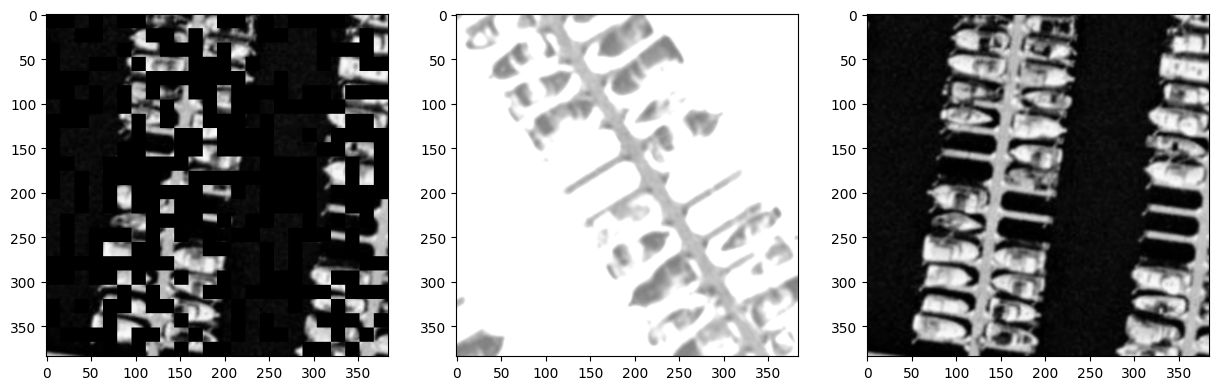

tf.Tensor(
[0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0.
 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1.
 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1.
 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 0.
 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 0. 1.
 0. 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0.
 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 

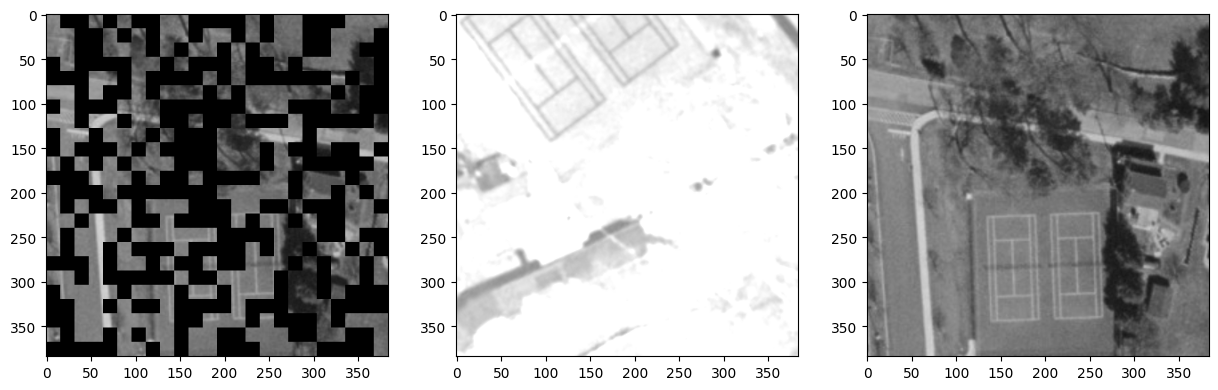

tf.Tensor(
[0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.
 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1.
 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 0. 1. 1.
 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1.
 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0.
 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1.
 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1.
 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 

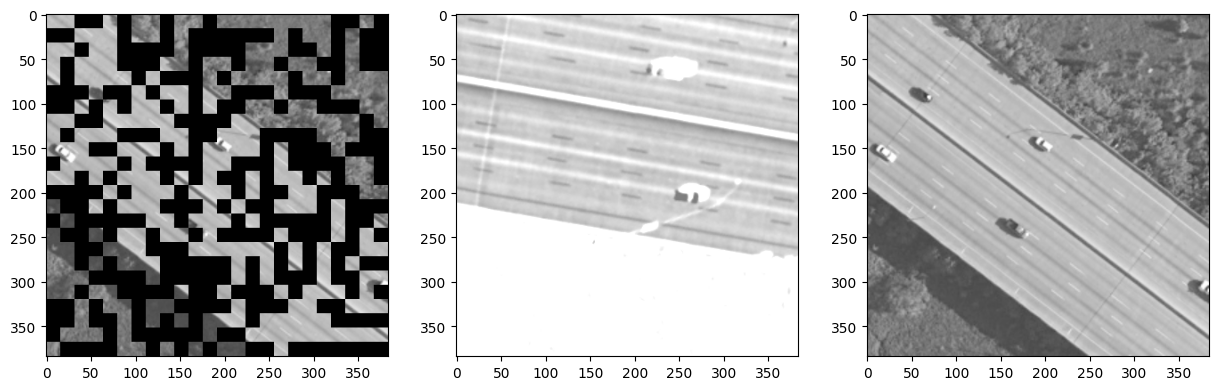

tf.Tensor(
[1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 1.
 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1.
 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0.
 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1.
 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0.
 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 

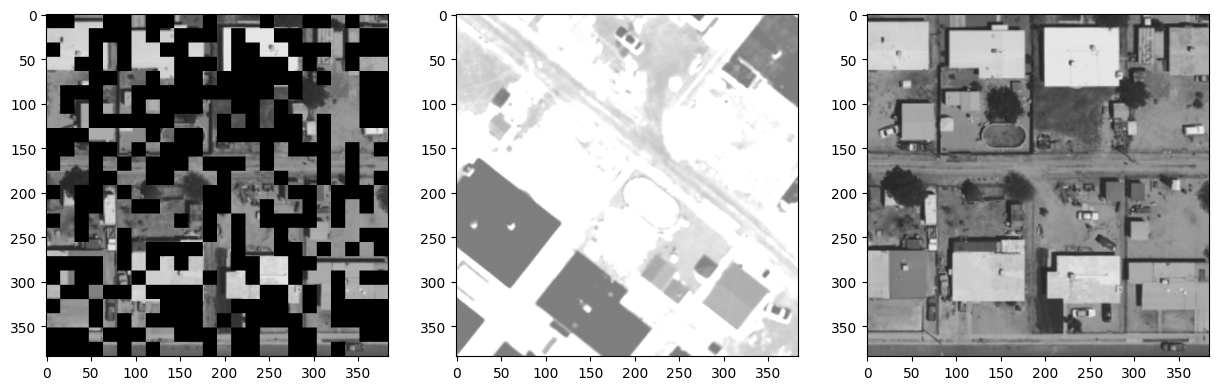

tf.Tensor(
[0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 1. 0. 1. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 0. 1.
 0. 1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0.
 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 1.
 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 1. 1.
 1. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 0.
 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1. 0. 0. 1.
 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 1. 

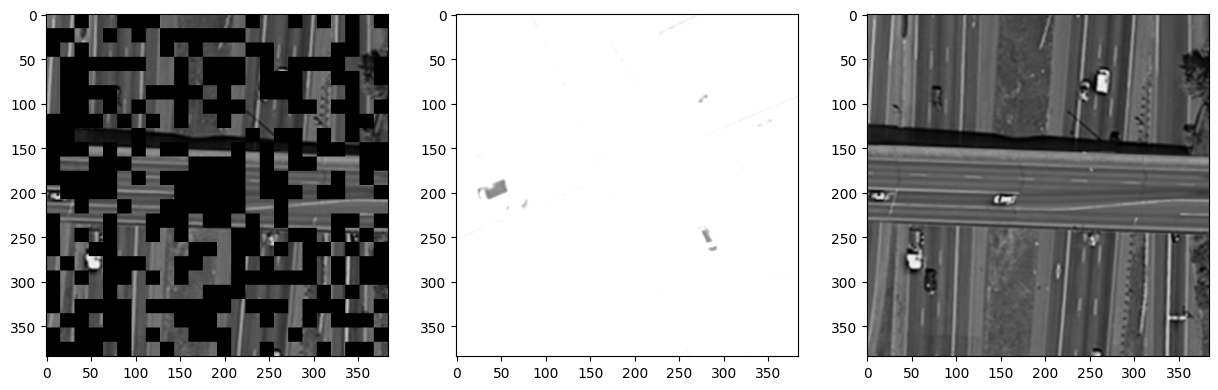

Model: "VisionTransformerSmall16_Metaformer_res384_type_attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_images        │ (None, 384, 384,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ VisionTransformerS… │ (None, 577, 384)  │ 21,811,584 │ Input_images[0][… │
│ (VisionTransformer… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ EmbeddingMLP        │ (None, 577, 512)  │    197,120 │ VisionTransforme… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1d              │ (None, 1, 512)    │          0 │ EmbeddingMLP[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zeros_like          │ (None, 1, 512)    │          0 │ pool1d[0][0]      │
│ (ZerosLike)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ register_token      │ (None, 1, 512)    │    262,656 │ zeros_like[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ones_like           │ (None, 1, 512)    │          0 │ register_token[0… │
│ (OnesLike)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cls_token (Dense)   │ (None, 1, 512)    │    262,656 │ zeros_like[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1, 512)    │          0 │ ones_like[0][0]   │
│ (Concatenate)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 579, 512)  │          0 │ EmbeddingMLP[0][… │
│ (Concatenate)       │                   │            │ cls_token[0][0],  │
│                     │                   │            │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MetaEncoder_attent… │ (None, 579, 512)  │  1,313,280 │ concatenate_1[0]… │
│ (MetaEncoder)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SpatialDropout1     │ (None, 579, 512)  │          0 │ MetaEncoder_atte… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ MetaEncoder_attent… │ (None, 579, 512)  │  1,313,280 │ SpatialDropout1[… │
│ (MetaEncoder)       │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SpatialDropout2     │ (None, 579, 512)  │          0 │ MetaEncoder_atte… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 577, 512)  │          0 │ SpatialDropout2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 1, 512)    │          0 │ SpatialDropout2[… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CLS_Att_Pooling     │ [(None, 1, 512),  │  1,050,624 │ get_item[0][0],   │
│ (MultiHeadAttentio… │ (None, 8, 1, 1)]  │            │ get_item_1[0][0]

 Total params: 26,211,200 (99.99 MB)

 Trainable params: 26,211,200 (99.99 MB)

 Non-trainable params: 0 (0.00 B)

(24, 384, 384, 3)
(24, 384, 384, 3)
(<tf.Tensor: shape=(24, 512), dtype=float32, numpy=
array([[ 0.20146444, -0.16663262,  0.16333109, ..., -0.03674451,
         0.02942099, -0.11610991],
       [ 0.1474969 ,  0.01715136,  0.10564823, ...,  0.02400475,
        -0.00792008, -0.15442552],
       [ 0.14935508, -0.01471167,  0.13481799, ...,  0.02003461,
        -0.01552271, -0.07762485],
       ...,
       [ 0.10376678,  0.0079485 ,  0.08612793, ..., -0.04761175,
        -0.00946165, -0.05118446],
       [ 0.12553342, -0.11562739,  0.08596159, ...,  0.01116149,
        -0.03499346, -0.01579129],
       [ 0.07057396, -0.00493355,  0.07198018, ...,  0.01318186,
        -0.0618645 , -0.127806  ]], dtype=float32)>, <tf.Tensor: shape=(24, 577, 512), dtype=float32, numpy=
array([[[-0.29934448,  1.2625585 ,  1.0413672 , ...,  5.5815215 ,
         -0.19102392,  0.33834124],
        [ 0.14514467,  0.3990147 ,  1.5404699 , ...,  4.255404  ,
          0.21314688, -0.10103865],
        [-0.42936444, 

In [ ]:
if test_drive and mim:
    tf.keras.backend.clear_session()
    for data in train_ds_masked.take(1):
        mask_sequence, mask_image, image, original_image = data
        mask_sets = data
    for index in range(5):
        print(mask_sequence[index])
        fig, axes = plt.subplots(1,3, figsize=(15,5))
        axes = axes.flatten()
        axes[0].imshow(tf.cast(mask_image[index], "uint8"))
        axes[1].imshow(tf.cast(image[index], "uint8"))
        axes[2].imshow(tf.cast(original_image[index], "uint8"))
        plt.show()
    #resnet = keras_cv.models.ResNetV2Backbone(stackwise_filters=[64, 128, 256, 512], stackwise_blocks=[2, 2, 2, 2], stackwise_strides=[1, 2, 2, 2], include_rescaling = True, input_shape = [res,res,3])
    
    conv_tiny = keras.applications.ConvNeXtTiny(input_shape = [res,res,3], include_top = False, weights = None
                                               )
    vit = kimm.models.VisionTransformerSmall16(input_shape = [res,res,3], include_top = False)
    
    for layer in conv_tiny.layers:
        layer.dtype_policy = keras.mixed_precision.Policy('mixed_float16')
    for layer in vit.layers:
        layer.dtype_policy = keras.mixed_precision.Policy('mixed_float16')
    vit_model = get_metaformer(mode, res, grayscale = grayscale, 
                               att_depth = 2, att_heads = heads, 
                               att_dims = 64, 
                               embed_dims = embed_dims, patch_size = patch_size,
                              register_tokens = 0,
                               #pretrained_encoder = conv_tiny, 
                               pretrained_encoder = vit, pretrained_vit = True,
                               return_patches = True
                              )
    #vit_model = ViT_rollout(res = res, att_depth = 8, att_heads = heads, att_dims = heads * 32, embed_dims = embed_dims, patch_size = patch_size, name = "ViT")
    #conv_base = get_encdec_model(conv_tiny, res = res, q_size = q_size,
    #                             compression_rate = [8,16,32], att_dims = embed_dims, att_heads=heads,
    #                            #encoder_trainable = True
    #                            )
    #ssl = MixedMIM(vit_model, grayscale = grayscale, patch_size = patch_size) #SimMIM or MixedMIM
    vit_model.summary()
    #ssl = DINO_MIM(vit_model, vit_model)
    
    ssl = NCLR(vit_model, 
                embed_dims = embed_dims, 
                use_mim = True, 
                subtype = "nnclr", t = 0.1,
                patch_size = patch_size
               ) #nnclr, snclr
    ssl.compile(optimizer = keras.optimizers.AdamW(learning_rate = 5e-5, 
                                                   clipnorm = 1.0,
                                                  use_ema = True,
                                                  gradient_accumulation_steps = 16
                                                  ),
                jit_compile = False)
    print(ssl(data))
    
    result = ssl.fit(train_ds_masked, epochs = 1, steps_per_epoch = 200)
    print(result)
    
    
    try:
        imgs, merged_imgs = att_visualize(ssl.get_full_model(res=res), data[-1], res = res,
                            thresholding = 1)
    except Exception as e:
        print(e)
        imgs, merged_imgs = att_visualize(ssl.feature_extractor, data[-1], res = res,
                            thresholding = 1)
    
    
    #imgs, merged_imgs = q_visualize(ssl.feature_extractor, data[-1], res = res, thresholding = 0, merge_type = 'mean')
    for row in range(batch_size):
        fig, axes = plt.subplots(1, heads, figsize = (8*heads,8))
        axes = axes.flatten()
        for col in range(heads):
            axes[col].imshow(imgs[row, col, ...])
    plt.show()
    
    
    fig,axes = plt.subplots(1, 5, figsize = (30,6))
    axes = axes.flatten()
    for ax, merge in zip(axes, merged_imgs):
        ax.imshow(merge)
        ax.set_title("Naive mean merged")
    plt.show()
    
    ############################
    
    heatmap, merged_weight_imgs = att_visualize_merged(ssl.feature_extractor, data[-1], res = res, merge_type = 'mean')
    fig,axes = plt.subplots(1, 5, figsize = (30,6))
    axes = axes.flatten()
    for ax, merge in zip(axes, merged_weight_imgs):
        ax.imshow(merge)
        ax.set_title("MaxOut merged")
    plt.show()
    
    heatmap, imposed_image = pca_patch_viz(ssl.feature_extractor, data[-1])
    for i in range(batch_size):
        fig, axes = plt.subplots(1,3, figsize = (18,5))
        axes = axes.flatten()
        axes[0].imshow(ops.cast(heatmap[i], "uint8"))
        axes[1].imshow(ops.cast(imposed_image[i], "uint8"))
        axes[2].imshow(ops.cast(original_image[i], "uint8"))
        plt.show()
    #vit
    #_, rollout_images = get_attention_rollout(ssl.feature_extractor, data[-1])
    #fig,axes = plt.subplots(1, 5, figsize = (30,6))
    #axes = axes.flatten()
    #for ax, merge in zip(axes, rollout_images[:5]):
    #    ax.imshow(merge)
    #    ax.set_title("Rollout merged")
    #plt.show()
    feature_map = ssl.feature_extractor(sample_images)[1] ; w__ = ops.sqrt(ops.cast(ops.shape(feature_map)[1], "float32")
                                                                          )
    clustering_output = H_clustering(n_clusters = 50)(feature_map)
    for i in range(batch_size):
        fig, axes = plt.subplots(1, 2, figsize = (16,9))
        axes = axes.flatten()
        axes[0].imshow(ops.cast(sample_images[i], "uint8"))
        axes[1].imshow(ops.reshape(clustering_output[i], [w__,w__])
                      )
    plt.show()
    #feature vectors
    embed_v = feature_visualize(ssl, sample_images)
    plt.scatter(embed_v[..., 0], embed_v[...,1])
    plt.plot()
    plt.show()

In [72]:
if test_drive and other:
    tf.keras.backend.clear_session()
    
    vit_model = get_metaformer(mode, res, grayscale = grayscale, 
                               att_depth = att_depth, att_heads = heads, 
                               att_dims = heads * 64, 
                               embed_dims = heads * 64, patch_size = patch_size,
                              register_tokens = 4,
                              #pretrained_encoder = keras.applications.EfficientNetV2B1(input_shape = [res,res,3], include_top = False),
                              pretrained_encoder = None, 
                               return_patches = True
                              )
    vit_model.summary()
    ssl = MixedUnsupSeg(feature_extractor = vit_model, q = 5)
    
    ssl.compile(optimizer = keras.optimizers.AdamW(learning_rate = 1e-4, clipnorm = 1.0,
                                                  #use_ema = True,
                                                  #gradient_accumulation_steps = 16
                                                  ),
                jit_compile = False)
    
    print(ssl(sets[0]))
    ssl.summary()
    result = ssl.fit(train_ds_masked, epochs = 1, steps_per_epoch = 100)
    print(result)
    try:
        imgs = att_visualize(ssl.get_full_model(res=res), sets[0], res = res,
                            thresholding = 1)
    except Exception as e:
        print(e)
        imgs = att_visualize(ssl.feature_extractor, sets[0], res = res,
                            thresholding = 1)
    for row in range(12):
        fig, axes = plt.subplots(1, heads, figsize = (5*heads,5))
        axes = axes.flatten()
        for col in range(heads):
            axes[col].imshow(imgs[row, col, ...])
    plt.show()
    
    try:
        heatmap, imposed_images = ssl.get_segments(sets[0])
        i = 0
        for original_img, imposed_img in zip(sets[0], imposed_images):
            fig,axes = plt.subplots(1, 2, figsize = (10,5))
            axes = axes.flatten()
            axes[0].imshow(ops.cast(original_img, "uint8"))
            axes[1].imshow(ops.cast(imposed_img, "uint8"))
            i += 1
            if i >= 5:
                break
    except:
        pass